# Crystal Field Calculations

In [2]:
import sympy
import numpy as np
# from sympy.functions.special.spherical_harmonics import Ynm as Ynm_sym
from sympy import Symbol, pi, sqrt, Sum, simplify, Rational, Q, refine
from scipy.special import sph_harm as Ynm_num
from sympy import poly, lambdify
from IPython.display import display, Math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sympy import diff, factorial, poly, symbols, latex
%config InlineBackend.figure_format='retina'

# Multiplets of Transition-Metal Ions in Crystals
Tanabe, Sugano, and Kamimura

## Chapter I : Single d-electron in a ligand field

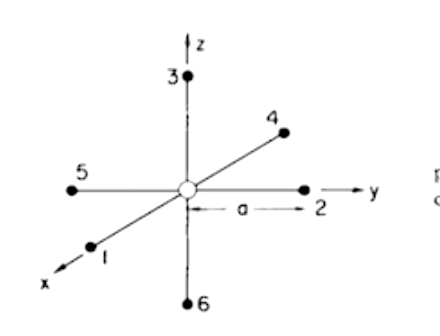

An expansion of the elctrostatic field due to the six point charges results in the following:

$V_c = \sum_{k=0}^{\infty} \sum_{m=-k}^{k} r^k q_{k,m} C_m^{(k)}(\theta, \phi)$

where 

$q_{k,m} = \sqrt{\frac{4\pi}{2 k + 1}} \frac{Z e^2}{a^{k+1}} \sum_{i=1}^{6} Y_{k,m}^{*}(\theta_i, \phi_i)$

and

$C_m^{(k)} (\theta,\phi) = \sqrt{\frac{4\pi}{2k+1}} Y_{k,m}(\theta, \phi)$

### Problem 1.1: Derive (1.23)

$V_c^0 = D(x^4+y^4+z^4-3/5 r^4) + \ldots$

This is most easily done by doing the McLaurin series of the potential in terms of cartesian coordinates.

$V(r) = Z e^2 \sum_{i=1}^6 \frac{1}{\left|\vec{r}-\vec{R_i}\right|} = Z e^2 / a \sum_{i=1}^6 \frac{1}{\left|\vec{r/a}-\vec{R_i/a}\right|} $

Without loss of generality one may take a = 1 and Ze^2=1. This makes the energy unit be Ze^2/a

In [189]:
x,y,z,a,Z,e = symbols("x y z a Z e")

In [140]:
def univar_series(expression, variable, eval_point, degree):
  # for this use case this is faster than sympy's implementation
  # compute symbolic expressions for the derivatives
  expr = expression
  derivatives_expressions = [expression]
  for deg in range(1, degree+1):
    derivatives_expressions.append(diff(derivatives_expressions[-1], variable))
  # evaluate them at eval_point
  derivatives_evaled = [chunk.subs(variable, eval_point) for chunk in derivatives_expressions]
  # construct the polynomial
  poly = sum([Rational(1,factorial(deg)) * (variable-eval_point)**deg * derivative for deg, derivative in zip(range(degree+1), derivatives_evaled)])
  return poly
def multivar_series(expression, variables, eval_points, degree):
  poly = expression
  for variable, eval_point, idx in zip(variables, eval_points, range(len(variables))):
    poly = univar_series(poly, variable, eval_point, degree)
  return simplify(poly)

In [227]:
# point_charges = [[1,0,0],[0,1,0],[-1,0,0],[0,-1,0],[0,0,1],[0,0,-1]]
point_charges = [[a,0,0],[0,a,0],[-a,0,0],[0,-a,0],[0,0,a],[0,0,-a]]
cartesianFieldFull = (Z*e**2)*sum([1/sqrt((x-v[0])**2+(y-v[1])**2+(z-v[2])**2) for v in point_charges])

In [229]:
order = 4
cartesianField = refine(multivar_series(cartesianFieldFull,(x,y,z),(0,0,0),order),Q.positive(a))

In [230]:
!say "finished"

In [231]:
xpoly = poly(cartesianField, x, y, z)
poly_coefficients = xpoly.as_dict()
expansion = {}
for order in range(0,order+1):
  expansion[order] = { k : v for k,v in poly_coefficients.items() if sum(k) == order}
poly_parts = {}
for order, term in expansion.items():
  chunk = [(v,x**k[0]*y**k[1]*z**k[2]) for k,v in term.items()]
  if chunk:
    poly_parts[order] = (chunk)

In [232]:
comparison = (Rational(35,4)*Z*e**2/a**5*(x**4+y**4+z**4-Rational(3,5)*(x**2+y**2+z**2)*(x**2+y**2+z**2)))
polycomparison = poly(comparison, x, y, z)
poly_coefficients_comparison = polycomparison.as_dict()
comparison_expansion = {}
for order in range(0,max_order+1):
  comparison_expansion[order] = { k : v for k,v in poly_coefficients_comparison.items() if sum(k) == order}
comparison_poly_parts = {}
for order, term in comparison_expansion.items():
  chunk = [(v,x**k[0]*y**k[1]*z**k[2]) for k,v in term.items()]
  if chunk:
    comparison_poly_parts[order] = (chunk)

In [240]:
buf = ''
for order, terms in poly_parts.items():
  display(Math("======O(%d)======" % order))
  for bit in terms:
    display(Math('%s :|: %s \\\\ x'%(latex(bit[0]),latex(bit[1]))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [254]:
buf = ''
for order, terms in poly_parts.items():
  buf+=("======O(%d)====== \\\\" % order)
  for bit in terms:
    buf+=('%s :|: %s \\\\ '%(latex(bit[0]),latex(bit[1])))
display(Math(buf))

<IPython.core.display.Math object>

In [255]:
buf = ''
for order, terms in comparison_poly_parts.items():
  buf+=("======O(%d)====== \\\\" % order)
  for bit in terms:
    buf+=('%s :|: %s \\\\ '%(latex(bit[0]),latex(bit[1])))
display(Math(buf))

<IPython.core.display.Math object>

In [250]:
cartesianFun = lambdify((x,y),cartesianField.subs(z,0).subs(Z,1).subs(a,1).subs(e,1),"numpy")
cartesianFunFull = lambdify((x,y),cartesianFieldFull.subs(z,0).subs(Z,1).subs(a,1).subs(e,1),"numpy")

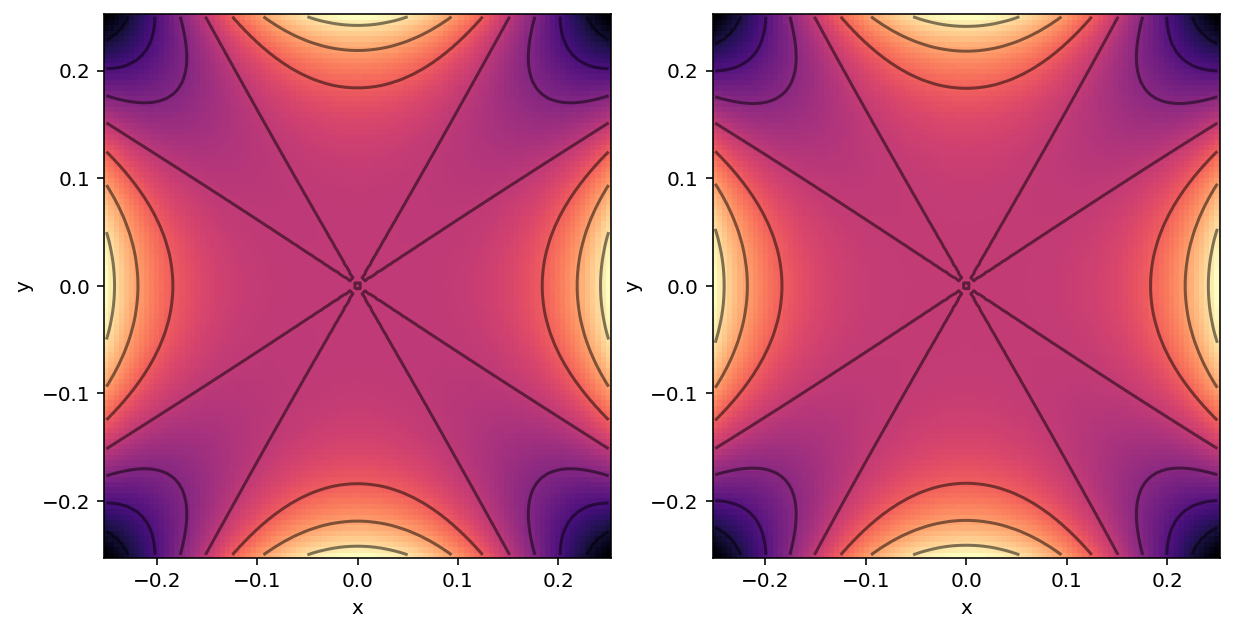

In [251]:
x_num = 0.25*np.linspace(-1,1,100)
y_num = 0.25*np.linspace(-1,1,100)
xv, yv = np.meshgrid(x_num,y_num)
zv1 = cartesianFun(xv, yv)
zv2 = cartesianFunFull(xv, yv)
fig,ax = plt.subplots(ncols=2,figsize=(10,5))
ax[0].pcolor(xv,yv,zv1,
           cmap='magma',
           shading='auto',
           norm=LogNorm(vmin=zv1.min(), vmax=zv1.max()))
ax[0].contour(xv,yv,zv1,colors='black',alpha=0.5)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].pcolor(xv,yv,zv2,
           cmap='magma',
        shading='auto',
           norm=LogNorm(vmin=zv2.min(), vmax=zv2.max()))
ax[1].contour(xv,yv,zv2,colors='black',alpha=0.5)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
plt.show()

### Calculate Table 1.2

In [257]:
from sympy.physics.quantum.cg import CG
from sympy import latex
from IPython.display import display, Math, Latex

In [258]:
def threeYintegral(l,m,l1,m1,l2,m2):
    return 1/sqrt(pi)*sqrt(Rational((2*l1+1)*(2*l2+1),(4*(2*l+1)))) * CG(l1,0,l2,0,l,0) * CG(l1,m1,l2,m2,l,m)

In [259]:
def c(k, l, m, lp, mp):
    if isinstance(l,str):
        l = {'s':0,'p':1,'d':2,'f':3}[l]
    if isinstance(lp,str):
        lp = {'s':0,'p':1,'d':2,'f':3}[lp]
    return sqrt(4*pi/(2*k+1))*threeYintegral(l,m,k,m-mp,lp,mp)

In [260]:
job_strings_0 = ['s p 0 1,s p 0 0',
    's f 0 3,s f 0 2,s f 0 1,s f 0 0',
    'p d 1 2,p d 1 1,p d 1 0,p d 0 2,p d 0 1,p d 0 0,p d 1 -2,p d 1 -1',
    'd f 2 3,d f 2 2,d f 2 1,d f 2 1,d f 2 0,d f 1 3,d f 1 2,d f 1 1,d f 1 0,d f 0 3,d f 0 2,d f 0 1,d f 0 0,d f 2 -3,d f 2 -2,d f 2 -1,d f 2 -1,d f 1 -3,d f 1 -2,d f 1 -1']
job_strings = []
for line in job_strings_0:
    job_strings.extend(line.split(','))

In [261]:
jobs = []
for job in job_strings:
    bit1, bit2, bit3, bit4 = job.split()
    jobs.append([bit1,int(bit3), bit2, int(bit4)])

In [243]:
def fmt_table(data, center_data=False, add_row_nums=False, latify=True):
    '''Create a LaTeX table from a given list of lists'''
    from math import ceil
    buf='''
\\newcommand\\T{\\Rule{0pt}{1em}{.3em}}
\\begin{array}{%s}
'''
    max_cols = max(len(r) for r in data)
    column_spec = '|' + '|'.join(['c']*max_cols) + '|'
    buf = buf % column_spec
    row_idx = 0
    for row_data in data:
        row = ''
        if add_row_nums and row_idx > 0:
            row += str(row_idx) + " & "
        if center_data and row_idx > 0:
            to_add = ceil( (max_cols - len(row_data))/2 )
            row += ' & '.join([''] * to_add)
        if latify:
          row_data = [latex(r) for r in row_data]
        row += ' & '.join(row_data)
        if row_idx == 0:
            row = '''\\hline''' + row + '''\\\\\hline'''
        else:
            row += '''\\\\\hline'''
        row += "\n"
        buf += row
        row_idx += 1
    buf += '''\\end{array}'''
    # print(buf)
    return buf

In [263]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
print('Num cores = %d' % num_cores)

Num cores = 20


In [264]:
table = {}
for job in jobs:
  llp = job[0], job[2]
  if llp not in table.keys():
    table[llp] = []
  row = [simplify(c(k,*job).doit()) for k in [1,3,5]]
  table[llp].append({(job[1],job[3]):row})

In [265]:
final_table = []
for k in table.keys():
  rows = []
  for kp in table[k]:
    for kpp in kp.keys():
      rows.append([*k, *kpp, *kp[kpp]])
  final_table.extend(rows)

In [266]:
display(Math(fmt_table(final_table)))

<IPython.core.display.Math object>

### Problem 1.2

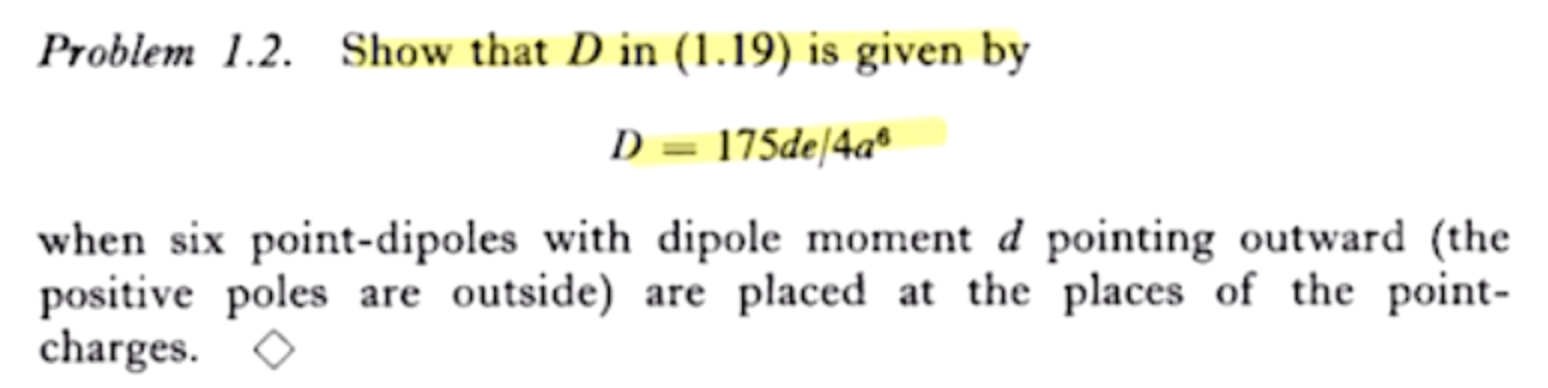

In this case the approach of using cartesian coordinates from the start is not fruitful. The expansion in spherical harmonics could be more useful.
It might also be interesting to approach this problem as a limite of point charges separated at a small distance.

#### Superposed point charges at first order in the separation distance

In [546]:
from sympy import conjugate, sympify
from sympy.functions.special.spherical_harmonics import Ynm
from sympy.physics.quantum.cg import CG
@classmethod
def new_eval(cls, n, m, theta, phi):
    n, m, theta, phi = [sympify(x) for x in (n, m, theta, phi)]
    # Handle negative index m and arguments theta, phi
    #if m.could_extract_minus_sign():
    #    m = -m
    #    return S.NegativeOne**m * exp(-2*I*m*phi) * Ynm(n, m, theta, phi)
    if theta.could_extract_minus_sign():
        theta = -theta
        return Ynm(n, m, theta, phi)
    if phi.could_extract_minus_sign():
        phi = -phi
        return exp(-2*I*m*phi) * Ynm(n, m, theta, phi)
Ynm.eval = new_eval

In [56]:
def from_expression_to_ket(superposition):
  superposition = superposition.expand()
  summands_and_multipliers =  superposition.as_coefficients_dict()
  chunks = []
  for k in summands_and_multipliers.keys():
    factors = k.as_ordered_factors()
    phase = summands_and_multipliers[k]
    for factor in factors:
      if isinstance(factor,Ynm):
        harmonic = factor.args[:2]
      else:
        phase = phase*factor
    chunks.append((phase, harmonic))
  total_chunks = {}
  for chunk in chunks:
    if chunk[1] not in total_chunks.keys():
      total_chunks[chunk[1]] = 0
    total_chunks[chunk[1]] += chunk[0] 
  return total_chunks

In [57]:
def threeHarmonicIntegrate(l1, m1, l2, m2, l3, m3):
  tri = sqrt(Rational((2*l2+1)*(2*l3+1),(2*l1+1)))/sqrt(4*pi)*CG(l2,0,l3,0,l1,0)*CG(l2,m2,l3,m3,l1,m1)
  return tri
def threeHarmonicbraket(l1,m1,pot,l2,m2):
  pot = from_expression_to_ket(pot)
  parts = []
  for k, v in pot.items():
    integral = v*threeHarmonicIntegrate(l1,m1,*k,l2,m2)
    parts.append(integral)
  return sum(parts)

In [197]:
theta, phi, e, a, b, r, d = symbols("theta phi e a b r d") 

In [198]:
cubic_angles = [[pi/2,0],[pi/2,pi/2],[pi/2,pi],[pi/2,3*pi/2],[0,0],[pi,0]]
def q(k,m,d):
  summands = [conjugate(Ynm(k,m,t,p).expand(func=True)) for t,p in cubic_angles]
  return sqrt(np.pi) * sqrt(Rational(4, 2*k+1)) * e / d**(k+1) * sum(summands)
def C(k,m):
  return sqrt(np.pi) * sqrt(Rational(4, 2*k+1)) * Ynm(k,m,theta,phi)
def VCF(kmax,d):
  vcf = 0
  for k in range(kmax+1):
    parts = [r**k * q(k,m,d) * C(k,m) for m in range(-k,k+1)]
    vcf += sum(parts)
  return vcf

In [204]:
order = 4
dipPotential = (univar_series(-VCF(order,a+d/2) + VCF(order,a-d/2), d, 0, 1)).expand()

In [698]:
compare = ((175/4)*(2/105)*np.array([1,1,-4,-4,6,5,5]))

In [704]:
multipliers = []
# iterate through all the values of m and keep the coefficient
# of the termn which includes symbol r
for job in [(2,2),(-2,-2),(1,1),(-1,-1),(0,0),(2,-2),(-2,2)]:
  chunks = (N((threeHarmonicbraket(2,job[0],dipPotential,2,job[1])).doit()).as_coefficients_dict())
  for k,v in chunks.items():
    if r in k.free_symbols:
      break
  multipliers.append(v)
print(np.array([multipliers,compare]).T)

[[0.833333333333333 0.8333333333333334]
 [0.833333333333333 0.8333333333333334]
 [-3.33333333333333 -3.3333333333333335]
 [-3.33333333333333 -3.3333333333333335]
 [5.00000000000000 5.0]
 [4.16666666666667 4.166666666666667]
 [4.16666666666667 4.166666666666667]]


In [705]:
N((threeHarmonicbraket(2,2,dipPotential,2,2)).doit())

6.0*d*e/a**2 + 0.833333333333333*d*e*r**4/a**6

#### cartesian approach

In [303]:
x,y,z,a,Z,e,p = symbols("x y z a Z e p")

In [304]:
from sympy.physics.vector import *
N = ReferenceFrame('N')

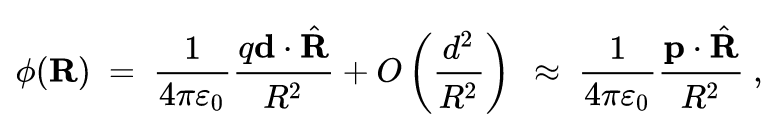

In [305]:
point_dipole_locations = [[a,0,0],[0,a,0],[-a,0,0],[0,-a,0],[0,0,a],[0,0,-a]]
point_dipole_locations = [ (v[0]*N.x + v[1]*N.y + v[2]*N.z) for v in point_dipole_locations]
dipole_moment = p*N.z
r = x*N.x + y*N.y + z*N.z
cartesianFieldFull = (Z*e)*sum([ dipole_moment.dot(r-dip_loc)/(sqrt((r-dip_loc).dot(r-dip_loc))**(3)) for dip_loc in point_dipole_locations])

In [306]:
order = 4
cartesianField = refine(multivar_series(cartesianFieldFull,(x,y,z),(0,0,0),order),Q.positive(a))

In [307]:
cartesianField

Z*e*p*z*(a**2*(336*a**6*x**2 + 180*a**4*x**4 + a**4*y**2*(336*a**2 - 2160*x**2) + y**4*(180*a**4 + 20475*x**4)) + z**2*(-224*a**8 + 360*a**6*x**2 - 6930*a**4*x**4 + a**2*y**2*(360*a**4 + 40950*x**4) + y**4*(-6930*a**4 + 40950*a**2*x**2 - 311850*x**4)))/(16*a**13)

In [308]:
xpoly = poly(cartesianField, x, y, z)
poly_coefficients = xpoly.as_dict()
expansion = {}
for order in range(0,order+1):
  expansion[order] = { k : v for k,v in poly_coefficients.items() if sum(k) == order}
poly_parts = {}
for order, term in expansion.items():
  chunk = [(v,x**k[0]*y**k[1]*z**k[2]) for k,v in term.items()]
  if chunk:
    poly_parts[order] = (chunk)

In [309]:
buf = ''
for order, terms in poly_parts.items():
  display(Math("======O(%d)======" % order))
  for bit in terms:
    display(Math('%s :|: %s \\\\'%(latex(bit[0]),latex(bit[1]))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Problem 1.3

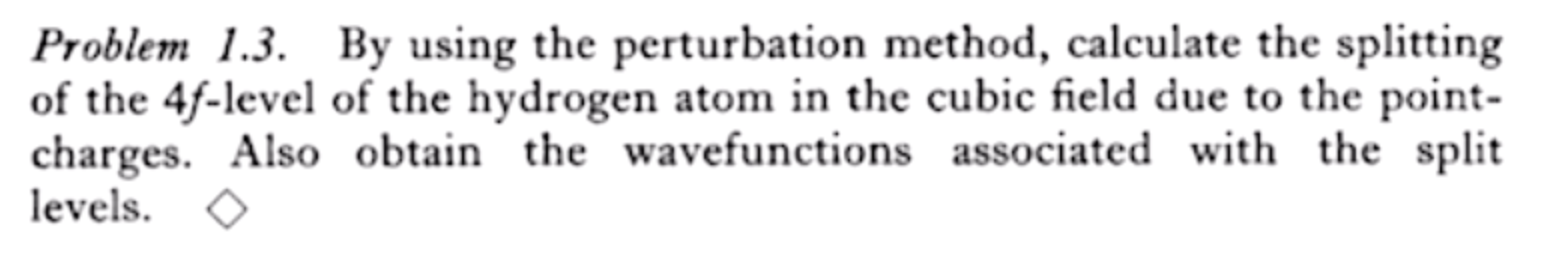

In [591]:
from sympy import Matrix

In [592]:
def fmt_table(data, center_data=False, add_row_nums=False, latify=True):
    '''Create a LaTeX table from a given list of lists'''
    from math import ceil
    buf='''
\\newcommand\\T{\\Rule{0pt}{1em}{.3em}}
\\begin{array}{%s}
'''
    max_cols = max(len(r) for r in data)
    column_spec = '|' + '|'.join(['c']*max_cols) + '|'
    buf = buf % column_spec
    row_idx = 0
    for row_data in data:
        row = ''
        if add_row_nums and row_idx > 0:
            row += str(row_idx) + " & "
        if center_data and row_idx > 0:
            to_add = ceil( (max_cols - len(row_data))/2 )
            row += ' & '.join([''] * to_add)
        if latify:
          row_data = [latex(r) for r in row_data]
        row += ' & '.join(row_data)
        if row_idx == 0:
            row = '''\\hline''' + row + '''\\\\\hline'''
        else:
            row += '''\\\\\hline'''
        row += "\n"
        buf += row
        row_idx += 1
    buf += '''\\end{array}'''
    # print(buf)
    return buf

In [652]:
order = 4
pointPotential = VCF(order,a).expand()

In [653]:
pointPotential = pointPotential - 6*e/a * sqrt(4*pi) * Ynm(0,0,theta,phi)

In [666]:
l = 3
matrix = []
for m in range(-l,l+1):
  row = [N((threeHarmonicbraket(l,m,pointPotential,l,mp)).doit()) for mp in range(-l,l+1)]
  matrix.append(row)

In [667]:
little_ham = Matrix(matrix)
little_ham=little_ham.subs(a,1).subs(e,1).subs(r,1)

In [668]:
eigen_system = little_ham.eigenvects()

In [669]:
eigen_syst = little_ham.eigenvects()

In [670]:
eigen_vals = [N(level[0]) for level in eigen_syst]
unique_eigen_vals = np.unique(np.array(eigen_vals).astype(np.float64).round(decimals=4),return_counts=True)

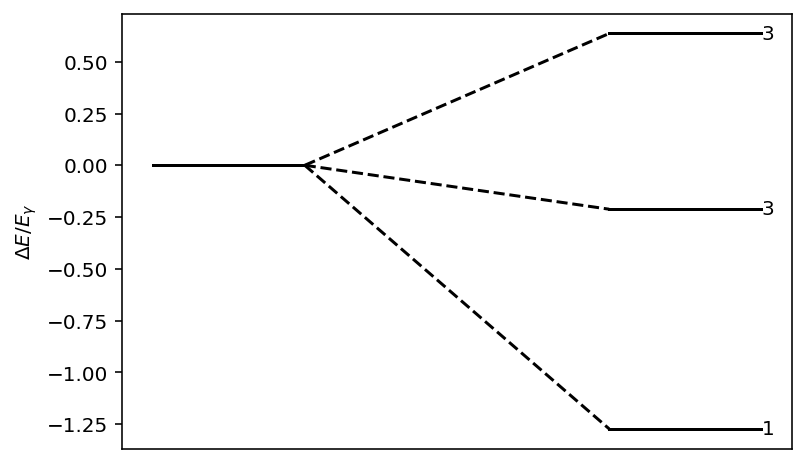

In [672]:
plt.figure()
for level, mult in zip(*unique_eigen_vals):
  plt.plot([-3,-2],[0,0],'k')
  plt.plot([-2,0],[0,level],'k--')
  plt.plot([0,1],[level]*2,'k')
  plt.text(1,level,'%d' % mult,va='center')
plt.gca().get_xaxis().set_ticks([])
plt.ylabel('$\Delta E / E_\gamma$')
plt.show()

In [673]:
from sympy import Abs

In [674]:
unique_eigensystem = {}
full_kets = [Ket(m) for m in range(-l,l+1)]
for level in eigen_syst:
  eigen_energy = round(float(N(level[0])),4)
  if eigen_energy not in unique_eigensystem.keys():
    unique_eigensystem[eigen_energy] = {'multiplicity':0, 'kets':[]}
  unique_eigensystem[eigen_energy]['multiplicity'] += level[1]
  kets = level[2]
  states = []
  for ket in kets:
    states.append(N(ket,2).dot(full_kets))
  unique_eigensystem[eigen_energy]['kets'].extend(states)

In [675]:
for eigen_energy in unique_eigensystem:
  display(Math('\Delta{E} = %.2f' % eigen_energy))
  for ket in unique_eigensystem[eigen_energy]['kets']:
    display(Math(latex(ket)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [676]:
unique_eigensystem = {}
full_kets = [Ynm(l,m,theta,phi) for m in range(-l,l+1)]
for level in eigen_syst:
  eigen_energy = round(float(N(level[0])),4)
  if eigen_energy not in unique_eigensystem.keys():
    unique_eigensystem[eigen_energy] = {'multiplicity':0, 'kets':[]}
  unique_eigensystem[eigen_energy]['multiplicity'] += level[1]
  kets = level[2]
  states = []
  for ket in kets:
    states.append(ket.dot(full_kets))
  unique_eigensystem[eigen_energy]['kets'].extend(states)

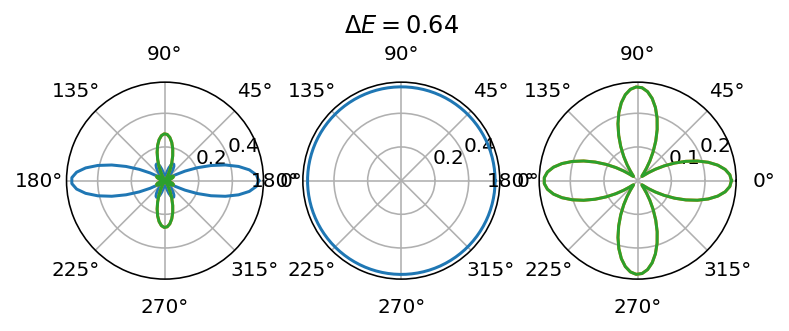

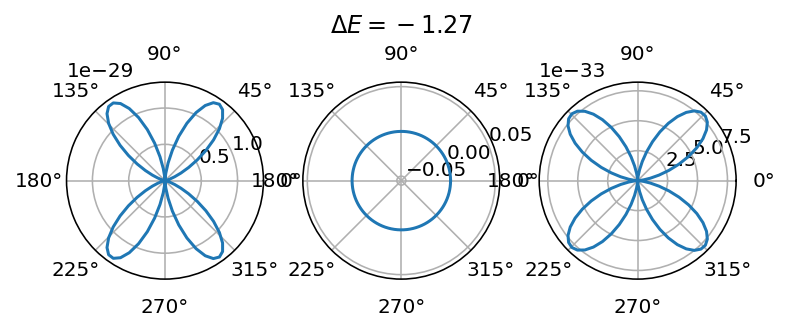

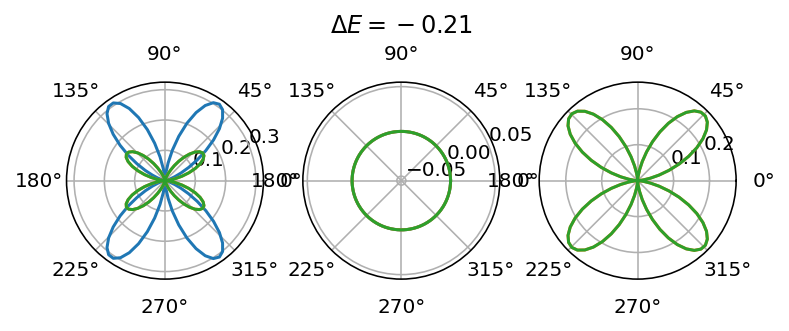

In [677]:
angles = np.linspace(0,2*np.pi,100)
for eigen_energy in unique_eigensystem:
  fig,ax = plt.subplots(ncols = 3, subplot_kw={'projection': 'polar'})
  for ket in unique_eigensystem[eigen_energy]['kets']:
    afun_symp = (ket.subs(phi,np.pi)).doit()
    afun = lambdify((theta),afun_symp,modules=["sympy"])
    values = [float(Abs(N(afun(angle))))**2 for angle in angles]
    ax[0].plot(angles,values)
  for ket in unique_eigensystem[eigen_energy]['kets']:
    afun_symp = (ket.subs(theta,0)).doit()
    afun = lambdify((phi),afun_symp,modules=["sympy"])
    values = [float(Abs(N(afun(angle))))**2 for angle in angles]
    ax[1].plot(angles,values)
  ax[1].set_title('$\Delta{E} = %.2f$'% eigen_energy)
  for ket in unique_eigensystem[eigen_energy]['kets']:
    afun_symp = (ket.subs(theta,pi/2)).doit()
    afun = lambdify((phi),afun_symp,modules=["sympy"])
    values = [float(Abs(N(afun(angle))))**2 for angle in angles]
    ax[2].plot(angles,values)
  plt.show()

### Problem 1.4

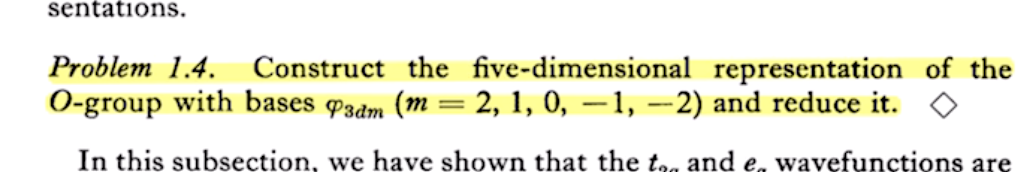

We need to find the effect of the group operations on Y2m for m = 2,1,0,-1,-2.
Just for fun I shall do this numerically. To accomplish this I must find the transformation of cartesian coordinates induced by the group operations. I must also use the expressions for the l=2 spherical harmonics in terms of cartesian coordinates. Then using the coordinate transformations, I must then see after their application their decomposition in terms of spherical harmonics.

In [1943]:
from sympy.vector import CoordSys3D
from sympy import sin, cos, integrate, I, Matrix
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import display
import pickle

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
print('Num cores = %d' % num_cores)

xyz = CoordSys3D('N')
theta, phi = symbols('theta phi')
x,y,z,r = symbols('x y z r')
# A = xyz.orient_new_axis('A', theta, xyz.i + xyz.j)
# xyz.rotation_matrix(A)

Num cores = 20


In [1960]:
YC2m = {}
YC2m[-2] = Rational(1,4)*sqrt(Rational(15,2))/sqrt(pi)*(x-I*y)**2/r**2
YC2m[-1] = Rational(1,2)*sqrt(Rational(15,2))/sqrt(pi)*(x-I*y)*z/r**2
YC2m[0]  = Rational(1,4)*sqrt(5/pi) * (3*z**2-r**2)/r**2
YC2m[1]  = -Rational(1,2)*sqrt(Rational(15,2))/sqrt(pi)*(x+I*y)*z/r**2
YC2m[2]  = Rational(1,4)*sqrt(Rational(15,2))/sqrt(pi)*(x+I*y)**2/r**2
YS2mC = {}
for m in YC2m:
  Ycon = YC2m[m].subs(I,-I)
  YS2mC[m] = Ycon.subs([(r,1),(x, sin(theta)*cos(phi)),(y, sin(theta)*sin(phi)),(z, cos(theta))], simultaneous=True)

In [137]:
YS2mC

{-2: sqrt(30)*(I*sin(phi)*sin(theta) + sin(theta)*cos(phi))**2/(8*sqrt(pi)),
 -1: sqrt(30)*(I*sin(phi)*sin(theta) + sin(theta)*cos(phi))*cos(theta)/(4*sqrt(pi)),
 0: sqrt(5)*(3*cos(theta)**2 - 1)/(4*sqrt(pi)),
 1: -sqrt(30)*(-I*sin(phi)*sin(theta) + sin(theta)*cos(phi))*cos(theta)/(4*sqrt(pi)),
 2: sqrt(30)*(-I*sin(phi)*sin(theta) + sin(theta)*cos(phi))**2/(8*sqrt(pi))}

In [1957]:
def rot_matrix(rot_params):
  A = xyz.orient_new_axis('A', *rot_params)
  return xyz.rotation_matrix(A)

In [139]:
group_ops = {'E': (0,xyz.k),
  'C_{4z}': (pi/2, xyz.k),
  'C_{4z}^2': (pi, xyz.k),
  'C_{4z}^3': (3*pi/2, xyz.k),
  'C_{4x}': (pi/2, xyz.i),
  'C_{4x}^2': (pi, xyz.i),
  'C_{4x}^3': (3*pi/2, xyz.i),
  'C_{4y}': (pi/2, xyz.j),
  'C_{4y}^2': (pi, xyz.j),
  'C_{4y}^3': (3*pi/2, xyz.j),
  'C_{3xyz}': (2*pi/3, xyz.i + xyz.j + xyz.k),
  'C_{3xyz}^2': (4*pi/3, xyz.i + xyz.j + xyz.k),
  'C_{3-xyz}': (2*pi/3, -xyz.i + xyz.j + xyz.k),
  'C_{3-xyz}^2': (4*pi/3, -xyz.i + xyz.j + xyz.k),
  'C_{3x-yz}': (2*pi/3, xyz.i - xyz.j + xyz.k),
  'C_{3x-yz}^2': (4*pi/3, xyz.i - xyz.j + xyz.k),
  'C_{3xy-z}': (2*pi/3, xyz.i + xyz.j - xyz.k),
  'C_{3xy-z}^2': (4*pi/3, xyz.i + xyz.j - xyz.k),
  'C_{2xy}' : (pi, xyz.i + xyz.j),
  'C_{2-xy}' : (pi, -xyz.i + xyz.j),
  'C_{2yz}' : (pi, xyz.j + xyz.k),
  'C_{2-yz}' : (pi, -xyz.j + xyz.k),
  'C_{2zx}' : (pi, xyz.i + xyz.k),
  'C_{2-zx}' : (pi, xyz.i - xyz.k)
  }
print(len(group_ops))

24


In [1958]:
def compute_matrix(group_op):
  full_matrix = []
  for m in [-2,-1,0,1,2]:
    subs = (rot_matrix(group_ops[group_op]).inv().dot([x,y,z])) # this determined the coord transform
    rot_op = YC2m[m].subs([(x,subs[0]),(y,subs[1]), (z,subs[2])], simultaneous=True)
    rot_op = rot_op.subs(r,1).subs(x, sin(theta)*cos(phi)).subs(y, sin(theta)*sin(phi)).subs(z, cos(theta))
    proyection = []
    for m2 in [-2,-1,0,1,2]:
      integrand = rot_op * (YS2mC[m2]) * sin(theta)
      integral2 = integrate(integrand, (phi,0,2*pi))
      integral = simplify(integrate(integral2,(theta,0,pi)))
      proyection.append(integral)
    full_matrix.append(proyection)
  return (group_op,subs,full_matrix)

In [141]:
representation = Parallel(n_jobs = num_cores)(delayed(compute_matrix)(grp) for grp in group_ops)

In [142]:
# pickle.dump(representation,
#            open('/Users/juan/Google Drive/Zia Lab/Log/Data/a_rep.pkl','wb'))

In [143]:
!say "finished"

In [144]:
!/Users/juan/Scripts/pushover "\$\$\$\$\$\$"

In [145]:
interact(lambda idx: display(Math(representation[idx][0]+'\\\\'+latex(Matrix(representation[idx][2])))), idx = range(len(representation)));

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

The above are the matrices of the representation. To see if it is reducible I looked at the matrices of the two generating elements C_4z and C_4y. C_4z is diagonal, I shall try to diagonalize C_4y and see if it makes the trick.

In [146]:
P, D = Matrix(representation[7][2]).diagonalize()
iP = P.inv()

In [147]:
interact(lambda idx: display(Math(representation[idx][0]+'\\\\'+latex(iP*Matrix(representation[idx][2])*P))), idx = range(len(representation)));

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

The result is almost all block diagonal, there's a final necessary permutation.

In [148]:
switcher = Matrix([[0,0,1,0,0],[0,1,0,0,0],[1,0,0,0,0],[0,0,0,1,0],[0,0,0,0,1]])
P2 = P*switcher
iP2 = P2.inv()
interact(lambda idx: display(Math(representation[idx][0]+'\\\\'+latex(iP2*Matrix(representation[idx][2])*P2))), idx = range(len(representation)));

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

In [149]:
for idx in range(len(representation)):
  display(Math(representation[idx][0]+'\\\\'+latex(iP2*Matrix(representation[idx][2])*P2)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

QED

### Problem 1.5

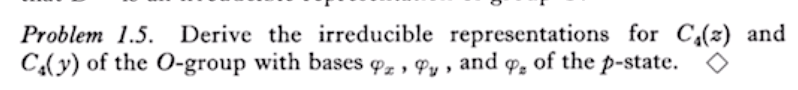

In [1948]:
from sympy import pi
from sympy import Rational, Matrix

In [1949]:
group_ops = {
  'C_{4z}': (pi/2, xyz.k),
  'C_{4y}': (pi/2, xyz.j)
  }
group_ops = {'E': (0,xyz.k),
  'C_{4z}': (pi/2, xyz.k),
  'C_{4z}^2': (pi, xyz.k),
  'C_{4z}^3': (3*pi/2, xyz.k),
  'C_{4x}': (pi/2, xyz.i),
  'C_{4x}^2': (pi, xyz.i),
  'C_{4x}^3': (3*pi/2, xyz.i),
  'C_{4y}': (pi/2, xyz.j),
  'C_{4y}^2': (pi, xyz.j),
  'C_{4y}^3': (3*pi/2, xyz.j),
  'C_{3xyz}': (2*pi/3, xyz.i + xyz.j + xyz.k),
  'C_{3xyz}^2': (4*pi/3, xyz.i + xyz.j + xyz.k),
  'C_{3-xyz}': (2*pi/3, -xyz.i + xyz.j + xyz.k),
  'C_{3-xyz}^2': (4*pi/3, -xyz.i + xyz.j + xyz.k),
  'C_{3x-yz}': (2*pi/3, xyz.i - xyz.j + xyz.k),
  'C_{3x-yz}^2': (4*pi/3, xyz.i - xyz.j + xyz.k),
  'C_{3xy-z}': (2*pi/3, xyz.i + xyz.j - xyz.k),
  'C_{3xy-z}^2': (4*pi/3, xyz.i + xyz.j - xyz.k),
  'C_{2xy}' : (pi, xyz.i + xyz.j),
  'C_{2-xy}' : (pi, -xyz.i + xyz.j),
  'C_{2yz}' : (pi, xyz.j + xyz.k),
  'C_{2-yz}' : (pi, -xyz.j + xyz.k),
  'C_{2zx}' : (pi, xyz.i + xyz.k),
  'C_{2-zx}' : (pi, xyz.i - xyz.k)
  }
print(len(group_ops))

24


In [1950]:
YC1m = {}
YC1m[-1] = Rational(1,2)*sqrt(Rational(3,2))/sqrt(pi)*(x-I*y)/r
YC1m[0]  = Rational(1,2)*sqrt(3/pi) * z/r
YC1m[1]  = -Rational(1,2)*sqrt(Rational(3,2))/sqrt(pi)*(x+I*y)/r
YS1mC = {}
for m in YC1m:
  Ycon = YC1m[m].subs(I,-I)
  YS1mC[m] = Ycon.subs([(r,1),(x, sin(theta)*cos(phi)),(y, sin(theta)*sin(phi)),(z, cos(theta))], simultaneous=True)

In [1951]:
basis = {'\phi_x': simplify(1/sqrt(2) * (YC1m[-1]-YC1m[1])),
        '\phi_y': simplify(I/sqrt(2) * (YC1m[-1]+YC1m[1])),
        '\phi_z': YC1m[0]}

In [1952]:
basis

{'\\phi_x': sqrt(3)*x/(2*sqrt(pi)*r),
 '\\phi_y': sqrt(3)*y/(2*sqrt(pi)*r),
 '\\phi_z': sqrt(3)*z/(2*sqrt(pi)*r)}

In [1953]:
def compute_vec(submarine):
  found = []
  for expr in submarine:
    for idx, searching in enumerate([x,y,z]):
      # print(idx)
      if searching in expr.free_symbols:
        break
    ah = expr.subs([(x,1),(y,1),(z,1)])
    found.append([[ah,0,0],
                  [0,ah,0],
                  [0,0,ah]][idx])
  return list(zip(*found))

In [1954]:
compute_vec([y,-x,z])

[(0, -1, 0), (1, 0, 0), (0, 0, 1)]

In [1955]:
def compute_matrix(group_op):
  full_matrix = []
  subs = (rot_matrix(group_ops[group_op]).inv().dot([x,y,z])) # this determined the coord transform
  return group_op,subs,compute_vec(subs)

In [1961]:
rep = Parallel(n_jobs = num_cores)(delayed(compute_matrix)(grp) for grp in group_ops)

In [1962]:
rep = {k[0]: (k[1],Matrix(k[-1])) for k in rep}

In [1963]:
interact(lambda idx: display(Math(idx+'\\\\'+latex(rep[idx][1])+'\\\\'+latex(Matrix(rep[idx][0])))), idx = rep.keys());

interactive(children=(Dropdown(description='idx', options=('E', 'C_{4z}', 'C_{4z}^2', 'C_{4z}^3', 'C_{4x}', 'C…

In [160]:
for idx in rep.keys():
  display(Math(idx+'\\\\'+latex(rep[idx][1])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [384]:
class_exemplars = {
  'E': 'E',
  '8C3': 'C_{3xyz}',
  '6C2': 'C_{2xy}',
  '6C4': 'C_{4z}',
  '3C2': 'C_{4z}^2'
}

In [388]:
# this identifies this representation as an irreducible one!
print({k: rep[class_exemplars[k]][1].trace() for k in class_exemplars})

{'E': 3, '8C3': 0, '6C2': -1, '6C4': 1, '3C2': -1}


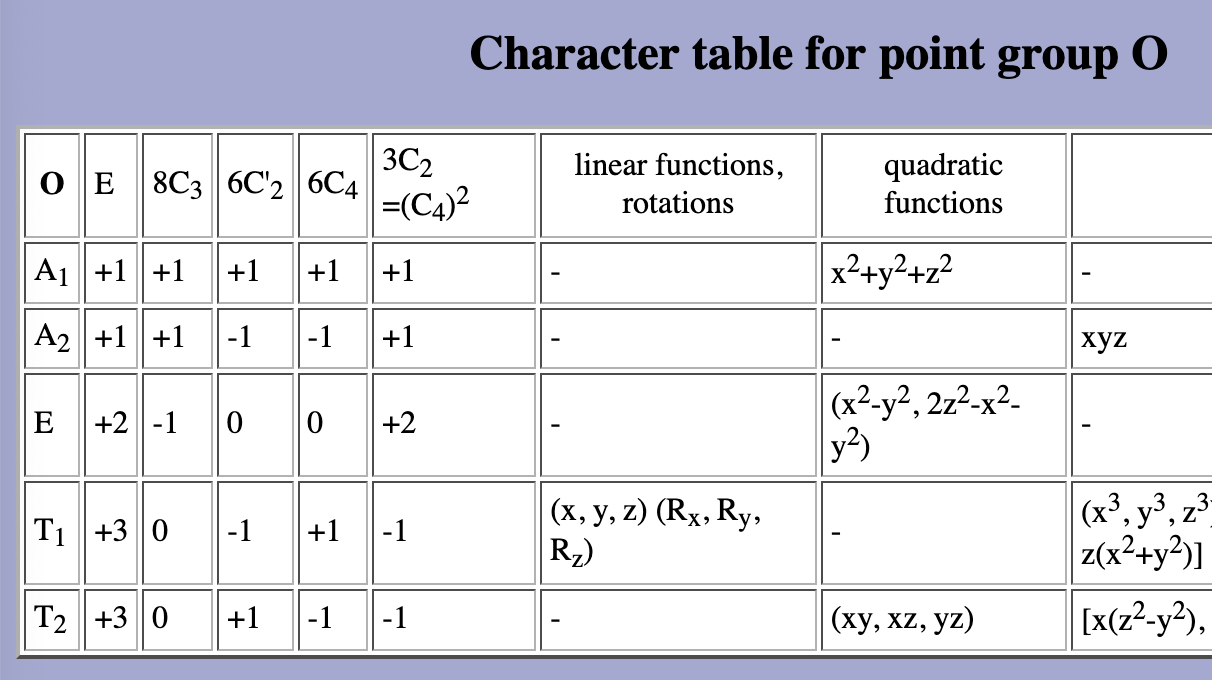

### Problem 1.6

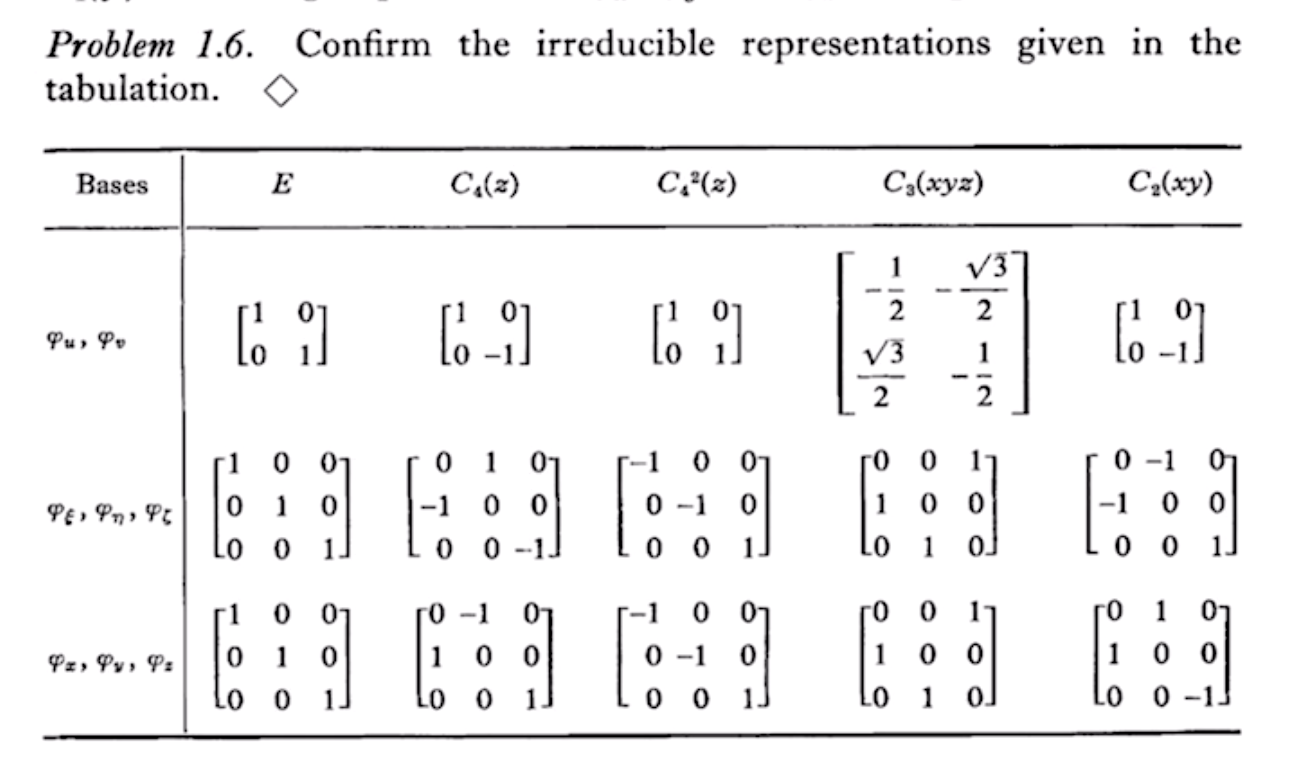

In [541]:
from sympy import solve
from collections import OrderedDict

In [552]:
r2 = x**2 + y**2 + z**2
basis_1 = {'\phi_u': (3*z**2 - r2), 
        '\phi_v': sqrt(3)*(x**2 - y**2)}
basis_2= {r'\phi_\xi': y*z,
          r'\phi_\eta': z*x,
          r'\phi_\zeta': x*y}
basis_1 = OrderedDict([
  ('\phi_u',(3*z**2 - r2)), 
  ('\phi_v', sqrt(3)*(x**2 - y**2))])
basis_2= OrderedDict([
  (r'\phi_\xi', y*z),
  (r'\phi_\eta', z*x),
  (r'\phi_\zeta', x*y)])
basis_3 = OrderedDict([
  (r'\phi_x', x),
  (r'\phi_y', y),
  (r'\phi_z', z),
])

In [554]:
a, b, c = symbols("a b c")
var_list = [a,b,c]
all_reps = []
for basis in [basis_1, basis_2, basis_3]:
  rep = {}
  for group_op in ['E','C_{4z}','C_{4z}^2','C_{3xyz}','C_{2xy}']:
    rows = []
    op_subs = list(zip([x,y,z],compute_matrix(group_op)[1]))
    maps_to = {}
    for basis_vector_label, basis_vector in basis.items():
      row = []
      mapped_to = basis_vector.subs(op_subs, simultaneous=True)
      expr0 = 0
      solve_vars = []
      for idx, basis_vector in enumerate(basis):
        expr0 += var_list[idx]*basis[basis_vector]
        solve_vars.append(var_list[idx])
      expr0 = expr0 - mapped_to
      randos = np.random.randint(1,100,(len(solve_vars),3))
      exprs = []
      for solve_var, rands in zip(solve_vars,randos):
        exprs.append(expr0.subs([(x,rands[0]),(y,rands[1]),(z,rands[2])], simultaneous=True))
      sol = solve(exprs,solve_vars)
      for solve_var in solve_vars:
        row.append(solve_var.subs(sol, simultaneous=True))
      rows.append(row)
      maps_to[basis_vector_label] = mapped_to
    rep[group_op] = Matrix(list(zip(*rows)))
  full_matrix = Matrix()
  for group_op in rep:
    full_matrix = full_matrix.row_join(rep[group_op])
  display(full_matrix)
  all_reps.append(rep)

Matrix([
[1, 0, 1,  0, 1, 0,      -1/2, -sqrt(3)/2, 1,  0],
[0, 1, 0, -1, 0, 1, sqrt(3)/2,       -1/2, 0, -1]])

Matrix([
[1, 0, 0,  0, 1,  0, -1,  0, 0, 0, 0, 1,  0, -1, 0],
[0, 1, 0, -1, 0,  0,  0, -1, 0, 1, 0, 0, -1,  0, 0],
[0, 0, 1,  0, 0, -1,  0,  0, 1, 0, 1, 0,  0,  0, 1]])

Matrix([
[1, 0, 0, 0, -1, 0, -1,  0, 0, 0, 0, 1, 0, 1,  0],
[0, 1, 0, 1,  0, 0,  0, -1, 0, 1, 0, 0, 1, 0,  0],
[0, 0, 1, 0,  0, 1,  0,  0, 1, 0, 1, 0, 0, 0, -1]])

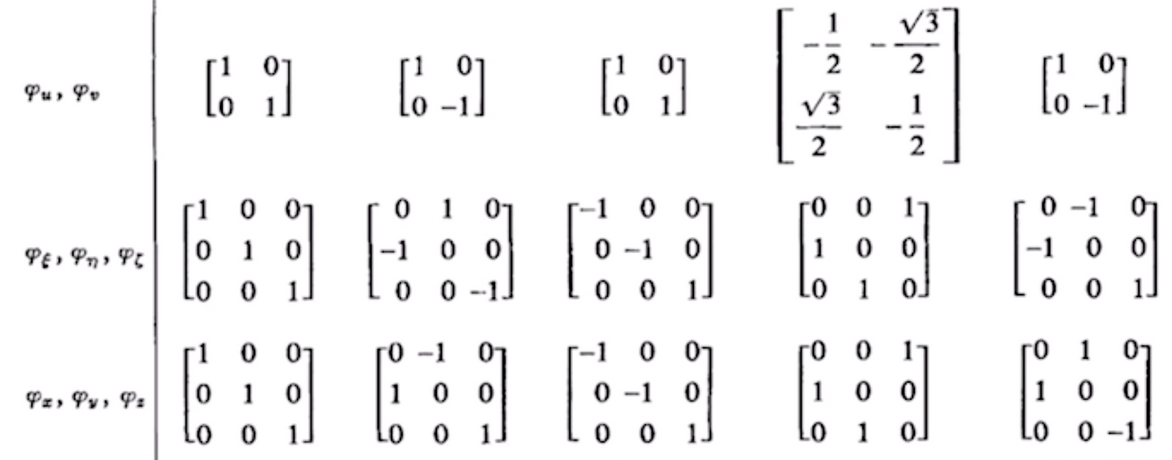

### Problem 1.7

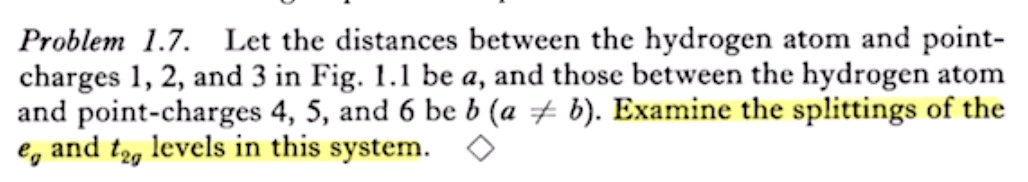

In [703]:
from sympy import conjugate, sympify, pi
from sympy.functions.special.spherical_harmonics import Ynm
from sympy.physics.quantum.cg import CG
@classmethod
def new_eval(cls, n, m, theta, phi):
    n, m, theta, phi = [sympify(x) for x in (n, m, theta, phi)]
    # Handle negative index m and arguments theta, phi
    #if m.could_extract_minus_sign():
    #    m = -m
    #    return S.NegativeOne**m * exp(-2*I*m*phi) * Ynm(n, m, theta, phi)
    if theta.could_extract_minus_sign():
        theta = -theta
        return Ynm(n, m, theta, phi)
    if phi.could_extract_minus_sign():
        phi = -phi
        return exp(-2*I*m*phi) * Ynm(n, m, theta, phi)
Ynm.eval = new_eval

In [704]:
def from_expression_to_ket(superposition):
  superposition = superposition.expand()
  summands_and_multipliers =  superposition.as_coefficients_dict()
  chunks = []
  for k in summands_and_multipliers.keys():
    factors = k.as_ordered_factors()
    phase = summands_and_multipliers[k]
    for factor in factors:
      if isinstance(factor,Ynm):
        harmonic = factor.args[:2]
      else:
        phase = phase*factor
    chunks.append((phase, harmonic))
  total_chunks = {}
  for chunk in chunks:
    if chunk[1] not in total_chunks.keys():
      total_chunks[chunk[1]] = 0
    total_chunks[chunk[1]] += chunk[0] 
  return total_chunks

In [776]:
def rational_approx(x, N):
    '''
    x is the number to approximate
    N is the largest allowed denominator
    '''
    whole_part = int(x)
    x = x-whole_part
    a, b = 0, 1
    c, d = 1, 1
    while (b <= N and d <= N):
        mediant = float(a+c)/(b+d)
        if x == mediant:
            if b + d <= N:
                return a+c, b+d
            elif d > b:
                return c * whole_part*d, d
            else:
                return a * whole_part*d, b
        elif x > mediant:
            a, b = a+c, b+d
        else:
            c, d = a+c, b+d

    if (b > N):
        return c + d*whole_part, d
    else:
        return a + b*whole_part, b

In [705]:
def threeHarmonicIntegrate(l1, m1, l2, m2, l3, m3):
  tri = sqrt(Rational((2*l2+1)*(2*l3+1),(2*l1+1)))/sqrt(4*pi)*CG(l2,0,l3,0,l1,0)*CG(l2,m2,l3,m3,l1,m1)
  return tri
def threeHarmonicbraket(l1,m1,pot,l2,m2):
  pot = from_expression_to_ket(pot)
  parts = []
  for k, v in pot.items():
    integral = v*threeHarmonicIntegrate(l1,m1,*k,l2,m2)
    parts.append(integral)
  return sum(parts)

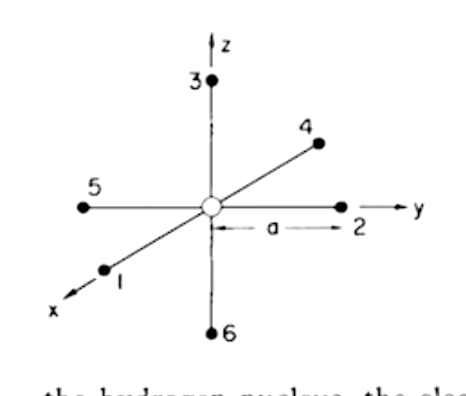
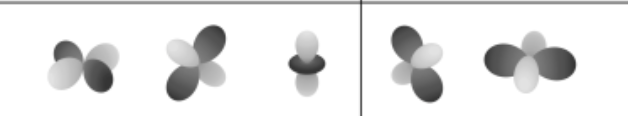

In [770]:
a, b, e = symbols("a b e")
cubic_angles = [[pi/2,0],[pi/2,pi/2],[pi/2,pi],
                [pi/2,3*pi/2],[0,0],[pi,0]]
cubic_distances = [a, a, b, b, b, a]
def q(k,m):
  summands = [conjugate(Ynm(k,m,t[0],t[1]).expand(func=True))/d**(k+1) for t,d in zip(cubic_angles,cubic_distances)]
  return sqrt(np.pi) * sqrt(Rational(4, 2*k+1)) * e * sum(summands)
def C(k,m):
  return sqrt(np.pi) * sqrt(Rational(4, 2*k+1)) * Ynm(k,m,theta,phi)
def VCF(kmax):
  vcf = 0
  for k in range(kmax+1):
    parts = [r**k * q(k,m) * C(k,m) for m in range(-k,k+1)]
    vcf += sum(parts)
  return vcf

In [779]:
order = 4
pointPotential = VCF(order).expand()
pointPotential = pointPotential.subs(Ynm(0,0,theta,phi),0)

In [781]:
l = 2
matrix = []
for m in range(-l,l+1):
  row = [((threeHarmonicbraket(l,m,pointPotential,l,mp)).doit()) for mp in range(-l,l+1)]
  matrix.append(row)

In [782]:
little_ham = Matrix(matrix)
little_ham=little_ham.subs(e,1)#.subs(r,1)

In [783]:
little_ham

Matrix([
[                             (3.66519142918809*r**4/(sqrt(pi)*b**5) + 3.66519142918809*r**4/(sqrt(pi)*a**5))/(14*sqrt(pi)),                                                                                               0,                                                                                              0,                                                                                               0, sqrt(70)*(0.261799387799149*sqrt(70)*r**4/(sqrt(pi)*b**5) + 0.261799387799149*sqrt(70)*r**4/(sqrt(pi)*a**5))/(14*sqrt(pi))],
[                                                                                                                         0, -2*(3.66519142918809*r**4/(sqrt(pi)*b**5) + 3.66519142918809*r**4/(sqrt(pi)*a**5))/(7*sqrt(pi)),                                                                                              0,                                                                                               0,                                     

In [794]:
N(little_ham,4)

Matrix([
[0.08333*r**4/b**5 + 0.08333*r**4/a**5,                                    0,                             0,                                    0,   0.4167*r**4/b**5 + 0.4167*r**4/a**5],
[                                    0, -0.3333*r**4/b**5 - 0.3333*r**4/a**5,                             0,                                    0,                                     0],
[                                    0,                                    0, 0.5*r**4/b**5 + 0.5*r**4/a**5,                                    0,                                     0],
[                                    0,                                    0,                             0, -0.3333*r**4/b**5 - 0.3333*r**4/a**5,                                     0],
[  0.4167*r**4/b**5 + 0.4167*r**4/a**5,                                    0,                             0,                                    0, 0.08333*r**4/b**5 + 0.08333*r**4/a**5]])

In [785]:
d = symbols("d")
eigentrue = Matrix([
  [a,0,0,0,b],
  [0,c,0,0,0],
  [0,0,d,0,0],
  [0,0,0,c,0],
  [b,0,0,0,a]
]).eigenvals()
subs = [(a,r**4*Rational(1,12)*(1/b**5+1/a**5)),
        (c,-Rational(1,3)*r**4*(1/b**5+1/a**5)),
       (d,Rational(1,2)*r**4*(1/b**5+1/a**5)),
       (b,Rational(5,12)*r**4*(1/b**5+1/a**5))]
for eigenval in eigentrue:
  print("multiplicity: %d" % eigentrue[eigenval])
  display(simplify(eigenval.subs(subs, simultaneous=True)))

multiplicity: 1


-r**4/(3*b**5) - r**4/(3*a**5)

multiplicity: 1


r**4/(2*b**5) + r**4/(2*a**5)

multiplicity: 2


-r**4/(3*b**5) - r**4/(3*a**5)

multiplicity: 1


r**4/(2*b**5) + r**4/(2*a**5)

In [787]:
eigentruesys = Matrix([
  [a,0,0,0,b],
  [0,c,0,0,0],
  [0,0,d,0,0],
  [0,0,0,c,0],
  [b,0,0,0,a]
]).eigenvects()

In [807]:
# multiplicity in the first row,
# eigenvalue in the second row,
# eigenvector in the remaning ones
Matrix([[_[1],_[0]]+list(_[2][0]) for _ in eigentruesys]).T

Matrix([
[2, 1,     1,     1],
[c, d, a - b, a + b],
[0, 0,    -1,     1],
[1, 0,     0,     0],
[0, 1,     0,     0],
[0, 0,     0,     0],
[0, 0,     1,     1]])

There are two splittings that occur one with double- and the other with triple- degeneracy. Comparing this against the case where all the distances are the same, the only difference seems to be in making the change

$\frac{1}{a^5} \rightarrow \frac{1}{2}*\left(\frac{1}{a^5}+\frac{1}{b^5}\right)$

With the eigenvectors exaclty the same as before.

This is alright, but the actual challenge here is to compare this against the results that would come form symmetry considerations alone.

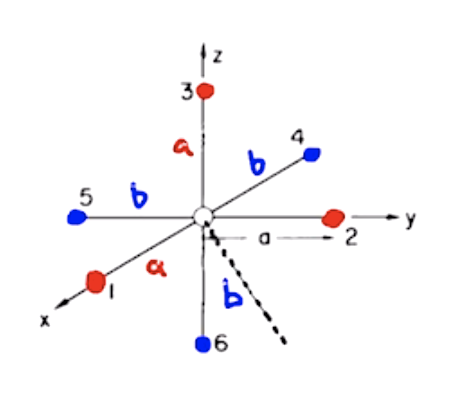

This conformational change removes most of the symmetry operations. The only ones remaining are: $E, C_{3xyz} \textrm{ and } C_{3xyz}^2$

## Chapter II: Two Electrons in a Cubic Field

### Problem 2.1
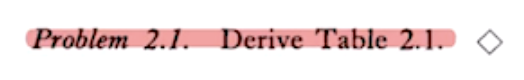

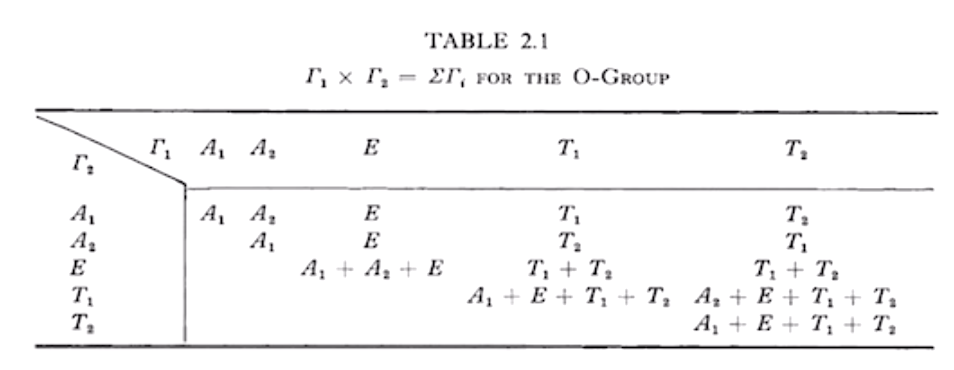

In [808]:
# import the data from the module that we already have

In [139]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from matplotlib import rc
import os, csv, sys
import sympy as sym
import matplotlib.colors as mcolors
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import HTML, display, Math, Latex
from sympy import latex

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
print('Num cores = %d' % num_cores)
import pickle, re, json
from sympy import Rational, Matrix

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Num cores = 20


In [131]:
from collections import OrderedDict

In [59]:
import sys
sys.path.append('/Users/juan/Google Drive/Zia Lab/Codebase/qdef')

In [60]:
from gtqdef import *

In [61]:
CPG = CPGroups()

/Users/juan/Google Drive/Zia Lab/Codebase/qdef/gtqdef.py:79: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(self.CharacterTable)[:,0].astype(int).tolist()


In [62]:
O = CPG.getGroupByLabel('O')

One ugly way of doing this is using the irreducible representations, finding the Kronecker products, finding the characters, and then figuring out how these split into the irreducible representation of the product group.

In [63]:
class thing():
  pass
O = thing()
O.irreps = OrderedDict()
O.irreps['E'] = OrderedDict(
  [('E', [[1,0],[0,1]]),
  ('C_{4z}', [[1,0],[0,-1]]),
  ('C_{4z}^2', [[1,0],[0,1]]),
  ('C_{3xyz}', [[-Rational(1,2), -sqrt(3)*Rational(1,2)],
              [sqrt(3)*Rational(1,2), -Rational(1,2)]]),
  ('C_{2xy}', [[1,0],[0,-1]])]
)
O.irreps['T1'] = OrderedDict(
  [('E', [[1,0,0],[0,1,0],[0,0,1]]),
  ('C_{4z}', [[0,1,0],[-1,0,0],[0,0,-1]]),
  ('C_{4z}^2', [[-1,0,0],[0,-1,0],[0,0,1]]),
  ('C_{3xyz}', [[0,0,1],[1,0,0],[0,1,0]]),
  ('C_{2xy}', [[0,-1,0],[-1,0,0],[0,0,1]])]
)
O.irreps['T2'] = OrderedDict(
  [('E', [[1,0,0],[0,1,0],[0,0,1]]),
  ('C_{4z}', [[0,-1,0],[1,0,0],[0,0,1]]),
  ('C_{4z}^2', [[-1,0,0],[0,-1,0],[0,0,1]]),
  ('C_{3xyz}', [[0,0,1],[1,0,0],[0,1,0]]),
  ('C_{2xy}', [[0,1,0],[1,0,0],[0,0,-1]])]
)
O.charTable = Matrix([[1,1,1,1,1],
              [1,-1,1,1,-1],
              [2,0,2,-1,0],
              [3,1,-1,0,-1],
              [3,-1,-1,0,1]])
for irrep in O.irreps:
  for op in O.irreps[irrep]:
    O.irreps[irrep][op] = Matrix(O.irreps[irrep][op])

In [64]:
# calculate the representation induced by the 
from sympy.physics.quantum import TensorProduct

In [65]:
productrep = OrderedDict()
g1 = 'T1'
g2 = 'T1'
for mat0 in O.irreps[g1]:
  for mat1 in O.irreps[g2]:
    productrep[(mat0,mat1)] = OrderedDict()
    productrep[(mat0,mat1)]['matrix'] = TensorProduct(O.irreps[g1][mat0],O.irreps[g2][mat1])
    productrep[(mat0,mat1)]['char'] = productrep[(mat0,mat1)]['matrix'].trace()
all_chars = []
class_sizes = {'E': 1,
               'C_{4z}': 6,
               'C_{4z}^2': 3,
               'C_{3xyz}': 8,
               'C_{2xy}': 6}
for mat0 in O.irreps[g1]:
  for mat1 in O.irreps[g2]:
    all_chars.append(productrep[(mat0,mat1)]['char'])
all_chars = Matrix(all_chars)


In [66]:
irreps = Matrix(['A_1','A_2','E','T_1','T_2'])

In [67]:
products = []
ichart = O.charTable.T**-1
for i in range(5):
  row = []
  for j in range(5):
    p = ((O.charTable.row(i).T*O.charTable.row(j))).diagonal()
    sol =  ichart * (p).T
    row.append(list(irreps.T*sol)[0])
  products.append(row)

In [68]:
Matrix(products)

Matrix([
[A_1, A_2,             E,                 T_1,                 T_2],
[A_2, A_1,             E,                 T_2,                 T_1],
[  E,   E, A_1 + A_2 + E,           T_1 + T_2,           T_1 + T_2],
[T_1, T_2,     T_1 + T_2, A_1 + T_1 + T_2 + E, A_2 + T_1 + T_2 + E],
[T_2, T_1,     T_1 + T_2, A_2 + T_1 + T_2 + E, A_1 + T_1 + T_2 + E]])

In [338]:
Matrix(products).row_insert(0, irreps.T).col_insert(0,Matrix([None]+list(irreps)))

Matrix([
[None, A_1, A_2,             E,                 T_1,                 T_2],
[ A_1, A_1, A_2,             E,                 T_1,                 T_2],
[ A_2, A_2, A_1,             E,                 T_2,                 T_1],
[   E,   E,   E, A_1 + A_2 + E,           T_1 + T_2,           T_1 + T_2],
[ T_1, T_1, T_2,     T_1 + T_2, A_1 + T_1 + T_2 + E, A_2 + T_1 + T_2 + E],
[ T_2, T_2, T_1,     T_1 + T_2, A_2 + T_1 + T_2 + E, A_1 + T_1 + T_2 + E]])

### CG coeff calculation example

In [53]:
from sympy.physics.quantum import Bra, Ket
from sympy import symbols, N

In [54]:
repMatrices = OrderedDict()
repMatrices['C_{4z}'] = Matrix([[1,0],[0,-1]])
repMatrices['C_{4x}'] = Matrix([[-Rational(1,2),-sqrt(3)*Rational(1,2)],
                               [-Rational(1,2)*sqrt(3),Rational(1,2)]])


In [58]:
for job in [(2,2),(-2,-2),(1,1),(-1,-1),(0,0),(2,-2),(-2,2)]:
  chunks = (N((threeHarmonicbraket(2,job[0],dipPotential,2,job[1])).doit()).as_coefficients_dict())
  for k,v in chunks.items():
    if r in k.free_symbols:
      break
  print(k,v)

NameError: name 'dipPotential' is not defined

In [72]:
eqns4z = []
E, u, v = symbols("E u v")
matr = repMatrices['C_{4z}']
for gamma_1 in [0,1]:
  for gamma_2 in [0,1]:
    for gamma_prime in [0,1]:
      rhs0 = Bra(([u,v][gamma_1],[u,v][gamma_2])) * Ket((u)) * matr[0,gamma_prime]
      rhs1 = Bra(([u,v][gamma_1],[u,v][gamma_2])) * Ket((v)) * matr[1,gamma_prime]
      lhs0 = matr[gamma_1,0]*matr[gamma_2,0] * (Bra((u,u)) * Ket(([u,v][gamma_prime])))
      lhs1 = matr[gamma_1,1]*matr[gamma_2,1] * (Bra((v,v)) * Ket(([u,v][gamma_prime])))
      lhs2 = matr[gamma_1,1]*matr[gamma_2,0] * (Bra((v,u)) * Ket(([u,v][gamma_prime])))
      lhs3 = matr[gamma_1,0]*matr[gamma_2,1] * (Bra((u,v)) * Ket(([u,v][gamma_prime])))
      eqn = simplify(lhs0+lhs1+lhs2+lhs3 - (rhs0+rhs1))
      if eqn != 0:
        eqns4z.append(eqn)

In [73]:
reps4z = list(solve((Matrix(eqns4z)),cgs).items())

In [74]:
eqns4x = []
E, u, v = symbols("E u v")
matr = repMatrices['C_{4x}']
for gamma_1 in [0,1]:
  for gamma_2 in [0,1]:
    for gamma_prime in [0,1]:
      rhs0 = Bra(([u,v][gamma_1],[u,v][gamma_2])) * Ket((u)) * matr[0,gamma_prime]
      rhs1 = Bra(([u,v][gamma_1],[u,v][gamma_2])) * Ket((v)) * matr[1,gamma_prime]
      lhs0 = matr[gamma_1,0]*matr[gamma_2,0] * (Bra((u,u)) * Ket(([u,v][gamma_prime])))
      lhs1 = matr[gamma_1,1]*matr[gamma_2,1] * (Bra((v,v)) * Ket(([u,v][gamma_prime])))
      lhs2 = matr[gamma_1,1]*matr[gamma_2,0] * (Bra((v,u)) * Ket(([u,v][gamma_prime])))
      lhs3 = matr[gamma_1,0]*matr[gamma_2,1] * (Bra((u,v)) * Ket(([u,v][gamma_prime])))
      eqn = simplify(lhs0+lhs1+lhs2+lhs3 - (rhs0+rhs1))
      if eqn != 0:
        eqns4x.append(eqn)

In [75]:
eqns = Matrix(eqns4x).subs(reps4z)
sol = solve(eqns,cgs)
reps4x = list(sol.items())

In [76]:
from sympy import simplify, solve

In [71]:
cgs = []
for p1 in [u,v]:
  for p2 in [u,v]:
    for p3 in [u,v]:
      cgs.append(Bra((p1,p2))*Ket(p3))

In [77]:
cgmatrices = {}
for kind in [u,v]:
  mat = []
  for k1 in [u,v]:
    row = [Bra((k1,k2))*Ket(kind).subs(reps4z) for k2 in [u,v]]
    mat.append(row)
  cgmatrices[kind] = Matrix(mat).subs(reps4x).subs(reps4z)

In [78]:
display(cgmatrices[u])
display(cgmatrices[v])

Matrix([
[-<(v, v)|u>,          0],
[          0, <(v, v)|u>]])

Matrix([
[         0, <(v, v)|u>],
[<(v, v)|u>,          0]])

### Problem 2.4
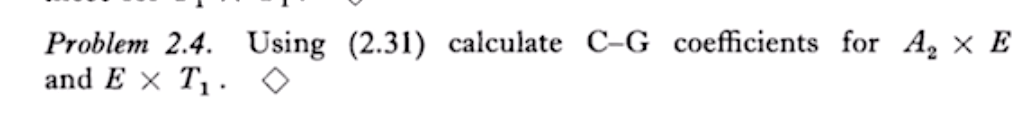

In [3]:
from sympy.vector import CoordSys3D
from sympy import BlockMatrix, solve, Matrix
from collections import OrderedDict
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import HTML, display, Math, Latex
from sympy import latex

In [4]:
def compute_vec(submarine):
  found = []
  for expr in submarine:
    for idx, searching in enumerate([x,y,z]):
      # print(idx)
      if searching in expr.free_symbols:
        break
    ah = expr.subs([(x,1),(y,1),(z,1)])
    found.append([[ah,0,0],
                  [0,ah,0],
                  [0,0,ah]][idx])
  return list(zip(*found))

In [5]:
def compute_matrix(group_op):
  full_matrix = []
  subs = (rot_matrix(group_ops[group_op]).inv().dot([x,y,z])) # this determined the coord transform
  return group_op,subs,compute_vec(subs)

In [6]:
def rot_matrix(rot_params):
  A = xyz.orient_new_axis('A', *rot_params)
  return xyz.rotation_matrix(A)

In [7]:
xyz = CoordSys3D('N')
theta, phi = symbols('theta phi')
x,y,z,r = symbols('x y z r')

In [8]:
group_ops = {
  'C_{4z}': (pi/2, xyz.k),
  'C_{4x}': (pi/2, xyz.i),
  }
# group_ops = {'E': (0,xyz.k),
#   'C_{4z}': (pi/2, xyz.k),
#   'C_{4z}^2': (pi, xyz.k),
#   'C_{4z}^3': (3*pi/2, xyz.k),
#   'C_{4x}': (pi/2, xyz.i),
#   'C_{4x}^2': (pi, xyz.i),
#   'C_{4x}^3': (3*pi/2, xyz.i),
#   'C_{4y}': (pi/2, xyz.j),
#   'C_{4y}^2': (pi, xyz.j),
#   'C_{4y}^3': (3*pi/2, xyz.j),
#   'C_{3xyz}': (2*pi/3, xyz.i + xyz.j + xyz.k),
#   'C_{3xyz}^2': (4*pi/3, xyz.i + xyz.j + xyz.k),
#   'C_{3-xyz}': (2*pi/3, -xyz.i + xyz.j + xyz.k),
#   'C_{3-xyz}^2': (4*pi/3, -xyz.i + xyz.j + xyz.k),
#   'C_{3x-yz}': (2*pi/3, xyz.i - xyz.j + xyz.k),
#   'C_{3x-yz}^2': (4*pi/3, xyz.i - xyz.j + xyz.k),
#   'C_{3xy-z}': (2*pi/3, xyz.i + xyz.j - xyz.k),
#   'C_{3xy-z}^2': (4*pi/3, xyz.i + xyz.j - xyz.k),
#   'C_{2xy}' : (pi, xyz.i + xyz.j),
#   'C_{2-xy}' : (pi, -xyz.i + xyz.j),
#   'C_{2yz}' : (pi, xyz.j + xyz.k),
#   'C_{2-yz}' : (pi, -xyz.j + xyz.k),
#   'C_{2zx}' : (pi, xyz.i + xyz.k),
#   'C_{2-zx}' : (pi, xyz.i - xyz.k)
#   }

In [9]:
x, y, z = symbols("x y z")
r2 = x**2 + y**2 + z**2
basis_1 = OrderedDict([
  ('\phi_u',(3*z**2 - r2)), 
  ('\phi_v', sqrt(3)*(x**2 - y**2))])
basis_2= OrderedDict([
  (r'\phi_\xi', y*z),
  (r'\phi_\eta', z*x),
  (r'\phi_\zeta', x*y)])
basis_3 = OrderedDict([
  (r'\phi_x', x),
  (r'\phi_y', y),
  (r'\phi_z', z),
])
basis_4 = OrderedDict([
  (r'e1', x**2+y**2+z**2)])
basis_5 = OrderedDict([
  (r'e2', x*y*z)])
bases = [basis_1, basis_2, basis_3, basis_4, basis_5]

In [10]:
a, b, c = symbols("a b c")
var_list = [a,b,c]
all_reps = {}
for basis, basis_name in zip(bases,['E','T2','T1','A1','A2']):
  print(basis)
  rep = {}
  for group_op in ['C_{4x}','C_{4z}']:
    rows = []
    op_subs = list(zip([x,y,z],compute_matrix(group_op)[1]))
    maps_to = {}
    for basis_vector_label, basis_vector in basis.items():
      row = []
      mapped_to = basis_vector.subs(op_subs, simultaneous=True)
      expr0 = 0
      solve_vars = []
      for idx, basis_vector in enumerate(basis):
        expr0 += var_list[idx]*basis[basis_vector]
        solve_vars.append(var_list[idx])
      expr0 = expr0 - mapped_to
      randos = np.random.randint(1,100,(len(solve_vars),3))
      exprs = []
      for solve_var, rands in zip(solve_vars,randos):
        exprs.append(expr0.subs([(x,rands[0]),(y,rands[1]),(z,rands[2])], simultaneous=True))
      sol = solve(exprs,solve_vars)
      for solve_var in solve_vars:
        row.append(solve_var.subs(sol, simultaneous=True))
      rows.append(row)
      maps_to[basis_vector_label] = mapped_to
    rep[group_op] = Matrix(list(zip(*rows)))
  full_matrix = Matrix()
  for group_op in rep:
    full_matrix = full_matrix.row_join(rep[group_op])
  #display(full_matrix)
  all_reps[basis_name] = (rep)

OrderedDict([('\\phi_u', -x**2 - y**2 + 2*z**2), ('\\phi_v', sqrt(3)*(x**2 - y**2))])


/Users/juan/opt/anaconda3/envs/qdef/lib/python3.7/site-packages/sympy/matrices/matrices.py:1357: SymPyDeprecationWarning: 

Dot product of non row/column vectors has been deprecated since SymPy
1.2. Use * to take matrix products instead. See
https://github.com/sympy/sympy/issues/13815 for more info.

  useinstead="* to take matrix products").warn()


OrderedDict([('\\phi_\\xi', y*z), ('\\phi_\\eta', x*z), ('\\phi_\\zeta', x*y)])
OrderedDict([('\\phi_x', x), ('\\phi_y', y), ('\\phi_z', z)])
OrderedDict([('e1', x**2 + y**2 + z**2)])
OrderedDict([('e2', x*y*z)])


In [11]:
from sympy.physics.quantum import Bra, Ket
from sympy import symbols

In [12]:
def cgeqn(D1, D2, D3, gamma1, gamma2, gammaprime, D1symbols, D2symbols, D3symbols):
  lhs = 0
  for gamma1prime in range((D1).shape[0]):
    for gamma2prime in range((D2).shape[0]):
      lhs = lhs + D1[gamma1,gamma1prime] * D2[gamma2,gamma2prime] * (Bra((D1symbols[gamma1prime], D2symbols[gamma2prime])) * Ket(D3symbols[gammaprime]))
  rhs = 0
  for gammaidx in range(D3.shape[0]):
    rhs += D3[gammaidx,gammaprime] * ( (Bra((D1symbols[gamma1], D2symbols[gamma2])) * Ket(D3symbols[gammaidx])) )
  return simplify(lhs - rhs)
def cgeqns(D1, D2, D3,D1symbols, D2symbols, D3symbols):
  eqns = []
  for gamma1 in range((D1).shape[0]):
    for gamma2 in range((D2).shape[0]):
      for gamma3 in range((D3).shape[0]):
        eqn = cgeqn(D1,D2,D3,gamma1,gamma2,gamma3,D1symbols, D2symbols, D3symbols)
        if eqn != 0:
          eqns.append(eqn)
  return eqns

In [13]:
# symbols_dictionary = {'E': [u,v],
#                      'T1': [alpha, beta, gamma], #[x, y, z],
#                      'T2': [xi, eta, zeta],
#                      'A1': [e1],
#                      'A2': [e2]}

In [14]:
xi, eta, zeta = symbols("xi eta zeta")
x, y, z = symbols("x y z")
u, v = symbols("u v")
e1, e2 = symbols("e1 e2")
alpha, beta, gamma = symbols("alpha beta gamma")
symbols_dictionary = {'E': [u, v],
                     'T1': [alpha, beta, gamma], #[x, y, z],
                     'T2': [xi, eta, zeta],
                     'A1': [e1],
                     'A2': [e2]}

In [1102]:
def CG_table(R1, R2, R3):
  alpha, beta, gamma = symbols("alpha beta gamma")
  x, y, z = symbols("x y z")
  u, v = symbols("u v")
  e1, e2 = symbols("e1 e2")
  xi, eta, zeta = symbols("xi eta zeta")
  D1symbols, D2symbols, D3symbols = [symbols_dictionary[R] for R in [R1,R2,R3]]
  cgs = []
  for p1 in D1symbols:
    for p2 in D2symbols:
      for p3 in D3symbols:
        cgs.append(Bra((p1,p2))*Ket(p3))
  if len(cgs) == 1:
    cgmatrices = {}
    for kind in D1symbols:
      mat = []
      for k2 in D2symbols:
        row = [Bra((kind,k2))*Ket(k3) for k3 in D3symbols]
        mat.append(row)
      cgmatrices[kind] = Matrix(mat)
    return cgmatrices
  ops = ['C_{4z}','C_{4x}']
  eqns = []
  for op in ops:
    D1, D2, D3 = all_reps[R1][op], all_reps[R2][op], all_reps[R3][op]
    eqns.extend(cgeqns(D1,
                D2,
                D3,
                D1symbols,
                D2symbols,
                D3symbols))
  eqns = list(set(eqns))
  cg_matrix = []
  for eqn in eqns:
    cg_matrix.append([eqn.coeff(cg) for cg in cgs])
  cg_matrix = Matrix(cg_matrix)
#   print(cgs,eqns,cg_matrix)
  rref = cg_matrix.rref()[0]
  better_subs = dict([(r,0) for r in rref*Matrix(cgs) if r!=0])
  better_eqns = [r for r in rref*Matrix(cgs) if r!=0]
  better_subs = solve(better_eqns,cgs)
  cgmatrices = {}
  for kind in D1symbols:
    mat = []
    for k2 in D2symbols:
      row = [Bra((kind,k2))*Ket(k3).subs(better_subs, simultaneous=True) for k3 in D3symbols]
      mat.append(row)
    cgmatrices[kind] = Matrix(mat).subs(better_subs, simultaneous=True)
  return cgmatrices # , cgs, cg_matrix, rref

In [1106]:
CG_table(*('T1','T1'),'A1')

{alpha: Matrix([
 [<(gamma, gamma)|e1>],
 [                  0],
 [                  0]]),
 beta: Matrix([
 [                  0],
 [<(gamma, gamma)|e1>],
 [                  0]]),
 gamma: Matrix([
 [                  0],
 [                  0],
 [<(gamma, gamma)|e1>]])}

In [1119]:
totals = '''a2 e e
a2 t1 t2
a2 t2 t1
e e a1 a2 e
e t1 t1 t2
e t2 t1 t2
t1 t1 a1 e t1 t2
t1 t2 a2 e t1 t2
t2 t2 a1 e t1 t2'''.upper()
totals = '''a1 a1 a1
a1 a2 a2
a1 e e
a1 t1 t1
a1 t2 t2
a2 a1 a2
a2 a2 a1
a2 e e
a2 t1 t2
a2 t2 t1
e a1 e
e a2 e
e e a1 a2 e
e t1 t1 t2
e t2 t1 t2
t1 a1 t1
t1 a2 t2
t1 e t1 t2
t1 t1 a1 t1 t2 e
t1 t2 a2 e t1 t2
t2 a1 t2
t2 a2 t1
t2 e t1 t2
t2 t1 a2 t1 t2 e
t2 t2 a1 e t1 t2'''.upper()
products = OrderedDict()
for line in totals.split('\n'):
  r1, r2, *targets = line.split()
  products[(r1,r2)] = targets

In [1120]:
results = OrderedDict()
for product in products:
  print(product)
  results[product] = OrderedDict()
  for target in products[product]:
    print(target)
    results[product][target] = CG_table(*product,target)

('A1', 'A1')
A1
('A1', 'A2')
A2
('A1', 'E')
E
('A1', 'T1')
T1
('A1', 'T2')
T2
('A2', 'A1')
A2
('A2', 'A2')
A1
('A2', 'E')
E
('A2', 'T1')
T2
('A2', 'T2')
T1
('E', 'A1')
E
('E', 'A2')
E
('E', 'E')
A1
A2
E
('E', 'T1')
T1
T2
('E', 'T2')
T1
T2
('T1', 'A1')
T1
('T1', 'A2')
T2
('T1', 'E')
T1
T2
('T1', 'T1')
A1
T1
T2
E
('T1', 'T2')
A2
E
T1
T2
('T2', 'A1')
T2
('T2', 'A2')
T1
('T2', 'E')
T1
T2
('T2', 'T1')
A2
T1
T2
E
('T2', 'T2')
A1
E
T1
T2


In [1121]:
big_tables = OrderedDict()
for product in products:
  big_table = Matrix()
  for target in results[product]:
    big_column = Matrix()
    for chunk in results[product][target]:
      partial_column = results[product][target][chunk]
      big_column = Matrix.vstack(big_column,partial_column)
    big_table = Matrix.hstack(big_table,big_column)
  big_tables[product] = big_table

In [1122]:
def nicey_print(product):
  h_symbols_0 = (symbols_dictionary[product[0]])
  h_symbols_1 = (symbols_dictionary[product[1]])
  produce = products[product]
  big_col_sizes = [len(symbols_dictionary[p]) for p in produce]
  big_col_symbols = []
  for p in produce:
    syms = [latex(s) for s in symbols_dictionary[p]]
    big_col_symbols.extend(syms)
  first_row = (' & '.join(big_col_symbols)) + '\\\\'
  first_row = '\\gamma_1 & \\gamma_2 \\setminus \\gamma  & ' + first_row
  big_row_sizes = [len(h_symbols_1)] * len(h_symbols_0)
  formatter = '|'.join(['c'*r for r in big_col_sizes])
  header = (' & '.join(['c'*r for r in big_col_sizes])) + ' \\\\ '
  header = ['', '%s \\times %s' % (latex(product[0]), latex(product[1]))]
  for idx, big_col_size in enumerate(big_col_sizes):
    rubrics = ['']*(big_col_size-1)
    rubrics = [latex(produce[idx])] + rubrics
    header.extend(rubrics)
  header = ' & '.join(header) + '\\\\ \hline'
  formatter = 'c|c|' + formatter
  h_cuts = list(range(len(h_symbols_1),len(h_symbols_1)*len(h_symbols_0),len(h_symbols_1)))
  coda = 'begin{array}{%s} %s & %s &' % (formatter, latex(h_symbols_0[0]), latex(h_symbols_1[0]))
  latte = latex(big_tables[product]).replace('matrix','array').replace('begin{array}',coda)
  buf = ''
  splits_at = h_cuts
  for idx, line in enumerate(latte.split('\\\\')):
    if idx > 0:
      if idx % len(h_symbols_1) == 0:
        
        midx = int((idx) // len(h_symbols_1)) + 1
        midx = (idx) // (len(h_symbols_1))
        try:
          line = '%s & %s & ' % (latex(h_symbols_0[midx]), latex(h_symbols_1[idx % len(h_symbols_1)])) + line
        except:
          line = '%s & %s & ' % ('err', latex(h_symbols_1[idx % len(h_symbols_1)])) + line
      else:
        line = ' & %s & ' % latex(h_symbols_1[idx % len(h_symbols_1)]) + line
    if idx in splits_at:
      buf =  buf + '\hline ' + line + '\\\\'   # + '\\\\' 
    else:
      buf = buf + line + '\\\\'
  coda2 = 'begin{array}{%s} magic %s \hline %s & %s &' % (formatter, first_row, latex(h_symbols_0[0]), latex(h_symbols_1[0]))
  buf = buf.replace(coda, coda2)
  buf = buf.replace('\\left[','').replace('\\right]','')
  chevrons = []
  big_col_idx = [0,big_col_sizes[0]]
  for thing in big_col_sizes[1:]:
    big_col_idx.append(big_col_idx[-1]+thing)
  for i in range(formatter.count('c')):
    if i in big_col_sizes:
      chevrons.append(str(i))
    else:
      chevrons.append(' ')
  buf = buf.replace('magic',header)
  display(Math(buf))

In [1123]:
interact(lambda x: nicey_print(x), x = [('%s X %s' % x, x) for x in list(products.keys())]);

interactive(children=(Dropdown(description='x', options=(('A1 X A1', ('A1', 'A1')), ('A1 X A2', ('A1', 'A2')),…

In [47]:
# v = symbols("v")

In [1124]:
# one_col = Matrix()
# sols = []
# for irr in products[('T1','T1')]:
#   norm_eqns = []
#   for colnum in range(len(symbols_dictionary[irr])):
#     one_col = Matrix()
#     for _, val in results[('T1','T1')][irr].items():
#       one_col = Matrix.vstack(one_col,val.col(colnum))

#     eqn = sum(one_col.applyfunc(lambda x: x**2)) - 1
#     norm_eqns.append(eqn)
#   norm_eqns = list(set(norm_eqns))
#   cgs = []
#   D1symbols, D2symbols, D3symbols = [symbols_dictionary[r] for r in ['T1','T1',irr]]
#   for p1 in D1symbols:
#     for p2 in D2symbols:
#       for p3 in D3symbols:
#         cgs.append(Bra((p1,p2))*Ket(p3))
#   for eqn in norm_eqns:
#     coeffs = ([eqn.coeff(cg**2) for cg in cgs])
#     free_vars = ([cg for idx, cg in enumerate(cgs) if coeffs[idx] != 0])
#   sol = solve(norm_eqns, free_vars)[0][0]
#   sols.append((free_vars[0],sol))

In [1125]:
one_col = Matrix()
all_sols = OrderedDict()
for product in products:
  sols = []
  for irr in products[product]:
    norm_eqns = []
    for colnum in range(len(symbols_dictionary[irr])):
      one_col = Matrix()
      for _, val in results[product][irr].items():
        one_col = Matrix.vstack(one_col,val.col(colnum))

      eqn = sum(one_col.applyfunc(lambda x: x**2)) - 1
      norm_eqns.append(eqn)
    norm_eqns = list(set(norm_eqns))
    cgs = []
    D1symbols, D2symbols, D3symbols = [symbols_dictionary[r] for r in [*product,irr]]
    for p1 in D1symbols:
      for p2 in D2symbols:
        for p3 in D3symbols:
          cgs.append(Bra((p1,p2))*Ket(p3))
    for eqn in norm_eqns:
      coeffs = ([eqn.coeff(cg**2) for cg in cgs])
      free_vars = ([cg for idx, cg in enumerate(cgs) if coeffs[idx] != 0])
    sol = solve(norm_eqns, free_vars)[1][0]
    sols.append((free_vars[0],sol))
  all_sols[product] = sols

In [1130]:
# import pickle
# pickle.dump(results,
#   open('/Users/juan/Google Drive/Zia Lab/Log/Data/O_table.pkl','wb'))

In [1114]:
for product in products:
  print(product)

('A1', 'A1')
('A1', 'A2')
('A1', 'E')
('A1', 'T1')
('A1', 'T2')
('A2', 'A1')
('A2', 'A2')
('A2', 'E')
('A2', 'T1')
('A2', 'T2')
('E', 'A1')
('E', 'A2')
('E', 'E')
('E', 'T1')
('E', 'T2')
('T1', 'A1')
('T1', 'A2')
('T1', 'E')
('T1', 'T1')
('T1', 'T2')
('T2', 'A1')
('T2', 'A2')
('T2', 'E')
('T2', 'T1')
('T2', 'T2')


In [1126]:
better_results = OrderedDict()

In [1127]:
for product in products:
  better_results[product] = OrderedDict()
  for resulting_irrep in results[product]:
    better_results[product][resulting_irrep] = OrderedDict()
    for chevron in results[product][resulting_irrep]:
      better_results[product][resulting_irrep][chevron] = results[product][resulting_irrep][chevron].subs(all_sols[product],simultaneous=True)

In [1134]:
pickle.dump({'products': products,'table':better_results},
  open('/Users/juan/Google Drive/Zia Lab/Log/Data/O_table.pkl','wb'))

In [1128]:
def nicey_print_2(product):
  h_symbols_0 = (symbols_dictionary[product[0]])
  h_symbols_1 = (symbols_dictionary[product[1]])
  produce = products[product]
  big_col_sizes = [len(symbols_dictionary[p]) for p in produce]
  big_col_symbols = []
  for p in produce:
    syms = [latex(s) for s in symbols_dictionary[p]]
    big_col_symbols.extend(syms)
  first_row = (' & '.join(big_col_symbols)) + '\\\\'
  first_row = '\\gamma_1 & \\gamma_2 \\setminus \\gamma  & ' + first_row
  big_row_sizes = [len(h_symbols_1)] * len(h_symbols_0)
  formatter = '|'.join(['c'*r for r in big_col_sizes])
  header = (' & '.join(['c'*r for r in big_col_sizes])) + ' \\\\ '
  header = ['', '%s \\times %s' % (latex(product[0]), latex(product[1]))]
  for idx, big_col_size in enumerate(big_col_sizes):
    rubrics = ['']*(big_col_size-1)
    rubrics = [latex(produce[idx])] + rubrics
    header.extend(rubrics)
  header = ' & '.join(header) + '\\\\ \hline'
  formatter = 'c|c|' + formatter
  h_cuts = list(range(len(h_symbols_1),len(h_symbols_1)*len(h_symbols_0),len(h_symbols_1)))
  coda = 'begin{array}{%s} %s & %s &' % (formatter, latex(h_symbols_0[0]), latex(h_symbols_1[0]))
  latte = latex(big_tables[product].subs(all_sols[product])).replace('matrix','array').replace('begin{array}',coda)
  buf = ''
  splits_at = h_cuts
  for idx, line in enumerate(latte.split('\\\\')):
    if idx > 0:
      if idx % len(h_symbols_1) == 0:
        
        midx = int((idx) // len(h_symbols_1)) + 1
        midx = (idx) // (len(h_symbols_1))
        try:
          line = '%s & %s & ' % (latex(h_symbols_0[midx]), latex(h_symbols_1[idx % len(h_symbols_1)])) + line
        except:
          line = '%s & %s & ' % ('err', latex(h_symbols_1[idx % len(h_symbols_1)])) + line
      else:
        line = ' & %s & ' % latex(h_symbols_1[idx % len(h_symbols_1)]) + line
    if idx in splits_at:
      buf =  buf + '\hline ' + line + '\\\\'   # + '\\\\' 
    else:
      buf = buf + line + '\\\\'
  coda2 = 'begin{array}{%s} magic %s \hline %s & %s &' % (formatter, first_row, latex(h_symbols_0[0]), latex(h_symbols_1[0]))
  buf = buf.replace(coda, coda2)
  buf = buf.replace('\\left[','').replace('\\right]','')
  chevrons = []
  big_col_idx = [0,big_col_sizes[0]]
  for thing in big_col_sizes[1:]:
    big_col_idx.append(big_col_idx[-1]+thing)
  for i in range(formatter.count('c')):
    if i in big_col_sizes:
      chevrons.append(str(i))
    else:
      chevrons.append(' ')
  buf = buf.replace('magic',header)
  display(Math(buf))

In [1129]:
interact(lambda x: nicey_print_2(x), x = [('%s X %s' % x, x) for x in list(products.keys())]);

interactive(children=(Dropdown(description='x', options=(('A1 X A1', ('A1', 'A1')), ('A1 X A2', ('A1', 'A2')),…

In [ ]:
!say 

### Problem 2.5

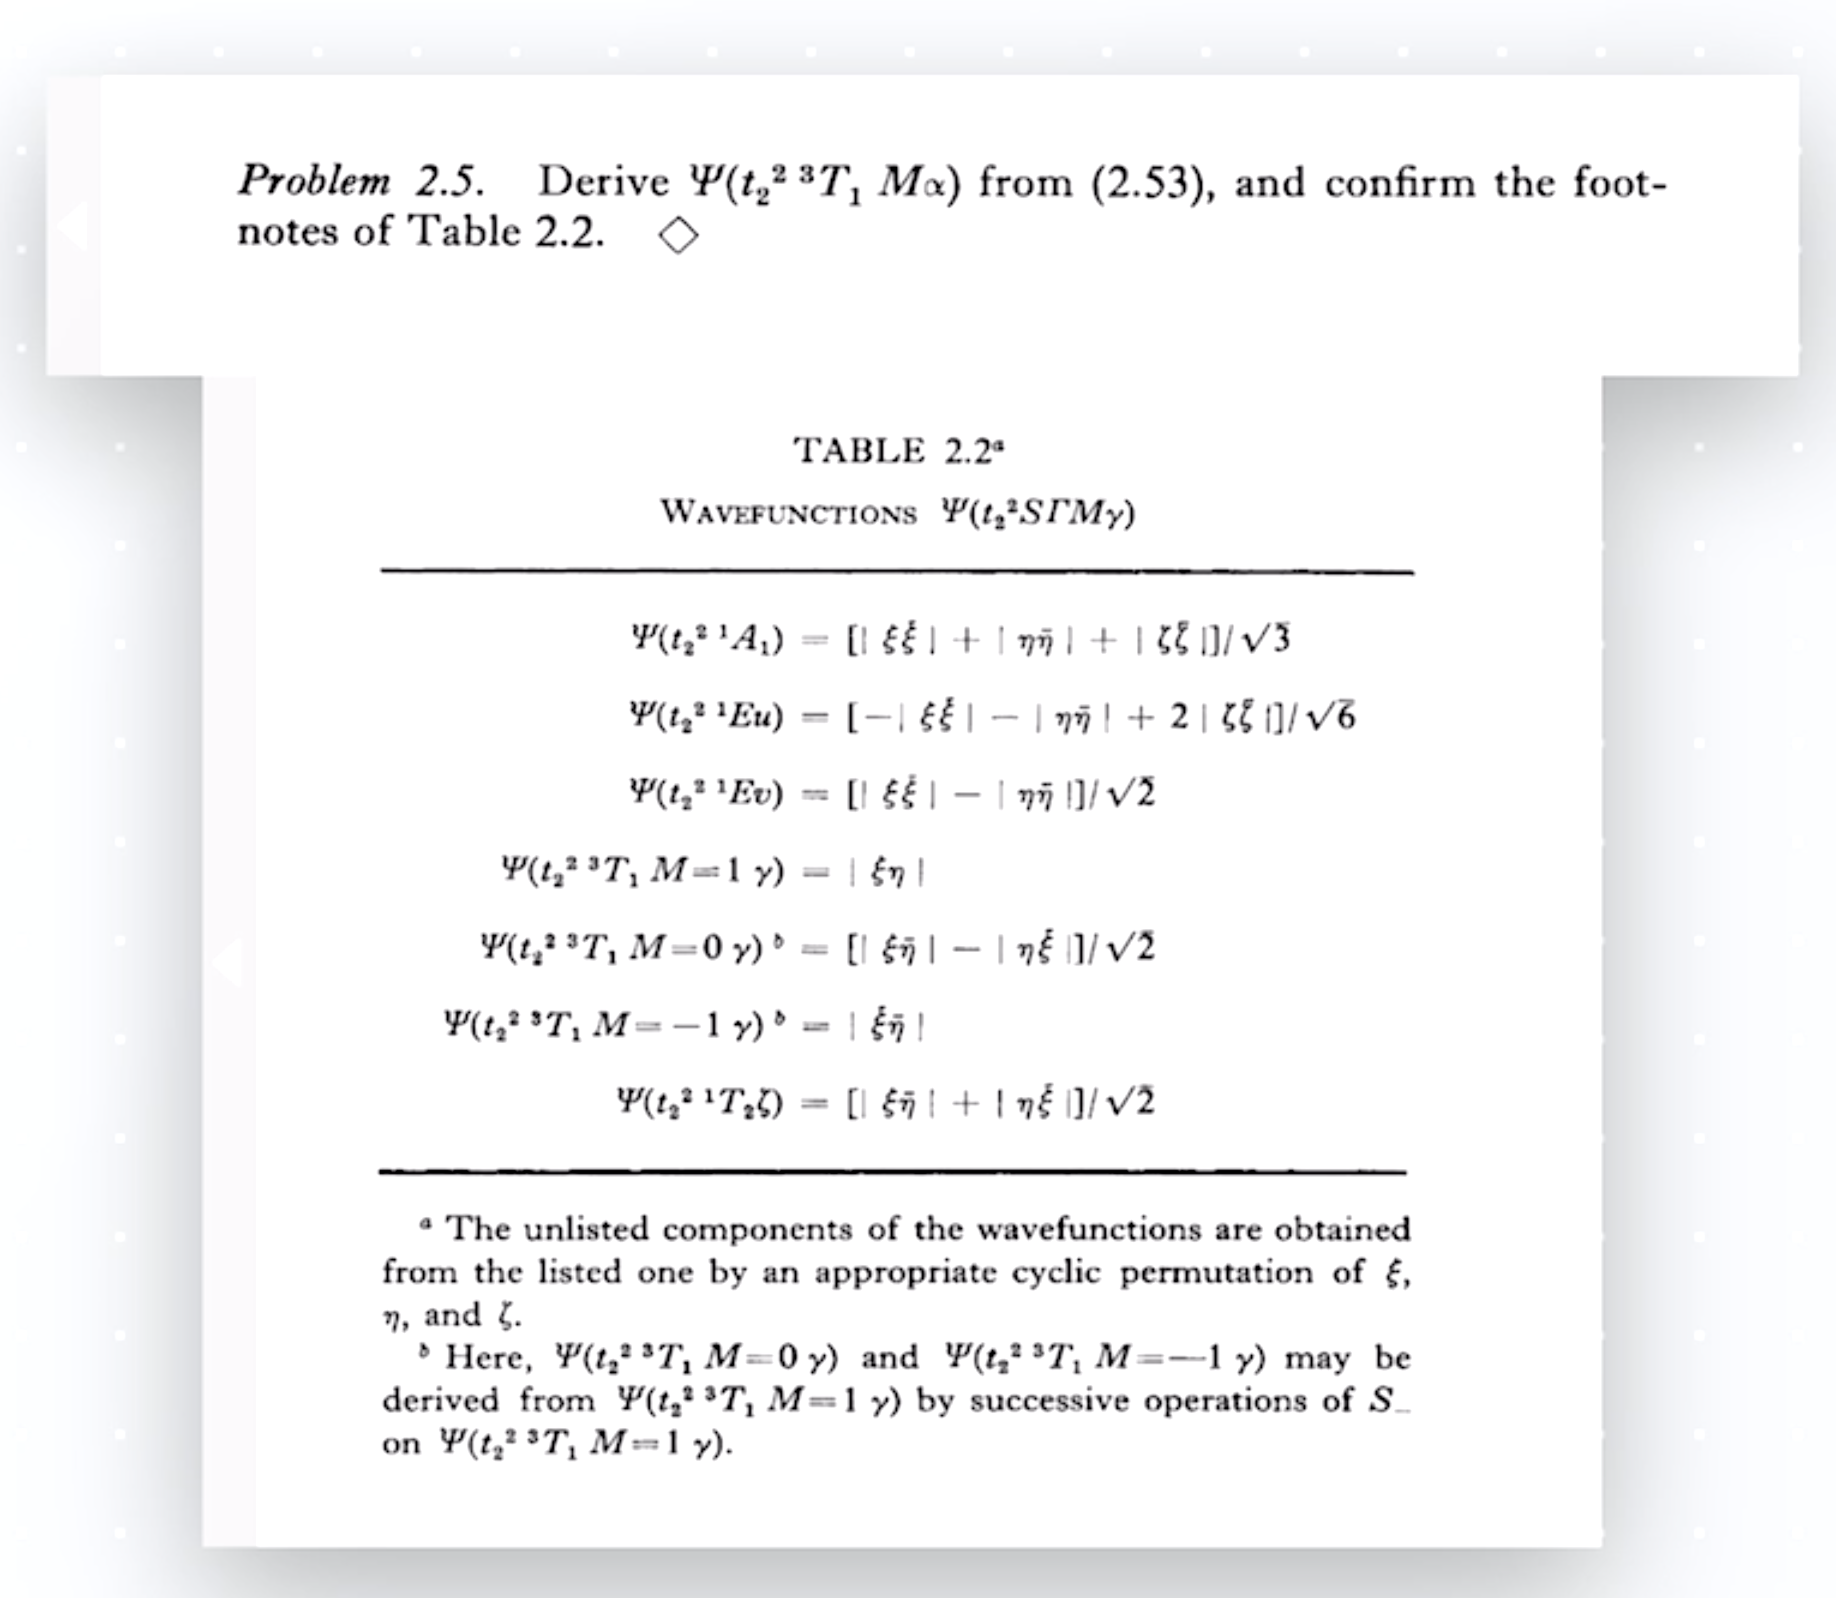

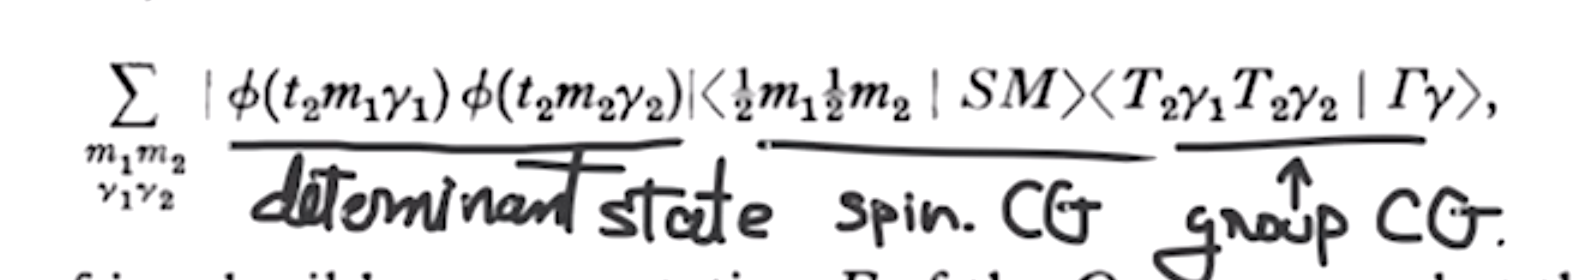

In [1147]:
from sympy import Sum, S
from sympy.physics.wigner import clebsch_gordan as ClebschG
from itertools import product
import pickle

In [550]:
# ClebschGordan quick reminder
# addition of angular momenta
s1 = S(1)/S(2)
s2 = S(1)/S(2)
m1s = [i - s1 for i in range(2*s1+1)]
m2s = [i - s2 for i in range(2*s2+1)]
s3s = []
s3_sum = abs(s1-s2)
while s3_sum <= s1+s2:
  s3s.append(s3_sum)
  s3_sum += S(1)
added = {}
for s3 in s3s:
  # for a given total angular momentum
  # compute the possible values for s3_z
  s3zs = [i-s_sum for i in range(2*s3+1)]
  # for each of those values calculate the total angular 
  # momentum state using products of the origin angular momenta
  m3s = [(i - s3) for i in range(2*s3+1)]
  for m3 in m3s:
    total_ket = Ket((s3,m3))
    added[total_ket] = sum([ClebschG(s1,s2,s3,m1,m2,m3)*Ket((s1,m1,s2,m2)) for m1, m2 in product(m1s,m2s)])

In [551]:
for k, v in added.items():
  display(Math(latex(k)+"="+latex(v)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

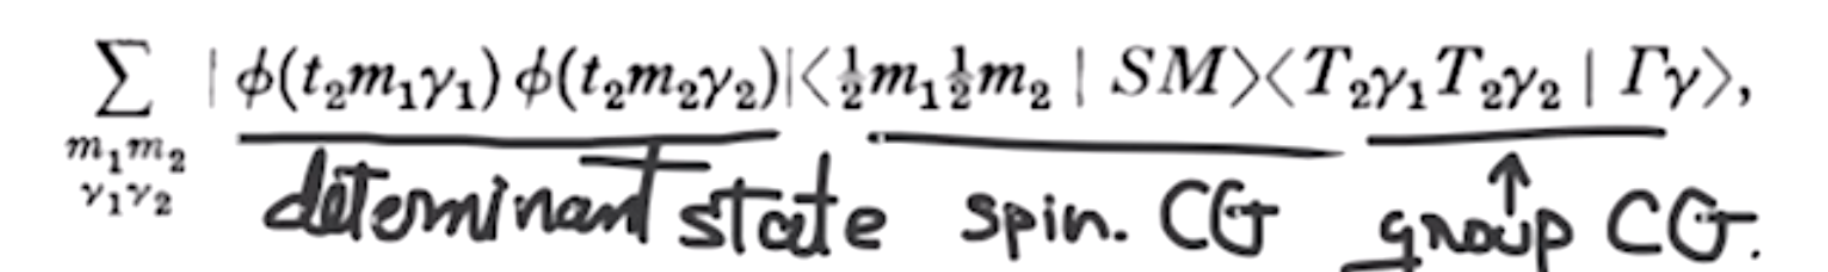

In [616]:
alpha = symbols("alpha")
s1 = S(1)/S(2)
s2 = S(1)/S(2)
m1s = [i - s1 for i in range(2*s1+1)]
m2s = [i - s2 for i in range(2*s2+1)]

In [617]:
T2T2T1 = {}

T2T2T1[(xi,xi,alpha)] = 0
T2T2T1[(xi,xi,beta)] = 0
T2T2T1[(xi,xi,gamma)] = 0

T2T2T1[(xi,eta,alpha)] = 0
T2T2T1[(xi,eta,beta)] = 0
T2T2T1[(xi,eta,gamma)] = -sqrt(2)/2

T2T2T1[(xi,zeta,alpha)] = 0
T2T2T1[(xi,zeta,beta)] = sqrt(2)/2
T2T2T1[(xi,zeta,gamma)] = 0

T2T2T1[(eta,xi,alpha)] = 0
T2T2T1[(eta,xi,beta)] = 0
T2T2T1[(eta,xi,gamma)] = sqrt(2)/2

T2T2T1[(eta,eta,alpha)] = 0
T2T2T1[(eta,eta,beta)] = 0
T2T2T1[(eta,eta,gamma)] = 0

T2T2T1[(eta,zeta,alpha)] = -sqrt(2)/2
T2T2T1[(eta,zeta,beta)] = 0
T2T2T1[(eta,zeta,gamma)] = 0

T2T2T1[(zeta,xi,alpha)] = 0
T2T2T1[(zeta,xi,beta)] = -sqrt(2)/2
T2T2T1[(zeta,xi,gamma)] = 0

T2T2T1[(zeta,eta,alpha)] = sqrt(2)/2
T2T2T1[(zeta,eta,beta)] = 0
T2T2T1[(zeta,eta,gamma)] = 0

T2T2T1[(zeta,zeta,alpha)] = 0
T2T2T1[(zeta,zeta,beta)] = 0
T2T2T1[(zeta,zeta,gamma)] = 0

In [618]:
# one_s3 = 1
# one_gamma = gamma
# product_state = sum([ClebschG(s1,s2,1,S(m1)/2,S(m2)/2,one_s3) * T2T2T1[(gamma1,gamma2,one_gamma)] * Ket((S(m1)/2,gamma1,S(m2)/2,gamma2))
#  for m1,m2,gamma1,gamma2 
#  in product((-1,1),(-1,1),[xi, eta, zeta],[xi, eta, zeta])])
# display(Math('%s' % latex(product_state)))
# simple_ket = 0
# for ket, coeff in product_state.as_coefficients_dict().items():
#   ket_args = (ket.args)[0]
#   print(ket)
#   if ket_args[-1] == xi:
#     coeff = coeff*-1
#     ket_args = ket_args[-2:] + ket_args[:2]
#     simple_ket += coeff*Ket((ket_args[0],ket_args[1],ket_args[2],ket_args[3]))
#   else:
#     simple_ket += coeff*Ket((ket_args[0],ket_args[1],ket_args[2],ket_args[3]))
# display(Math('%s' % latex(simple_ket)))

In [622]:
from sympy.physics.quantum.state import KetBase, State, BraBase
class DetKetBase(KetBase):
  rbracket_latex = r'\right| \rangle '
class DetKet(State, DetKetBase):
  pass
class DetBraBase(BraBase):
  lbracket_latex = r'\left\langle| '
class DetBra(State, DetBraBase):
  pass

In [623]:
for one_gamma in [alpha,beta,gamma]:
  resulting_irrep = '{}^3T_1'

  pivot = None
  all_kets = {}
  for one_s3 in [1,0,-1]:
    product_state = ([(ClebschG(s1,s2,1,S(m1)/2,S(m2)/2,one_s3) * T2T2T1[(gamma1,gamma2,one_gamma)] , Ket((S(m1)/2,gamma1,S(m2)/2,gamma2)))
     for m1,m2,gamma1,gamma2 
     in product((-1,1),(-1,1),[xi, eta, zeta],[xi, eta, zeta])])
    simple_ket = []
    coeff_list = []
    ket_dict = {}

    for coeff, ket in product_state:
      if coeff == 0:
        continue
      ket_args = (ket.args)[0]
      if pivot == None:
        pivot = ket_args[1]
      if ket_args[-1] == pivot:
        coeff = coeff*-1
        ket_args = ket_args[-2:] + ket_args[:2]
        new_ket = Ket((ket_args[0],ket_args[1],ket_args[2],ket_args[3]))
        if new_ket not in ket_dict.keys():
          ket_dict[new_ket] = 0
      else:
        new_ket = Ket((ket_args[0],ket_args[1],ket_args[2],ket_args[3]))
        if new_ket not in ket_dict.keys():
          ket_dict[new_ket] = 0
        simple_ket.append(coeff*new_ket)
      ket_dict[new_ket] += coeff
      ket_list.append(new_ket)
      coeff_list.append(coeff)
    coeffs_norm = Matrix(list(ket_dict.values())).norm()
    simple_ket = 0
    for ket, coeff in ket_dict.items():
      simple_ket += coeff*ket
    simple_ket = simple_ket/coeffs_norm
    for ket, coeff in ket_dict.items():
      ket_dict[ket] = coeff/coeffs_norm
    all_kets[one_s3] = ket_dict

  nice_kets = {}
  for one_s3, simple_ket in all_kets.items():
    nice_ket = S(0)
    neg_sign_counter = 0
    for ket, coeff in simple_ket.items():
      ket_args = ket.args[0]
      if sign(ket_args[0]) < 0:
        chevron_1 = r'\bar{%s}' % latex(ket_args[1])
      else:
        chevron_1 = latex(ket_args[1])
      if sign(ket_args[2]) < 0:
        chevron_2 = r'\bar{%s}' % latex(ket_args[3])
      else:
        chevron_2 = latex(ket_args[3])
      if coeff < 0:
        neg_sign_counter += 1
      ket_chunk = DetKet(chevron_1, chevron_2)
      nice_ket += coeff*ket_chunk
    if neg_sign_counter > len(simple_ket)/2.:
      nice_ket = -nice_ket
    wowee = "%s=%s" % (latex(Ket(("t_2^2",resulting_irrep,"M="+latex(one_s3),one_gamma))), latex(nice_ket))
    display(Math(wowee))
    nice_kets[one_s3] = nice_ket

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [1135]:
Odict = pickle.load(open('/Users/juan/Google Drive/Zia Lab/Log/Data/O_table.pkl','rb'))

In [1136]:
products = Odict['products']
Otable = Odict['table']

In [1144]:
xi, eta, zeta = symbols("xi eta zeta")
x, y, z = symbols("x y z")
u, v = symbols("u v")
e1, e2 = symbols("e1 e2")
alpha, beta, gamma = symbols("alpha beta gamma")
symbols_dictionary = {'E': [u, v],
                     'T1': [alpha, beta, gamma], #[x, y, z],
                     'T2': [xi, eta, zeta],
                     'A1': [e1],
                     'A2': [e2]}

In [1148]:
def two_electron_waves(irep1, irep2, returnthem = False):
  s1 = S(1)/2
  s2 = S(1)/2
  irep3s = products[(irep1,irep2)]
  R1symbols = symbols_dictionary[irep1]
  R2symbols = symbols_dictionary[irep2]
  basis_kets_dict = {'E':'e','T1':'t_1','T2':'t_2','A1':'a_1','A2':'a_2'}
  full_results = {}
  printout = ''
  counter = 0
  
  for irep3 in irep3s:
    R3symbols = symbols_dictionary[irep3]
    for s3tot in {'T1': [0,1], 'T2': [0,1], 'E': [0], 'A1': [0], 'A2': [0,1]}[irep3]: # loop through total angular momenta
      for one_gamma in R3symbols: # loop through the various basis states for the irrep
        all_kets = {} 
        for one_s3z in {0:[0],1:[1,0,-1]}[s3tot]: # loop through z eigenvalues of s3tot
          product_state = []
          for m1,m2,gamma1,gamma2 in product((-1,1), (-1,1), R1symbols, R2symbols): # this loop is to create a single state
            gCG = (Otable[(irep1, irep2)]
                   [irep3]
                   [gamma1]
                   [R2symbols.index(gamma2),R3symbols.index(one_gamma)])
            sCG = ClebschG(s1, s2, s3tot, S(m1)/2, S(m2)/2, one_s3z)
            aket = Ket((S(m1)/2, gamma1, S(m2)/2, gamma2))
            product_state.append((sCG * gCG, aket))

          ket_dict = {}
          if irep1 == irep2:
            standard_order = []
            for p1,p2 in list(combinations(list(product([-S(1)/2,S(1)/2],R1symbols)), 2)):
              standard_order.append((*p1,*p2))
          else:
            standard_order = []
          for coeff, ket in product_state:
            ket_args = (ket.args)[0]
            symbol_combo = ket_args
            if symbol_combo not in standard_order:
              coeff = -coeff
              ket_args_i = ket_args[-2:] + ket_args[:2]
              new_ket = Ket((ket_args_i[0],ket_args_i[1],ket_args_i[2],ket_args_i[3]))
            else:
              new_ket = Ket((ket_args[0],ket_args[1],ket_args[2],ket_args[3]))
            if new_ket not in ket_dict.keys():
              ket_dict[new_ket] = 0
            ket_dict[new_ket] += coeff
          coeffs_norm = Matrix(list(ket_dict.values())).norm()
          simple_ket = S(0)
          for ket, coeff in ket_dict.items():
            simple_ket += coeff*ket
          simple_ket = simple_ket/coeffs_norm
          for ket, coeff in ket_dict.items():
            if coeffs_norm != 0:
              ket_dict[ket] = coeff/coeffs_norm

          nice_ket = {} # make simplifications and create det states
          neg_sign_counter = 0
          non_zero_coeffs = 0
          for ket, coeff in ket_dict.items():
            ket_args = ket.args[0]
            # make nice chevrons for the determinant states
            if sign(ket_args[0]) < 0:
              chevron_1 = r'\bar{%s} ' % latex(ket_args[1])
            else:
              chevron_1 = r'{%s}' % latex(ket_args[1])
            if sign(ket_args[2]) < 0:
              chevron_2 = r'\bar{%s}' % latex(ket_args[3])
            else:
              chevron_2 = r'{%s}' % latex(ket_args[3])
            # if the chevrons are the same, order the positive one on the first slot
            # if a permutation is necessary change the sign of the coefficient
            if ket_args[1] == ket_args[3]: #same symbols
              if sign(ket_args[0]) > 0:
                chevron_1, chevron_2 = chevron_1, chevron_2
              else:
                chevron_1, chevron_2 = chevron_1, chevron_2
                chevron_2, chevron_1 = chevron_1, chevron_2
                coeff = -coeff        
            if chevron_1 == chevron_2: # same symbols and spin
              ket_chunk = 0
            else:
              ket_chunk = DetKet(chevron_1, chevron_2)
            if ket_chunk not in nice_ket.keys():
              nice_ket[ket_chunk] = 0
            nice_ket[ket_chunk] += coeff
            if coeff < 0:
              neg_sign_counter = neg_sign_counter + 1
            if coeff != 0:
              non_zero_coeffs += 1
          # now put together the full ket with the coefficients and basis kets
          # find the norm (it assumes that all necessary identities have been enforced)
          normalizer = Matrix(list(nice_ket.values())).norm()
          if normalizer == 0:
            nicer_ket = S(0)
          else:
            nicer_ket = S(0)
            for ket, coeff in nice_ket.items():
              nicer_ket += coeff*ket
            nicer_ket = nicer_ket/normalizer
            nicer_ket = simplify(nicer_ket)
          if neg_sign_counter > non_zero_coeffs/2:
            nicer_ket = -nicer_ket
          # grab the symbols for the current single electron states
          e1_symbol = basis_kets_dict[irep1]
          e2_symbol = basis_kets_dict[irep2]
          # make a nice printout and append it
          nicer_ket = simplify(nicer_ket)
          if nicer_ket != 0:
            wowee = "%d : %s = %s" % (counter+1, latex(Ket((("{%s} \cdot {%s}" % ((e1_symbol), (e2_symbol))),"{}^%s{%s}"%({0:'1',1:'3'}[s3tot],{'E':'E','T1':'T_1','T2':'T_2','A1':'A_1','A2':'A_2'}[irep3]),"M="+latex(one_s3z),one_gamma))), latex(nicer_ket))
            printout += wowee + r'\\'
            counter += 1
            # save in results dictionary
            kay = (irep3, s3tot, one_s3z, one_gamma)
            full_results[kay] = (nicer_ket, product_state, ket_dict, standard_order)
            display(Math(wowee))
  if returnthem:
    return full_results

In [1149]:
kets = two_electron_waves('T2','E')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [1150]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
from IPython.display import HTML, display, Math, Latex

In [ ]:
im = interact_manual(lambda group_num, lmin, lmax: salc_printer(group_num, lmin, lmax),
                group_num=widgets.IntSlider(min=0, max=31, step=1, value=15),
                lmin=widgets.IntSlider(min=0, max=5, step=1, value=0),
                lmax=widgets.IntSlider(min=0, max=5, step=1, value=2));
im.widget.children[-2].description = 'Compute';
display(im);

In [1159]:
fun = lambda ir1, ir2: two_electron_waves(ir1,ir2);
im = interact_manual(fun,
                ir1=['A1','A2','E','T1','T2'],
                ir2=['A1','A2','E','T1','T2']);
im.widget.children[-2].description = 'Compute';
im

interactive(children=(Dropdown(description='ir1', options=('A1', 'A2', 'E', 'T1', 'T2'), value='A1'), Dropdown…

<function __main__.<lambda>(ir1, ir2)>

In [1160]:
# irep1 = 'E'
# irep2 = 'T2'
# s1 = S(1)/2
# s2 = S(1)/2
# R1symbols = symbols_dictionary[irep1]
# R2symbols = symbols_dictionary[irep2]
# basis_kets_dict = {'E':'e','T1':'t_1','T2':'t_2','A1':'a_1','A2':'a_2'}
# full_results = {}
# printout = ''
# counter = 0
# for irep3 in products[(irep1,irep2)]:
#   R3symbols = symbols_dictionary[irep3]
#   for s3tot in {'T1': [0,1], 'T2': [0,1], 'E': [0], 'A1': [0], 'A2': [0]}[irep3]: # loop through total angular momenta
#     for one_gamma in R3symbols: # loop through the various basis states for the irrep
#       all_kets = {} 
#       for one_s3z in {0:[0],1:[1,0,-1]}[s3tot]: # loop through z eigenvalues of s3tot
#         product_state = []
#         for m1,m2,gamma1,gamma2 in product((-1,1), (-1,1), R1symbols, R2symbols): # this loop is to create a single state
#           gCG = (Otable[(irep1, irep2)]
#                  [irep3]
#                  [gamma1]
#                  [R2symbols.index(gamma2),R3symbols.index(one_gamma)])
#           sCG = ClebschG(s1, s2, s3tot, S(m1)/2, S(m2)/2, one_s3z)
#           aket = Ket((S(m1)/2, gamma1, S(m2)/2, gamma2))
#           product_state.append((sCG * gCG, aket))
        
#         ket_dict = {}
#         if irep1 == irep2:
#           standard_order = list(combinations(R1symbols,2))
#         else:
#           standard_order = []
#         for coeff, ket in product_state:
#           ket_args = (ket.args)[0]
#           symbol_combo = (ket_args[1],ket_args[3])
#           if symbol_combo not in standard_order:
#             coeff = -coeff
#             ket_args_i = ket_args[-2:] + ket_args[:2]
#             new_ket = Ket((ket_args_i[0],ket_args_i[1],ket_args_i[2],ket_args_i[3]))
#           else:
#             new_ket = Ket((ket_args[0],ket_args[1],ket_args[2],ket_args[3]))
#           if new_ket not in ket_dict.keys():
#             ket_dict[new_ket] = 0
#           ket_dict[new_ket] += coeff
#         coeffs_norm = Matrix(list(ket_dict.values())).norm()
#         simple_ket = S(0)
#         for ket, coeff in ket_dict.items():
#           simple_ket += coeff*ket
#         simple_ket = simple_ket/coeffs_norm
#         for ket, coeff in ket_dict.items():
#           if coeffs_norm != 0:
#             ket_dict[ket] = coeff/coeffs_norm
# #         all_kets[one_s3] = ket_dict

#         nice_ket = {} # make simplifications
#         neg_sign_counter = 0
#         non_zero_coeffs = 0
#         for ket, coeff in ket_dict.items():
#           ket_args = ket.args[0]
#           # make nice chevrons for the determinant states
#           if sign(ket_args[0]) < 0:
#             chevron_1 = r'\bar{%s} ' % latex(ket_args[1])
#           else:
#             chevron_1 = r'{%s}' % latex(ket_args[1])
#           if sign(ket_args[2]) < 0:
#             chevron_2 = r'\bar{%s}' % latex(ket_args[3])
#           else:
#             chevron_2 = r'{%s}' % latex(ket_args[3])
#           # if the chevrons are the same, order the positive one on the first slot
#           # if a permutation is necessary change the sign of the coefficient
#           if ket_args[1] == ket_args[3]: #same symbols
#             if sign(ket_args[0]) > 0:
#               chevron_1, chevron_2 = chevron_1, chevron_2
#             else:
#               chevron_1, chevron_2 = chevron_1, chevron_2
#               chevron_2, chevron_1 = chevron_1, chevron_2
#               coeff = -coeff        
#           if chevron_1 == chevron_2: # same symbols and spin
#             ket_chunk = 0
#           else:
#             ket_chunk = DetKet(chevron_1, chevron_2)
#           if ket_chunk not in nice_ket.keys():
#             nice_ket[ket_chunk] = 0
#           nice_ket[ket_chunk] += coeff
#           if coeff < 0:
#             neg_sign_counter = neg_sign_counter + 1
#           if coeff != 0:
#             non_zero_coeffs += 1
#         # now put together the full ket with the coefficients and basis kets
#         # find the norm (it assumes that all simplifications have been enforced, not sure if this is currently true in all cases)
#         normalizer = Matrix(list(nice_ket.values())).norm()
#         if normalizer == 0:
#           nicer_ket = S(0)
#         else:
#           nicer_ket = S(0)
#           for ket, coeff in nice_ket.items():
#             nicer_ket += coeff*ket
#           nicer_ket = nicer_ket/normalizer
#           nicer_ket = simplify(nicer_ket)
#         if neg_sign_counter > non_zero_coeffs/2:
#           nicer_ket = -nicer_ket
#         # grab the symbols for the current single electron states
#         e1_symbol = basis_kets_dict[irep1]
#         e2_symbol = basis_kets_dict[irep2]
#         # make a nice printout and append it
#         if nicer_ket != 0:
#           wowee = "%d : %s = %s" % (counter+1, latex(Ket((("{%s} \cdot {%s}" % ((e1_symbol), (e2_symbol))),"{}^%s{%s}"%({0:'1',1:'3'}[s3tot],{'E':'E','T1':'T_1','T2':'T_2','A1':'A_1','A2':'A_2'}[irep3]),"M="+latex(one_s3z),one_gamma))), latex(nicer_ket))
#           printout += wowee + r'\\'
#           counter += 1
#           # save in results dictionary
#           kay = (irep3, s3tot, one_s3z, one_gamma)
#           full_results[kay] = (nicer_ket, product_state, ket_dict, standard_order)
#           display(Math(wowee))

In [ ]:
# irep1 = 'E'
# irep2 = 'T2'
# s1 = S(1)/2
# s2 = S(1)/2
# R1symbols = symbols_dictionary[irep1]
# R2symbols = symbols_dictionary[irep2]
# basis_kets_dict = {'E':'e','T1':'t_1','T2':'t_2','A1':'a_1','A2':'a_2'}
# full_results = {}
# printout = ''
# counter = 0
# for irep3 in products[(irep1,irep2)]:
#   R3symbols = symbols_dictionary[irep3]
#   for s3tot in {'T1': [0,1], 'T2': [0,1], 'E': [0], 'A1': [0], 'A2': [0]}[irep3]: # loop through total angular momenta
#     for one_gamma in R3symbols: # loop through the various basis states for the irrep
#       all_kets = {} 
#       for one_s3z in {0:[0],1:[1,0,-1]}[s3tot]: # loop through z eigenvalues of s3tot
#         product_state = []
#         for m1,m2,gamma1,gamma2 in product((-1,1), (-1,1), R1symbols, R2symbols): # this loop is to create a single state
#           gCG = (Otable[(irep1, irep2)]
#                  [irep3]
#                  [gamma1]
#                  [R2symbols.index(gamma2),R3symbols.index(one_gamma)])
#           sCG = ClebschG(s1, s2, s3tot, S(m1)/2, S(m2)/2, one_s3z)
#           aket = Ket((S(m1)/2, gamma1, S(m2)/2, gamma2))
#           product_state.append((sCG * gCG, aket))
        
#         ket_dict = {}
#         if irep1 == irep2:
#           standard_order = list(combinations(R1symbols,2))
#         else:
#           standard_order = []
#         for coeff, ket in product_state:
#           ket_args = (ket.args)[0]
#           symbol_combo = (ket_args[1],ket_args[3])
#           if symbol_combo not in standard_order:
#             coeff = -coeff
#             ket_args_i = ket_args[-2:] + ket_args[:2]
#             new_ket = Ket((ket_args_i[0],ket_args_i[1],ket_args_i[2],ket_args_i[3]))
#           else:
#             new_ket = Ket((ket_args[0],ket_args[1],ket_args[2],ket_args[3]))
#           if new_ket not in ket_dict.keys():
#             ket_dict[new_ket] = 0
#           ket_dict[new_ket] += coeff
#         coeffs_norm = Matrix(list(ket_dict.values())).norm()
#         simple_ket = S(0)
#         for ket, coeff in ket_dict.items():
#           simple_ket += coeff*ket
#         simple_ket = simple_ket/coeffs_norm
#         for ket, coeff in ket_dict.items():
#           if coeffs_norm != 0:
#             ket_dict[ket] = coeff/coeffs_norm
# #         all_kets[one_s3] = ket_dict

#         nice_ket = {} # make simplifications
#         neg_sign_counter = 0
#         non_zero_coeffs = 0
#         for ket, coeff in ket_dict.items():
#           ket_args = ket.args[0]
#           # make nice chevrons for the determinant states
#           if sign(ket_args[0]) < 0:
#             chevron_1 = r'\bar{%s} ' % latex(ket_args[1])
#           else:
#             chevron_1 = r'{%s}' % latex(ket_args[1])
#           if sign(ket_args[2]) < 0:
#             chevron_2 = r'\bar{%s}' % latex(ket_args[3])
#           else:
#             chevron_2 = r'{%s}' % latex(ket_args[3])
#           # if the chevrons are the same, order the positive one on the first slot
#           # if a permutation is necessary change the sign of the coefficient
#           if ket_args[1] == ket_args[3]: #same symbols
#             if sign(ket_args[0]) > 0:
#               chevron_1, chevron_2 = chevron_1, chevron_2
#             else:
#               chevron_1, chevron_2 = chevron_1, chevron_2
#               chevron_2, chevron_1 = chevron_1, chevron_2
#               coeff = -coeff        
#           if chevron_1 == chevron_2: # same symbols and spin
#             ket_chunk = 0
#           else:
#             ket_chunk = DetKet(chevron_1, chevron_2)
#           if ket_chunk not in nice_ket.keys():
#             nice_ket[ket_chunk] = 0
#           nice_ket[ket_chunk] += coeff
#           if coeff < 0:
#             neg_sign_counter = neg_sign_counter + 1
#           if coeff != 0:
#             non_zero_coeffs += 1
#         # now put together the full ket with the coefficients and basis kets
#         # find the norm (it assumes that all simplifications have been enforced, not sure if this is currently true in all cases)
#         normalizer = Matrix(list(nice_ket.values())).norm()
#         if normalizer == 0:
#           nicer_ket = S(0)
#         else:
#           nicer_ket = S(0)
#           for ket, coeff in nice_ket.items():
#             nicer_ket += coeff*ket
#           nicer_ket = nicer_ket/normalizer
#           nicer_ket = simplify(nicer_ket)
#         if neg_sign_counter > non_zero_coeffs/2:
#           nicer_ket = -nicer_ket
#         # grab the symbols for the current single electron states
#         e1_symbol = basis_kets_dict[irep1]
#         e2_symbol = basis_kets_dict[irep2]
#         # make a nice printout and append it
#         if nicer_ket != 0:
#           wowee = "%d : %s = %s" % (counter+1, latex(Ket((("{%s} \cdot {%s}" % ((e1_symbol), (e2_symbol))),"{}^%s{%s}"%({0:'1',1:'3'}[s3tot],{'E':'E','T1':'T_1','T2':'T_2','A1':'A_1','A2':'A_2'}[irep3]),"M="+latex(one_s3z),one_gamma))), latex(nicer_ket))
#           printout += wowee + r'\\'
#           counter += 1
#           # save in results dictionary
#           kay = (irep3, s3tot, one_s3z, one_gamma)
#           full_results[kay] = (nicer_ket, product_state, ket_dict, standard_order)
#           display(Math(wowee))

In [936]:
from itertools import combinations

[(xi, eta), (xi, zeta), (eta, zeta)]

In [1161]:
# ket_dict = {}
# standard_order = list(combinations(R3symbols,2))
# for coeff, ket in product_state:
#   ket_args = (ket.args)[0]
#   symbol_combo = (ket_args[1],ket_args[3])
#   if symbol_combo not in standard_order:
#     print(symbol_combo)
#     coeff = -coeff
#     ket_args_i = ket_args[-2:] + ket_args[:2]
#     new_ket = Ket((ket_args_i[0],ket_args_i[1],ket_args_i[2],ket_args_i[3]))
#   else:
#     new_ket = Ket((ket_args[0],ket_args[1],ket_args[2],ket_args[3]))
#   if new_ket not in ket_dict.keys():
#     ket_dict[new_ket] = 0
#   ket_dict[new_ket] += coeff
# coeffs_norm = Matrix(list(ket_dict.values())).norm()
# simple_ket = S(0)
# for ket, coeff in ket_dict.items():
#   simple_ket += coeff*ket
# simple_ket = simple_ket/coeffs_norm
# for ket, coeff in ket_dict.items():
#   if coeffs_norm != 0:
#     ket_dict[ket] = coeff/coeffs_norm
# all_kets[one_s3] = ket_dict

In [922]:
symbols_seen;

In [792]:
# irep1 = 'T2'
# irep2 = 'T2'
# irep3 = 'A1'
# s1 = S(1)/2
# s2 = S(1)/2
# R1symbols = symbols_dictionary[irep1]
# R2symbols = symbols_dictionary[irep2]
# R3symbols = symbols_dictionary[irep3]
# resulting_irrep = irep3
# for one_gamma in R3symbols:
#   pivot = None
#   all_kets = {}
#   for one_s3 in [0,1]:
#     product_state = []
#     for m1,m2,gamma1,gamma2 in product((-1,1), (-1,1), R1symbols, R2symbols):
#       gCG = (Otable[(irep1, irep2)]
#              [irep3]
#              [gamma1]
#              [R2symbols.index(gamma2),R3symbols.index(one_gamma)])
#       sCG = ClebschG(s1, s2, one, S(m1)/2, S(m2)/2, one_s3)
#       aket = Ket((S(m1)/2, gamma1, S(m2)/2, gamma2))
#       print(sCG, gCG, gCG*sCG, aket)
#       product_state.append((sCG * gCG, aket))

#     simple_ket = []
#     coeff_list = []
#     ket_dict = {}

#     for coeff, ket in product_state:
#       if coeff == 0:
#         continue
#       ket_args = (ket.args)[0]
#       if pivot == None:
#         pivot = ket_args[1]
#       if ket_args[-1] == pivot:
#         coeff = coeff*-1
#         ket_args = ket_args[-2:] + ket_args[:2]
#         new_ket = Ket((ket_args[0],ket_args[1],ket_args[2],ket_args[3]))
#         if new_ket not in ket_dict.keys():
#           ket_dict[new_ket] = 0
#       else:
#         new_ket = Ket((ket_args[0],ket_args[1],ket_args[2],ket_args[3]))
#         if new_ket not in ket_dict.keys():
#           ket_dict[new_ket] = 0
#         simple_ket.append(coeff*new_ket)
#       ket_dict[new_ket] += coeff
#       ket_list.append(new_ket)
#       coeff_list.append(coeff)
#     coeffs_norm = Matrix(list(ket_dict.values())).norm()
#     simple_ket = 0
#     for ket, coeff in ket_dict.items():
#       simple_ket += coeff*ket
#     simple_ket = simple_ket/coeffs_norm
#     for ket, coeff in ket_dict.items():
#       ket_dict[ket] = coeff/coeffs_norm
#     all_kets[one_s3] = ket_dict

#   nice_kets = {}
#   for one_s3, simple_ket in all_kets.items():
#     nice_ket = S(0)
#     neg_sign_counter = 0
#     for ket, coeff in simple_ket.items():
#       ket_args = ket.args[0]
#       if sign(ket_args[0]) < 0:
#         chevron_1 = r'\bar{%s}' % latex(ket_args[1])
#       else:
#         chevron_1 = latex(ket_args[1])
#       if sign(ket_args[2]) < 0:
#         chevron_2 = r'\bar{%s}' % latex(ket_args[3])
#       else:
#         chevron_2 = latex(ket_args[3])
#       if coeff < 0:
#         neg_sign_counter += 1
# #       ket_chunk = S(1)/2*DetKet((chevron_1, chevron_2))
# #       nice_ket += coeff*ket_chunk
# #       ket_chunk = -S(1)/2*DetKet((chevron_2, chevron_1))
# #       nice_ket += coeff*ket_chunk
#       ket_chunk = DetKet(chevron_1, chevron_2)
#       nice_ket += coeff*ket_chunk
#     if neg_sign_counter > len(simple_ket)/2.:
#       nice_ket = -nice_ket
#     e1_symbol = {'E':'e','T1':'t_1','T2':'t_2','A1':'a_1','A2':'a_2'}[irep1]
#     e2_symbol = {'E':'e','T1':'t_1','T2':'t_2','A1':'a_1','A2':'a_2'}[irep2]
#     wowee = "%s=%s" % (latex(Ket((("{%s} \otimes {%s}" % (e1_symbol, e2_symbol)),resulting_irrep,"M="+latex(one_s3),one_gamma))), latex(nice_ket))
#     display(Math(wowee))
#     nice_kets[one_s3] = nice_ket
# for it in product_state:
#   if it[0] != 0:
#     display(it[0])
#     display(it[1])

In [679]:
state1 = Ket(1,-1)
state2 = Ket(-1,1)
state1 = S(1)/2*(Ket(*state1.args) - Ket(*reversed(state1.args)))
state2 = S(1)/2*(Ket(*state2.args) - Ket(*reversed(state2.args)))
totalstate = simplify(state1 + state2)
totalstate

0

In [677]:
totalstate

(-|-11> + |1-1>)/2 + |-11>

In [672]:
state1.args

(1, -1)

### All two electron waves, tidy

In [1817]:
from sympy import Sum, S, symbols, Matrix, sign, latex, simplify
from sympy.physics.wigner import clebsch_gordan as ClebschG
from itertools import product, combinations
import pickle
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
from IPython.display import HTML, display, Math, Latex

In [1818]:
from sympy.physics.quantum.state import KetBase, State, BraBase, Ket, Bra
class DetKetBase(KetBase):
  rbracket_latex = r'\right| \rangle '
class DetKet(State, DetKetBase):
  pass
class DetBraBase(BraBase):
  lbracket_latex = r'\left\langle| '
class DetBra(State, DetBraBase):
  pass

In [1819]:
Odict = pickle.load(open('/Users/juan/Google Drive/Zia Lab/Log/Data/O_table.pkl','rb'))
products = Odict['products']
Otable = Odict['table']

In [1820]:
xi, eta, zeta = symbols("xi eta zeta")
u, v = symbols("u v")
e1, e2 = symbols("e1 e2")
alpha, beta, gamma = symbols("alpha beta gamma")
symbols_dictionary = {'E': [u, v],
                     'T1': [alpha, beta, gamma], #[x, y, z],
                     'T2': [xi, eta, zeta],
                     'A1': [e1],
                     'A2': [e2]}

In [1821]:
def two_electron_waves(irep1, irep2, returnthem = False, printem = False):
  s1 = S(1)/2
  s2 = S(1)/2
  irep3s = products[(irep1,irep2)]
  R1symbols = symbols_dictionary[irep1]
  R2symbols = symbols_dictionary[irep2]
  basis_kets_dict = {'E':'e','T1':'t_1','T2':'t_2','A1':'a_1','A2':'a_2'}
  full_results = {}
  printouts = {}
  counter = 0
  
  for irep3 in irep3s:
    R3symbols = symbols_dictionary[irep3]
    for s3tot in {'T1': [0,1], 'T2': [0,1], 'E': [0], 'A1': [0], 'A2': [0,1]}[irep3]: # loop through total angular momenta
      for one_gamma in R3symbols: # loop through the various basis states for the irrep
        all_kets = {} 
        for one_s3z in {0:[0],1:[1,0,-1]}[s3tot]: # loop through z eigenvalues of s3tot
          product_state = []
          for m1,m2,gamma1,gamma2 in product((-1,1), (-1,1), R1symbols, R2symbols): # this loop is to create a single state
            gCG = (Otable[(irep1, irep2)]
                   [irep3]
                   [gamma1]
                   [R2symbols.index(gamma2),R3symbols.index(one_gamma)])
            sCG = ClebschG(s1, s2, s3tot, S(m1)/2, S(m2)/2, one_s3z)
            aket = Ket((S(m1)/2, gamma1, S(m2)/2, gamma2))
            product_state.append((sCG * gCG, aket))

          ket_dict = {}
          if irep1 == irep2:
            standard_order = []
            for p1,p2 in list(combinations(list(product([-S(1)/2,S(1)/2],R1symbols)), 2)):
              standard_order.append((*p1,*p2))
          else:
            standard_order = []
          for coeff, ket in product_state:
            ket_args = (ket.args)[0]
            symbol_combo = ket_args
            if symbol_combo not in standard_order:
              coeff = -coeff
              ket_args_i = ket_args[-2:] + ket_args[:2]
              new_ket = Ket((ket_args_i[0],ket_args_i[1],ket_args_i[2],ket_args_i[3]))
            else:
              new_ket = Ket((ket_args[0],ket_args[1],ket_args[2],ket_args[3]))
            if new_ket not in ket_dict.keys():
              ket_dict[new_ket] = 0
            ket_dict[new_ket] += coeff
          coeffs_norm = Matrix(list(ket_dict.values())).norm()
          simple_ket = S(0)
          for ket, coeff in ket_dict.items():
            simple_ket += coeff*ket
          simple_ket = simple_ket/coeffs_norm
          for ket, coeff in ket_dict.items():
            if coeffs_norm != 0:
              ket_dict[ket] = coeff/coeffs_norm

          nice_ket = {} # make simplifications and create det states
          neg_sign_counter = 0
          non_zero_coeffs = 0
          for ket, coeff in ket_dict.items():
            ket_args = ket.args[0]
            # make nice chevrons for the determinant states
            if sign(ket_args[0]) < 0:
              chevron_1 = r'\bar{%s} ' % latex(ket_args[1])
            else:
              chevron_1 = r'{%s}' % latex(ket_args[1])
            if sign(ket_args[2]) < 0:
              chevron_2 = r'\bar{%s}' % latex(ket_args[3])
            else:
              chevron_2 = r'{%s}' % latex(ket_args[3])
            # if the chevrons are the same, order the positive one on the first slot
            # if a permutation is necessary change the sign of the coefficient
            if ket_args[1] == ket_args[3]: #same symbols
              if sign(ket_args[0]) > 0:
                chevron_1, chevron_2 = chevron_1, chevron_2
              else:
                chevron_1, chevron_2 = chevron_1, chevron_2
                chevron_2, chevron_1 = chevron_1, chevron_2
                coeff = -coeff        
            if chevron_1 == chevron_2: # same symbols and spin
              ket_chunk = 0
            else:
              ket_chunk = DetKet(chevron_1, chevron_2)
            if ket_chunk not in nice_ket.keys():
              nice_ket[ket_chunk] = 0
            nice_ket[ket_chunk] += coeff
            if coeff < 0:
              neg_sign_counter = neg_sign_counter + 1
            if coeff != 0:
              non_zero_coeffs += 1
          # now put together the full ket with the coefficients and basis kets
          # find the norm (it assumes that all necessary identities have been enforced)
          normalizer = Matrix(list(nice_ket.values())).norm()
          if normalizer == 0:
            nicer_ket = S(0)
          else:
            nicer_ket = S(0)
            for ket, coeff in nice_ket.items():
              nicer_ket += coeff*ket
            nicer_ket = nicer_ket/normalizer
            nicer_ket = simplify(nicer_ket)
          if neg_sign_counter > non_zero_coeffs/2:
            nicer_ket = -nicer_ket
          # grab the symbols for the current single electron states
          e1_symbol = basis_kets_dict[irep1]
          e2_symbol = basis_kets_dict[irep2]
          # make a nice printout and append it
          nicer_ket = simplify(nicer_ket)
          if nicer_ket != 0:
            wowee = "%s = %s" % (latex(Ket((("{%s} \cdot {%s}" % ((e1_symbol), (e2_symbol))),"{}^%s{%s}"%({0:'1',1:'3'}[s3tot],{'E':'E','T1':'T_1','T2':'T_2','A1':'A_1','A2':'A_2'}[irep3]),"M="+latex(one_s3z),one_gamma))), latex(nicer_ket))
#             printout += wowee + r'\\'
            counter += 1
            # save in results dictionary
            kay = (irep3, s3tot, one_s3z, one_gamma)
            full_results[kay] = (nicer_ket, product_state, ket_dict, standard_order)
            if printem:
              display(Math(wowee))
            printouts[kay] = wowee
  if returnthem:
    return {'kets': full_results, 'printouts': printouts}

In [1822]:
pouts = two_electron_waves('T1','T1',True,False)['printouts']

In [1823]:
product

itertools.product

In [1824]:
from itertools import permutations, combinations_with_replacement

In [133]:
tex = ''
for factors in combinations_with_replacement(['A1','A2','E','T1','T2'],2):
  tex += '\\begin{center} \n \scalebox{2}{$%s \otimes %s$} \n\n \end{center} \n \hrule \\vspace{0.15in} \n' % factors
  pouts = two_electron_waves(*factors,True,False)['printouts']
  for key, vals in pouts.items():
    tex += '\\begin{equation*} \n' + (vals)
    tex += '\n \\end{equation*} \n'
  tex += '\\NewPage \n'
open('/Users/juan/Temp/oproducts.txt','w').write('\n'.join(tex.split('\n')[:-2]))

42400

In [135]:
!say "dollar bills"

In [48]:
# im = interact_manual(lambda group_num, lmin, lmax: salc_printer(group_num, lmin, lmax),
#                 group_num=widgets.IntSlider(min=0, max=31, step=1, value=15),
#                 lmin=widgets.IntSlider(min=0, max=5, step=1, value=0),
#                 lmax=widgets.IntSlider(min=0, max=5, step=1, value=2));
# im.widget.children[-2].description = 'Compute';
# display(im);

In [1825]:
fun = lambda ir1, ir2: two_electron_waves(ir1,ir2,False,True);
im = interact_manual(fun,
                ir1=['A1','A2','E','T1','T2'],
                ir2=['A1','A2','E','T1','T2']);
im.widget.children[-2].description = 'Compute';
im

interactive(children=(Dropdown(description='ir1', options=('A1', 'A2', 'E', 'T1', 'T2'), value='A1'), Dropdown…

<function __main__.<lambda>(ir1, ir2)>

In [996]:
states = two_electron_waves('T2','T2',True,True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Handling Coulomb and Exchange Integrals

In [285]:
from sympy import I, sqrt, poly

In [271]:
def KetToBra(ket):
  

SyntaxError: unexpected EOF while parsing (<ipython-input-271-6a93348eeb6a>, line 2)

In [272]:
ket1 = Ket(xi,xi) + sqrt(2)*Ket(zeta,eta)

In [273]:
ket1.as_coeff_dict()

AttributeError: 'Add' object has no attribute 'as_coeff_dict'

In [274]:
ket1.dual()

In [278]:
x = symbols("x")
y = symbols("y")

In [283]:
(sqrt(2)*x+y).as_coefficients_dict()

defaultdict(int, {y: 1, sqrt(2)*x: 1})

In [159]:
ket1.as_coeff_add()

(0, (I*|zetaeta>, |xixi>))

In [157]:
type(ket1)

sympy.core.add.Add

In [178]:
from sympy import Add

In [194]:
import sympy

In [244]:
@classmethod
def dual(self):
  # print(self.as_expr(self))
  return self.args #.as_expr(self)
sympy.core.add.Add.dual = dual
ket1.dual()

In [249]:
type(2*(ket1))

sympy.core.mul.Mul

In [247]:
ket1.as_coeff_Add()

(0, |xixi> + I*|zetaeta>)

In [616]:
from sympy.physics.quantum.state import KetBase, State, BraBase
class DetKetBase(KetBase):
  rbracket_latex = r'\right| \rangle '
class DetKet(State, DetKetBase):
  pass
class DetBraBase(BraBase):
  lbracket_latex = r'\left\langle| '
class DetBra(State, DetBraBase):
  pass

ImportError: cannot import name 'Bra' from 'sympy' (/Users/juan/opt/anaconda3/envs/qdef/lib/python3.7/site-packages/sympy/__init__.py)

In [1188]:
class ZKet():
  from sympy import sqrt, S
  from sympy.physics.quantum.state import Ket, Bra
  sympyRepfun = Ket
  
  def __init__(self,bits):
    if isinstance(bits, list):
      self.ket_dict = {bit[1]:bit[0] for bit in bits if bit[0] != 0}
    if isinstance(bits, dict):
      self.ket_dict = {k: v for k,v in bits.items() if v!=0}

  def __add__(self, other):
    for key, coeff in other.ket_dict.items():
      new_dict = dict(self.ket_dict)
      if key in new_dict.keys():
        new_dict[key] += coeff
      else:
        new_dict[key] = coeff
    return ZKet((new_dict))

  def __mul__(self, multiplier):
#     if isinstance(multiplier, (int, float, S)):
    new_dict = dict(self.ket_dict)
    for key, coeff in new_dict.items():
      new_dict[key] = multiplier*(coeff)
    return ZKet(new_dict)
#     else:
#       return NotImplemented

  def __rmul__(self, multiplier):
#     if not isinstance(multiplier, ZBra):
    new_dict = dict(self.ket_dict)
    for key, coeff in new_dict.items():
      new_dict[key] = multiplier*(coeff)
      return ZKet(new_dict)
#     else:
#       return ZBraKet(BraKet_dict)

  def conjugate(self):
    new_dict = dict(self.ket_dict)
    for key, coeff in new_dict.items():
      new_dict[key] = conjugate(coeff)
    return ZKet(new_dict)

  def dual(self):
    new_dict = dict(self.ket_dict)
    for key, coeff in new_dict.items():
      new_dict[key] = conjugate(coeff)
    return ZBra(new_dict)

  def sympyRep(self):
    sympyRep = S(0)
    for key, coeff in self.ket_dict.items():
      sympyRep += coeff*self.sympyRepfun(*key)
    return sympyRep

  def norm(self):
    norm2 = 0
    for key, coeff in self.ket_dict.items():
      norm2 += coeff**2
    return sqrt(norm2)

  def __repr__(self):
    return str(self.ket_dict)

class ZBra(ZKet):
  sympyRepfun = Bra
  def __mul__(self, multiplier):
    if not isinstance (multiplier, ZKet):
      new_dict = dict(self.ket_dict)
      for key, coeff in new_dict.items():
        new_dict[key] = multiplier*(coeff)
      return ZBra(new_dict)
    else:
      return NotImplemented
  def ket(self, aket):
    print(type(aket))
    if isinstance(aket, ZKet):
      ZBra_dict = dict(self.ket_dict)
      ZKet_dict = dict(aket.ket_dict)
      BraKet_dict = dict()
      for key1, coeff1 in ZBra_dict.items():
        for key2, coeff2 in ZKet_dict.items():
          BraKet_dict[((key1),(key2))] = coeff1 * coeff2
      return ZBraKet(BraKet_dict)
    else:
      return NotImplemented
class ZBraKet(ZKet):
  pass
  def sympyRep(self):
    sympyRep = S(0)
    for key, coeff in self.ket_dict.items():
      sympyRep += coeff*Bra(key[0])*Ket(key[1])
    return sympyRep
  def orthonal_expand(self):
    braket_dict = dict(self.ket_dict)
    total = 0
    for key, val in braket_dict.items():
      if key[0] == key[1]:
        total += val
    return total
  def apply_func(self,f):
    braket_dict = dict(self.ket_dict)
    total = S(0)
    for key, val in braket_dict.items():
      total += val * f(key[0],key[1])
    return total

In [1189]:
def two_electron_waves_2(irep1, irep2, returnthem = False, printem = False):
  s1 = S(1)/2
  s2 = S(1)/2
  irep3s = products[(irep1,irep2)]
  R1symbols = symbols_dictionary[irep1]
  R2symbols = symbols_dictionary[irep2]
  basis_kets_dict = {'E':'e','T1':'t_1','T2':'t_2','A1':'a_1','A2':'a_2'}
  full_results = {}
  printouts = {}
  counter = 0
  
  for irep3 in irep3s:
    R3symbols = symbols_dictionary[irep3]
    for s3tot in {'T1': [0,1], 'T2': [0,1], 'E': [0], 'A1': [0], 'A2': [0,1]}[irep3]: # loop through total angular momenta
      for one_gamma in R3symbols: # loop through the various basis states for the irrep
        all_kets = {} 
        for one_s3z in {0:[0],1:[1,0,-1]}[s3tot]: # loop through z eigenvalues of s3tot
          product_state = {}
          for m1,m2,gamma1,gamma2 in product((-1,1), (-1,1), R1symbols, R2symbols): # this loop is to create a single state
            gCG = (Otable[(irep1, irep2)]
                   [irep3]
                   [gamma1]
                   [R2symbols.index(gamma2),R3symbols.index(one_gamma)])
            sCG = ClebschG(s1, s2, s3tot, S(m1)/2, S(m2)/2, one_s3z)
            aket = ((S(m1)/2, gamma1, S(m2)/2, gamma2))
            if aket not in product_state.keys():
              product_state[aket] = 0
            product_state[aket] += sCG * gCG
#           product_ket = ZKet(product_state)
#           return product_ket
          ket_dict = {}
          if irep1 == irep2:
            standard_order = []
            for p1,p2 in list(combinations(list(product([-S(1)/2,S(1)/2],R1symbols)), 2)):
              standard_order.append((*p1,*p2))
          else:
            standard_order = []
          for ket, coeff in product_state.items():
            ket_args = ket
            symbol_combo = ket_args
            if symbol_combo not in standard_order:
              coeff = -coeff
              ket_args_i = ket_args[-2:] + ket_args[:2]
              new_ket_key = (ket_args_i[0],ket_args_i[1],ket_args_i[2],ket_args_i[3])
            else:
              new_ket_key = (ket_args[0],ket_args[1],ket_args[2],ket_args[3])
            if new_ket_key not in ket_dict.keys():
              ket_dict[new_ket_key] = 0
            ket_dict[new_ket_key] += coeff
          coeffs_norm = Matrix(list(ket_dict.values())).norm()
          
          # make simplifications and create det states

          nice_ket = {} 
          neg_sign_counter = 0
          non_zero_coeffs = 0
          for ket, coeff in ket_dict.items():
            ket_args = ket
            # make nice chevrons for the determinant states
            if sign(ket_args[0]) < 0:
              chevron_1 = r'\bar{%s}' % latex(ket_args[1])
            else:
              chevron_1 = r'{%s}' % latex(ket_args[1])
            if sign(ket_args[2]) < 0:
              chevron_2 = r'\bar{%s}' % latex(ket_args[3])
            else:
              chevron_2 = r'{%s}' % latex(ket_args[3])
            # if the chevrons are the same, order the positive one on the first slot
            # if a permutation is necessary change the sign of the coefficient
            if ket_args[1] == ket_args[3]: #same symbols
              if sign(ket_args[0]) > 0:
                chevron_1, chevron_2 = chevron_1, chevron_2
              else:
                chevron_1, chevron_2 = chevron_1, chevron_2
                chevron_2, chevron_1 = chevron_1, chevron_2
                coeff = -coeff        
            if chevron_1 == chevron_2: # same symbols and spin
              continue
            ket_chunk = (chevron_1, chevron_2)
            if ket_chunk not in nice_ket.keys():
              nice_ket[ket_chunk] = 0
            nice_ket[ket_chunk] += coeff
            if coeff < 0:
              neg_sign_counter = neg_sign_counter + 1
            if coeff != 0:
              non_zero_coeffs += 1
          
          # now put together the full ket with the coefficients and basis kets
          # find the norm (it assumes that all necessary identities have been enforced)
          rket = ZKet(nice_ket) # *(1/normalizer)
          rketNorm = rket.norm()
          # grab the symbols for the current single electron states
          e1_symbol = basis_kets_dict[irep1]
          e2_symbol = basis_kets_dict[irep2]
          if rketNorm != 0:
            # wowee = "%s = %s" % (latex(Ket((("{%s} \cdot {%s}" % ((e1_symbol), (e2_symbol))),"{}^%s{%s}"%({0:'1',1:'3'}[s3tot],{'E':'E','T1':'T_1','T2':'T_2','A1':'A_1','A2':'A_2'}[irep3]),"M="+latex(one_s3z),one_gamma))), latex(nicer_ket))
#             printout += wowee + r'\\'
            # save in results dictionary
            kay = (irep3, s3tot, one_s3z, one_gamma)
            if neg_sign_counter > non_zero_coeffs/2:
              full_results[kay] = rket*(-S(1)/rketNorm) #(nicer_ket, product_state, ket_dict, standard_order)
            else:
              full_results[kay] = rket*(S(1)/rketNorm)
#             if printem:
#               display(Math(wowee))
#             printouts[kay] = wowee
  if returnthem:
    return full_results #{'kets': full_results, 'printouts': printouts}

In [1190]:
ZKet({xi:1})*(S(1)/2)

{xi: 1/2}

In [1191]:
configs = two_electron_waves_2('T2','T2',True,True)

In [1192]:
configs.keys()

dict_keys([('A1', 0, 0, e1), ('E', 0, 0, u), ('E', 0, 0, v), ('T1', 1, 1, alpha), ('T1', 1, 0, alpha), ('T1', 1, -1, alpha), ('T1', 1, 1, beta), ('T1', 1, 0, beta), ('T1', 1, -1, beta), ('T1', 1, 1, gamma), ('T1', 1, 0, gamma), ('T1', 1, -1, gamma), ('T2', 0, 0, xi), ('T2', 0, 0, eta), ('T2', 0, 0, zeta)])

In [1193]:
v = symbols("v")
one_bra = configs[('E',0,0,u)].dual()
one_ket = configs[('E',0,0,u)]
one_braket = one_bra.ket(one_ket)

<class '__main__.ZKet'>


In [1194]:
one_ket.sympyRep()

sqrt(6)*|{\eta}\bar{\eta}>/6 + sqrt(6)*|{\xi}\bar{\xi}>/6 - sqrt(6)*|{\zeta}\bar{\zeta}>/3

In [1198]:
def detint(x,y):
  print(x)
  m1, m2 = 1, 1
  if 'bar' in x:
    m1 = -1
  if 'bar' in y:
    m2 = -1
  if m1 != m2:
    return Ket('J'+x)
  else:
    return Ket('J('+x+y+')') - Ket('K('+x+y+')')

one_bra.ket(one_ket)

In [1159]:
one_ket = list()[0]
one_bra = one_ket.dual()

In [1160]:
one_bra.sympyRep()

-sqrt(6)*<\bar{\eta}{\beta}|/6 - sqrt(6)*<\bar{\xi}{\alpha}|/6 - sqrt(6)*<\bar{\zeta}{\gamma}|/6 + sqrt(6)*<{\eta}\bar{\beta}|/6 + sqrt(6)*<{\xi}\bar{\alpha}|/6 + sqrt(6)*<{\zeta}\bar{\gamma}|/6

In [1161]:
one_ket.sympyRep()

-sqrt(6)*|\bar{\eta}{\beta}>/6 - sqrt(6)*|\bar{\xi}{\alpha}>/6 - sqrt(6)*|\bar{\zeta}{\gamma}>/6 + sqrt(6)*|{\eta}\bar{\beta}>/6 + sqrt(6)*|{\xi}\bar{\alpha}>/6 + sqrt(6)*|{\zeta}\bar{\gamma}>/6

In [1162]:
one_ket.ket_dict

{('{\\xi}', '\\bar{\\alpha}'): sqrt(6)/6,
 ('{\\eta}', '\\bar{\\beta}'): sqrt(6)/6,
 ('{\\zeta}', '\\bar{\\gamma}'): sqrt(6)/6,
 ('\\bar{\\xi}', '{\\alpha}'): -sqrt(6)/6,
 ('\\bar{\\eta}', '{\\beta}'): -sqrt(6)/6,
 ('\\bar{\\zeta}', '{\\gamma}'): -sqrt(6)/6}

In [1165]:
one_bra.ket(one_ket).sympyRep()

<class '__main__.ZKet'>


<(\bar{\eta}, {\beta})|*|(\bar{\eta}, {\beta})>/6 + <(\bar{\eta}, {\beta})|*|(\bar{\xi}, {\alpha})>/6 + <(\bar{\eta}, {\beta})|*|(\bar{\zeta}, {\gamma})>/6 - <(\bar{\eta}, {\beta})|*|({\eta}, \bar{\beta})>/6 - <(\bar{\eta}, {\beta})|*|({\xi}, \bar{\alpha})>/6 - <(\bar{\eta}, {\beta})|*|({\zeta}, \bar{\gamma})>/6 + <(\bar{\xi}, {\alpha})|*|(\bar{\eta}, {\beta})>/6 + <(\bar{\xi}, {\alpha})|*|(\bar{\xi}, {\alpha})>/6 + <(\bar{\xi}, {\alpha})|*|(\bar{\zeta}, {\gamma})>/6 - <(\bar{\xi}, {\alpha})|*|({\eta}, \bar{\beta})>/6 - <(\bar{\xi}, {\alpha})|*|({\xi}, \bar{\alpha})>/6 - <(\bar{\xi}, {\alpha})|*|({\zeta}, \bar{\gamma})>/6 + <(\bar{\zeta}, {\gamma})|*|(\bar{\eta}, {\beta})>/6 + <(\bar{\zeta}, {\gamma})|*|(\bar{\xi}, {\alpha})>/6 + <(\bar{\zeta}, {\gamma})|*|(\bar{\zeta}, {\gamma})>/6 - <(\bar{\zeta}, {\gamma})|*|({\eta}, \bar{\beta})>/6 - <(\bar{\zeta}, {\gamma})|*|({\xi}, \bar{\alpha})>/6 - <(\bar{\zeta}, {\gamma})|*|({\zeta}, \bar{\gamma})>/6 - <({\eta}, \bar{\beta})|*|(\bar{\eta}, {\

In [1135]:
for k in two_electron_waves_2('T1','T2',True,True).values():
  display(simplify(k.sympyRep()))

sqrt(6)*(-|\bar{\eta}{\beta}> - |\bar{\xi}{\alpha}> - |\bar{\zeta}{\gamma}> + |{\eta}\bar{\beta}> + |{\xi}\bar{\alpha}> + |{\zeta}\bar{\gamma}>)/6

sqrt(3)*(|{\eta}{\beta}> + |{\xi}{\alpha}> + |{\zeta}{\gamma}>)/3

sqrt(6)*(|\bar{\eta}{\beta}> + |\bar{\xi}{\alpha}> + |\bar{\zeta}{\gamma}> + |{\eta}\bar{\beta}> + |{\xi}\bar{\alpha}> + |{\zeta}\bar{\gamma}>)/6

sqrt(3)*(|\bar{\eta}\bar{\beta}> + |\bar{\xi}\bar{\alpha}> + |\bar{\zeta}\bar{\gamma}>)/3

(|\bar{\eta}{\beta}> - |\bar{\xi}{\alpha}> - |{\eta}\bar{\beta}> + |{\xi}\bar{\alpha}>)/2

sqrt(3)*(-|\bar{\eta}{\beta}> - |\bar{\xi}{\alpha}> + 2*|\bar{\zeta}{\gamma}> + |{\eta}\bar{\beta}> + |{\xi}\bar{\alpha}> - 2*|{\zeta}\bar{\gamma}>)/6

(-|\bar{\eta}{\gamma}> - |\bar{\zeta}{\beta}> + |{\eta}\bar{\gamma}> + |{\zeta}\bar{\beta}>)/2

(-|\bar{\xi}{\gamma}> - |\bar{\zeta}{\alpha}> + |{\xi}\bar{\gamma}> + |{\zeta}\bar{\alpha}>)/2

(-|\bar{\eta}{\alpha}> - |\bar{\xi}{\beta}> + |{\eta}\bar{\alpha}> + |{\xi}\bar{\beta}>)/2

sqrt(2)*(|{\eta}{\gamma}> + |{\zeta}{\beta}>)/2

(|\bar{\eta}{\gamma}> + |\bar{\zeta}{\beta}> + |{\eta}\bar{\gamma}> + |{\zeta}\bar{\beta}>)/2

sqrt(2)*(|\bar{\eta}\bar{\gamma}> + |\bar{\zeta}\bar{\beta}>)/2

sqrt(2)*(|{\xi}{\gamma}> + |{\zeta}{\alpha}>)/2

(|\bar{\xi}{\gamma}> + |\bar{\zeta}{\alpha}> + |{\xi}\bar{\gamma}> + |{\zeta}\bar{\alpha}>)/2

sqrt(2)*(|\bar{\xi}\bar{\gamma}> + |\bar{\zeta}\bar{\alpha}>)/2

sqrt(2)*(|{\eta}{\alpha}> + |{\xi}{\beta}>)/2

(|\bar{\eta}{\alpha}> + |\bar{\xi}{\beta}> + |{\eta}\bar{\alpha}> + |{\xi}\bar{\beta}>)/2

sqrt(2)*(|\bar{\eta}\bar{\alpha}> + |\bar{\xi}\bar{\beta}>)/2

(-|\bar{\eta}{\gamma}> + |\bar{\zeta}{\beta}> + |{\eta}\bar{\gamma}> - |{\zeta}\bar{\beta}>)/2

(|\bar{\xi}{\gamma}> - |\bar{\zeta}{\alpha}> - |{\xi}\bar{\gamma}> + |{\zeta}\bar{\alpha}>)/2

(|\bar{\eta}{\alpha}> - |\bar{\xi}{\beta}> - |{\eta}\bar{\alpha}> + |{\xi}\bar{\beta}>)/2

sqrt(2)*(-|{\eta}{\gamma}> + |{\zeta}{\beta}>)/2

(-|\bar{\eta}{\gamma}> + |\bar{\zeta}{\beta}> - |{\eta}\bar{\gamma}> + |{\zeta}\bar{\beta}>)/2

sqrt(2)*(-|\bar{\eta}\bar{\gamma}> + |\bar{\zeta}\bar{\beta}>)/2

sqrt(2)*(|{\xi}{\gamma}> - |{\zeta}{\alpha}>)/2

(|\bar{\xi}{\gamma}> - |\bar{\zeta}{\alpha}> + |{\xi}\bar{\gamma}> - |{\zeta}\bar{\alpha}>)/2

sqrt(2)*(|\bar{\xi}\bar{\gamma}> - |\bar{\zeta}\bar{\alpha}>)/2

sqrt(2)*(|{\eta}{\alpha}> - |{\xi}{\beta}>)/2

(|\bar{\eta}{\alpha}> - |\bar{\xi}{\beta}> + |{\eta}\bar{\alpha}> - |{\xi}\bar{\beta}>)/2

sqrt(2)*(|\bar{\eta}\bar{\alpha}> - |\bar{\xi}\bar{\beta}>)/2

In [1126]:
list([1].sympyRep()

-sqrt(2)*|\bar{\eta}{e_{1}}>/2 + sqrt(2)*|{\eta}\bar{e_{1}}>/2

In [1006]:
ket1 = ZKet([(S(1),(beta,zeta))])
ket2 = ZKet([(I,(xi,zeta))])

In [978]:
bra1 = ZBra([(S(1),(xi,eta))])*I

In [979]:
sy = symbols("K(ab)")

In [980]:
2*sy + 1

2*K(ab) + 1

In [977]:
latex(Ket(zeta))

'{\\left|\\zeta\\right\\rangle }'

In [887]:
type(bra1)

__main__.ZBra

In [888]:
type(bra1)

__main__.ZBra

In [889]:
type(ket1)

__main__.ZKet

In [890]:
((ket1.dual()).ket(ket1)).orthonal_expand()

<class '__main__.ZKet'>


1

In [954]:
a = symbols("a")
ket1 = (ZKet({(xi,-xi):a*S(1)/sqrt(3)}) 
        + ZKet({(eta,-eta):S(1)/sqrt(3)})
        + ZKet({(zeta,-zeta):S(1)/sqrt(3)}))

In [955]:
bra1 = ket1.dual()

In [956]:
def fun(b,k):
  if b == k:
    return 1
  else:
    return 0

In [957]:
bra1.ket(ket1).apply_func(fun)

<class '__main__.ZKet'>


a*conjugate(a)/3 + 2/3

In [948]:
fun((xi,xi),(xi,xi))

1

In [949]:
(xi,xi) == 

SyntaxError: invalid syntax (<ipython-input-949-0777ac5afdbf>, line 1)

In [952]:
bra1.ket(ket1).apply_func(fun)

<class '__main__.ZKet'>


1

In [951]:
for k, v in bra1.ket(ket1).ket_dict.items():
  print(k, fun(k[0],k[1]))

<class '__main__.ZKet'>
((xi, -xi), (xi, -xi)) 1
((xi, -xi), (eta, -eta)) 0
((xi, -xi), (zeta, -zeta)) 0
((eta, -eta), (xi, -xi)) 0
((eta, -eta), (eta, -eta)) 1
((eta, -eta), (zeta, -zeta)) 0
((zeta, -zeta), (xi, -xi)) 0
((zeta, -zeta), (eta, -eta)) 0
((zeta, -zeta), (zeta, -zeta)) 1


In [936]:
fun((eta,beta),(beta,eta))

0

In [ ]:
ket1.dual()*

In [2975]:
from sympy import sqrt, S
from sympy.physics.quantum.state import Ket, Bra
class Qet():
  '''
  Scalars may be added to a braket by using
  the empty type as a key.
  Up to you to make sure that product of Qets
  make sense.
  '''
  def __init__(self,bits):
    assert type(bits) == dict, 'Input must be a dictionary.'
    self.dict = {k: v for k,v in bits.items() if v!=0}

  def __add__(self, other):
    new_dict = dict(self.dict)
    for key, coeff in other.dict.items():
      if key in new_dict.keys():
        new_dict[key] += coeff
      else:
        new_dict[key] = coeff
    return Qet(new_dict)

  def __mul__(self, multiplier):
    if isinstance(multiplier, Qet):
      new_dict = dict()
      for k1, v1 in self.dict.items():
        for k2, v2 in multiplier.dict.items():
          k3 = k1 + k2
          v3 = v1 * v2
          if v3 !=0:
            new_dict[k3] = v3
      return Qet(new_dict)
    else:
      new_dict = dict(self.dict)
      for key, coeff in new_dict.items():
        new_dict[key] = multiplier*(coeff)
      return Qet(new_dict)

  def __rmul__(self, multiplier):
    new_dict = dict(self.dict)
    for key, coeff in new_dict.items():
      new_dict[key] = multiplier*(coeff)
      return Qet(new_dict)


  def dual(self):
    new_dict = dict(self.dict)
    for key, coeff in new_dict.items():
      new_dict[key] = conjugate(coeff)
    return Qet(new_dict)

  def as_ket(self):
    sympyRep = S(0)
    for key, coeff in self.dict.items():
      if key == ():
        sympyRep += coeff
      else:
        sympyRep += coeff*Ket(key)
    return sympyRep

  def as_bra(self):
    sympyRep = S(0)
    for key, coeff in self.dict.items():
      if key == ():
        sympyRep += coeff
      else:
        sympyRep += coeff*Bra(*key)
    return sympyRep

  def as_braket(self):
    sympyRep = S(0)
    for key, coeff in self.dict.items():
      l = int(len(key)/2)
      if key == ():
        sympyRep += coeff
      else:
        sympyRep += coeff*(Bra(*key[:l])*Ket(*key[l:]))
    return sympyRep

  def as_c_number_with_fun(self):
    sympyRep = S(0)
    for key, op_and_coeff in self.dict.items():
      ops_and_coeffs = list(zip(op_and_coeff[::2],op_and_coeff[1::2]))
      for op, coeff in ops_and_coeffs:
        if key == ():
          sympyRep += coeff
        else:
          sympyRep += coeff*op(*key)#Function(op)(*key)
    return sympyRep
  
  def apply(self,f):
    new_dict = dict()
    for key, coeff in self.dict.items():
      appfun = f(key,coeff)
      if isinstance(appfun, dict):
        for key2, coeff2 in appfun.items():
          if coeff2 != 0:
            if key2 not in new_dict.keys():
              new_dict[key2] = coeff2
            else:
              new_dict[key2] += coeff2
      else:
        new_key, new_coeff = appfun
        if new_coeff !=0 :
          if new_key not in new_dict.keys():
            new_dict[new_key] = (new_coeff)
          else:
            new_dict[new_key] += (new_coeff)
    return Qet(new_dict)

  def norm(self):
    norm2 = 0
    for key, coeff in self.dict.items():
      norm2 += abs(coeff)**2
    return sqrt(norm2)
  
  def symmetrize(self):
    new_dict = dict()
    for key, coeff in self.dict.items():
      rkey = key[::-1]
      if rkey in new_dict.keys():
        new_dict[rkey] += coeff
      else:
        if key in new_dict.keys():
          new_dict[key] += coeff
        else:
          new_dict[key] = coeff
    return Qet(new_dict)

  def asymmetrize(self):
    new_dict = dict()
    for key, coeff in self.dict.items():
      rkey = key[::-1]
      if rkey in new_dict.keys():
        if isinstance(coeff,tuple):
          new_dict[rkey] += (coeff[0],-coeff[1])
      else:
        if key in new_dict.keys():
          new_dict[key] += coeff
        else:
          new_dict[key] = coeff
    return Qet(new_dict)
  
  def __repr__(self):
    return str(self.dict)

def dirac(p1, p2):
  if p1 == p2:
    return 1
  else:
    return 0

In [1935]:
from sympy import Function

In [1936]:
br = (Qet({(u,v): 1})+Qet({(zeta,eta): 1}))*Qet({(u,u): 2*I}).dual()

In [1937]:
def f(key, val):
  return (zeta,eta),1

In [1938]:
huh = (1,2,3,4)
pairs = list(zip(huh[::2],huh[1::2]))

In [1939]:
def det_braket_expand(key, val):
  '''
  This converts a braket
  of determinat states into
  regular brakets.
  (TSK 2.59)
  '''
  returndict = dict()
  m1, m2, m1p, m2p = key[::2]
  g1, g2, g1p, g2p = key[1::2]
  returndict[(m1,g1,m2,g2,m1p,g1p,m2p,g2p)] = val
  if (m1,g1,m2,g2,m1p,g1p,m2p,g2p) == (m1,g1,m2,g2,m2p,g2p,m1p,g1p):
    returndict[(m1,g1,m2,g2,m2p,g2p,m1p,g1p)] += -val
  else:
    returndict[(m1,g1,m2,g2,m2p,g2p,m1p,g1p)] = -val
  return returndict

J = Function("J")
K = Function("K")

def match_spin(key,val):
  '''
  This nulls brakets with no matching spin values,
  after this spin is considered irrelevant.
  (TSK 2.61)
  '''
  m1, m2, m1p, m2p = key[::2]
  g1, g2, g1p, g2p = key[1::2]
  if dirac((m1,m2),(m1p,m2p)):
    return {(g1,g2,g1p,g2p): val}
  else:
    return {():0}

def interactionbraket(key, val):
  '''
  This takes a braket
  and writes it up in terms
  of J and K integrals
  (TSK 2.61)
  '''
  returndict = dict()
  g1, g2, g1p, g2p = key
  if (g1 == g1p) and (g2 == g2p):
    returndict[(g1,g2)] = (J, val)
  else:
    returndict[(g1,g1p)] = (K, val)
  return returndict


subs = {}
for symb in [zeta, eta, xi]:
  subs[J(symb,symb)] = J(zeta,zeta)
for combo in (permutations([zeta, eta, xi],2)):
  subs[K(*combo)] = K(xi,eta)
  subs[J(*combo)] = J(*combo[::-1])

$J(\zeta,\zeta) + 2 K(\xi,\eta)$

In [1929]:
#eqn 2.71
ket = Qet({
      (1,xi,-1,xi) : S(1)/sqrt(3),
      (1,eta,-1,eta) : S(1)/sqrt(3),
      (1,zeta,-1,zeta) : S(1)/sqrt(3)}
      )
braket0 = ket.dual() * ket
braket1 = braket0.apply(det_braket_expand)
braket2 = braket1.apply(match_spin)
c_num = braket2.apply(interactionbraket)
simplify(c_num.as_c_number_with_fun().subs(subs))

J(zeta, zeta) + 2*K(xi, eta)

$J(\zeta,\zeta) - K(\xi,\eta)$

In [1930]:
# eqn 2.72
ket = Qet({
      (1,xi,-1,xi) : -S(1)/sqrt(6),
      (1,eta,-1,eta) : -S(1)/sqrt(6),
      (1,zeta,-1,zeta) : S(2)/sqrt(6)}
      )
braket0 = ket.dual() * ket
braket1 = braket0.apply(det_braket_expand)
braket2 = braket1.apply(match_spin)
c_num = braket2.apply(interactionbraket)
simplify(c_num.as_c_number_with_fun().subs(subs))

J(zeta, zeta) - K(xi, eta)

$0$

In [1931]:
# Problem 2.7
bra = Qet({
      (1,xi,-1,xi) : -S(1)/sqrt(6),
      (1,eta,-1,eta) : -S(1)/sqrt(6),
      (1,zeta,-1,zeta) : S(2)/sqrt(6)}
      )
ket = Qet({
      (1,xi,-1,xi) : S(1)/sqrt(2),
      (1,eta,-1,eta) : -S(1)/sqrt(2)}
      )
braket0 = bra * ket
braket1 = braket0.apply(det_braket_expand)
braket2 = braket1.apply(match_spin)
c_num = braket2.apply(interactionbraket)
simplify(c_num.as_c_number_with_fun().subs(subs))

0

$J(\eta,\xi)-K(\xi,\eta)$

In [1933]:
# eqn 2.73
ket = Qet({
      (1,xi,-1,eta) : S(1)/sqrt(2),
      (1,eta,-1,xi) : -S(1)/sqrt(2)}
      )
braket0 = ket.dual() * ket
braket1 = braket0.apply(det_braket_expand)
braket2 = braket1.apply(match_spin)
c_num = braket2.apply(interactionbraket)
simplify(c_num.as_c_number_with_fun().subs(subs))

J(eta, xi) - K(xi, eta)

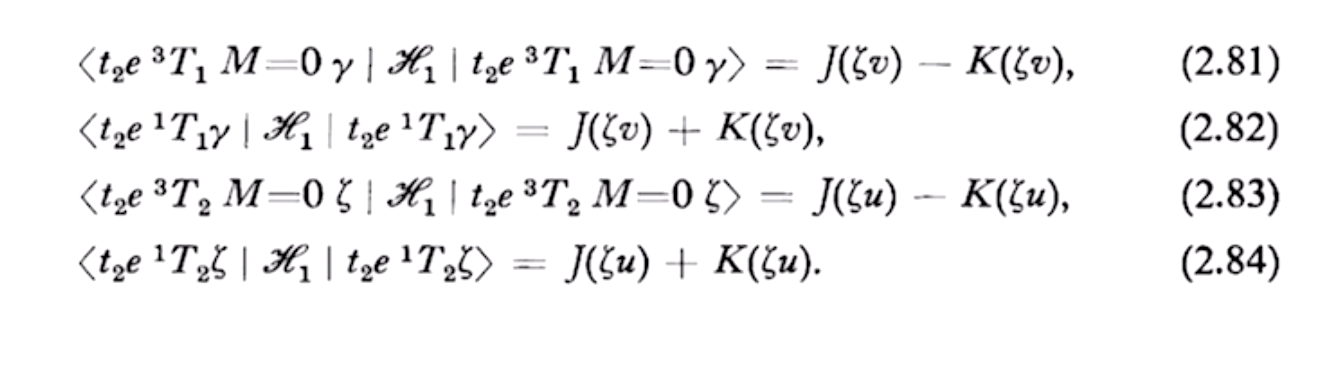

In [2023]:
# T1M=0 gamma
k1 = Qet({
      (1,zeta,-1,v): S(1)/sqrt(2),
      (-1,zeta,1,v): S(1)/sqrt(2)
      })
# t2e1T1gamma
k2 = Qet({
      (1,zeta,-1,v): S(1)/sqrt(2),
      (-1,zeta,1,v): -S(1)/sqrt(2)
      })
k3 = Qet({
      (1,zeta,-1,u): S(1)/sqrt(2),
      (-1,zeta,1,u): S(1)/sqrt(2)
      })
k4 = Qet({
      (1,zeta,-1,u): S(1)/sqrt(2),
      (-1,zeta,1,u): -S(1)/sqrt(2)
      })
for ket in [k1,k2,k3,k4]:
  braket0 = ket.dual() * ket
  braket1 = braket0.apply(det_braket_expand)
  braket2 = braket1.apply(match_spin)
  c_num = braket2.apply(interactionbraket)
  display(simplify(c_num.as_c_number_with_fun().subs(subs)))

J(zeta, v) - K(zeta, v)

J(zeta, v) + K(zeta, v)

J(zeta, u) - K(zeta, u)

J(zeta, u) + K(zeta, u)

In [2021]:
# eqn 2.73

braket0 = ket.dual() * ket
braket1 = braket0.apply(det_braket_expand)
braket2 = braket1.apply(match_spin)
c_num = braket2.apply(interactionbraket)
display(simplify(c_num.as_c_number_with_fun().subs(subs)))
display(1)

J(zeta, v) - K(zeta, v)

1

In [2016]:
%config Completer.use_jedi = False

### Problem 2.9

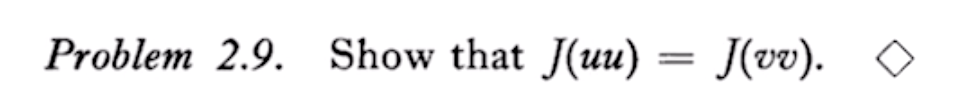

In [2086]:
def simplex(key,val):
  '''
  Brakets that have an even number of v's cancel out
  '''
#   return {key: val}
  if key.count(v) in [1,3]:
    return {():0}
  else:
    return {key: val}

In [2087]:
q1 = Qet({
  (u,) : -S(1)/2,
  (v,) : sqrt(3)/2})
qq = q1 * q1
qq2_1 = (qq * qq).apply(simplex)
(qq2_1.as_braket())

<uu|*|uu>/16 + 3*<uu|*|vv>/16 + 3*<uv|*|uv>/16 + 3*<uv|*|vu>/16 + 3*<vu|*|uv>/16 + 3*<vu|*|vu>/16 + 3*<vv|*|uu>/16 + 9*<vv|*|vv>/16

In [2088]:
q1 = Qet({
  (u,) : -sqrt(3)/2,
  (v,) : S(1)/2})
qq = q1 * q1
qq2_2 = (qq * qq).apply(simplex)
(qq2_2.as_braket())

9*<uu|*|uu>/16 + 3*<uu|*|vv>/16 + 3*<uv|*|uv>/16 + 3*<uv|*|vu>/16 + 3*<vu|*|uv>/16 + 3*<vu|*|vu>/16 + 3*<vv|*|uu>/16 + <vv|*|vv>/16

In [2089]:
qq2_1.as_braket() - qq2_2.as_braket()

-<uu|*|uu>/2 + <vv|*|vv>/2

This half difference being equal to the full diference, the difference must be zero.

In [2073]:
em = [[-S(1)/2,sqrt(3)/2],[-sqrt(3)/2,-S(1)/2]]
combos = []
for row in em:
  combo = Qet({(u,): row[0]}) + Qet({(v,): row[1]})
  combos.append(combo)

In [2076]:
from sympy.physics.quantum import TensorProduct

In [2080]:
tem = TensorProduct(Matrix(em),Matrix(em))
tem*tem.T

Matrix([
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1]])

In [2075]:
combos[0]+combos[1]

{(u,): -sqrt(3)/2 - 1/2, (v,): -1/2 + sqrt(3)/2}

### Problem 2.10

In [2090]:
import sys
sys.path.append('/Users/juan/Google Drive/Zia Lab/Codebase/qdef')

In [2091]:
from gtqdef import *

In [2092]:
CPG = CPGroups()

/Users/juan/Google Drive/Zia Lab/Codebase/qdef/gtqdef.py:79: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.array(self.CharacterTable)[:,0].astype(int).tolist()


In [2673]:
def parser(el):
  if '/' in el:
    numerator, denom = el.split('/')
    denom = int(denom)
    if 's' in numerator:
      if '-' in numerator:
        sign = -1
      else:
        sign = 1
      numerator = numerator.replace('-','')
      numerator = sign*sqrt(int(numerator.replace('s','')))
    return S(numerator)/denom
  else:
    return S(int(el))
    
ireps = {}

irep = {}
irep['E'] = '1,0;0,1'
irep['C_{4z}'] = '1,0;0,-1'
irep['C_{4z}^2'] = '1,0;0,1'
irep['C_{3xyz}'] = '-1/2,-s3/2;s3/2,-1/2'
irep['C_{2xy}'] = '1,0;0,-1'
for key, val in irep.items():
  rows = val.split(';')
  new_rows = []
  for row in rows:
    new_row = [parser(el) for el in row.split(',')]
    new_rows.append(new_row)
  irep[key] = list(zip(*new_rows))
ireps['E'] = {}
ireps['E']['matrices'] = dict(irep)
ireps['E']['basis'] = [u,v]

irep = {}
irep['E'] = '1,0,0;0,1,0;0,0,1'
irep['C_{4z}'] = '0,1,0;-1,0,0;0,0,-1'
irep['C_{4z}^2'] = '-1,0,0;0,-1,0;0,0,1'
irep['C_{3xyz}'] = '0,0,1;1,0,0;0,1,0'
irep['C_{2xy}'] = '0,-1,0;-1,0,0;0,0,1'
for key, val in irep.items():
  rows = val.split(';')
  new_rows = []
  for row in rows:
    new_row = [parser(el) for el in row.split(',')]
    new_rows.append(new_row)
  irep[key] = list(zip(*new_rows))
ireps['T2'] = {}
ireps['T2']['matrices'] = dict(irep)
ireps['T2']['basis'] = [xi, eta, zeta] 

irep = {}
irep['E'] = '1,0,0;0,1,0;0,0,1'
irep['C_{4z}'] = '0,-1,0;1,0,0;0,0,1'
irep['C_{4z}^2'] = '-1,0,0;0,-1,0;0,0,1'
irep['C_{3xyz}'] = '0,0,1;1,0,0;0,1,0'
irep['C_{2xy}'] = '0,1,0;1,0,0;0,0,-1'
for key, val in irep.items():
  rows = val.split(';')
  new_rows = []
  for row in rows:
    new_row = [parser(el) for el in row.split(',')]
    new_rows.append(new_row)
  irep[key] = list(zip(*new_rows))
ireps['T1'] = {}
ireps['T1']['matrices'] = dict(irep)
ireps['T1']['basis'] = [x,y,z] 

In [2696]:
# determine restrictions between brakets of ir1 and ir2
ir1, ir2 = 'E', 'E'
identities = []
# form all product states identities under ops
mats1, mats2 = ireps[ir1]['matrices'], ireps[ir2]['matrices']
syms1, syms2 = (ireps[ir1]['basis']), (ireps[ir2]['basis'])
states = [(s1,s2) for s1,s2 in product(syms1,syms2)]
p_basis = [s1+s2 for s1,s2 in product(states,states)]

good_ops = ['C_{3xyz}','C_{4z}']
good_ops = ['C_{3xyz}'] #,'E']

p_states1 = []
for op, mat in mats1.items():
  if op not in good_ops:
    continue
  print(op)
  for symbidx, row in enumerate(mat):
    p_states1.append(Qet({(syms1[symbidx],): 1}))

p_states2 = []
for op, mat in mats2.items():
  if op not in good_ops:
    continue
  for symbidx, row in enumerate(mat):
    p_states2.append(Qet({(syms2[symbidx],): 1}))

p_states1_sq_0 = [s1*s2 for s1,s2 in product(p_states1, p_states2)]
p_states1_sq = [s1*s2 for s1,s2 in product(p_states1_sq_0, p_states1_sq_0)]
    
t_states1 = []
for op, mat in mats1.items():
  if op not in good_ops:
    continue
  for row in mat:
    pairs = (list(zip(row,syms1)))
    pairs = [l for l in list(map(lambda x: Qet({(x[1],): x[0]}),pairs))]
    t_states1.append(qet_sum(pairs))
# t_states1_sq = [s1*s2 for s1,s2 in product(t_states1,t_states1)]

t_states2 = []
for op, mat in mats2.items():
  if op not in good_ops:
    continue
  for row in mat:
    pairs = (list(zip(row,syms2)))
    pairs = [l for l in list(map(lambda x: Qet({(x[1],): x[0]}),pairs))]
    t_states2.append(qet_sum(pairs))
  print(mat)

t_states2_sq_0 = [s1*s2 for s1,s2 in product(t_states1,t_states2)]
t_states2_sq = [s1*s2 for s1,s2 in product(t_states2_sq_0,t_states2_sq_0)]

# p_states2 = [(s1*s2) for s1,s2 in product(t_states1_sq,t_states2_sq)]
# pstates = [s1*s2 for s1,s2 in product(t_states1,t_states2)]

C_{3xyz}
[(-1/2, sqrt(3)/2), (-sqrt(3)/2, -1/2)]


In [2713]:
from sympy import eye

In [2920]:
ops = ['E','C_{4z}','C_{4z}^2','C_{3xyz}','C_{2xy}']
bigMatrix = Matrix([])
irep1 = 'T2'
irep2 = 'T2'
syms1, syms2 = (ireps[irep1]['basis']), (ireps[irep2]['basis'])
mats1, mats2 = ireps[irep1]['matrices'], ireps[irep2]['matrices']
states = [(s1,s2) for s1,s2 in product(syms1,syms2)]
l1, l2 = len(ireps[irep1]['basis']), len(ireps[irep2]['basis'])

states = [(s1,s2) for s1,s2 in product(syms1,syms2)]
p_basis = [s1+s2 for s1,s2 in product(states,states)]

for op in ops:
  mat1, mat2 = Matrix(mats1[op]), Matrix(mats2[op])
  g = (TensorProduct(mat1,mat2,mat1,mat2) - eye(l1*l1*l2*l2))
  bigMatrix = Matrix.vstack(bigMatrix,g)

# if basis functions are real there is a symmetry between exchange of symbols
permMatrix = Matrix([])
for basis_vec in p_basis:
  l0, l1, l2, l3 = basis_vec
  q1 = (l0,l1,l2,l3)
  q2 = (l2,l1,l0,l3)
  q3 = (l0,l3,l2,l1)
  q4 = (l2,l3,l0,l1)
  row = [0]*len(p_basis)
  row[p_basis.index(q1)] = (1)
  row[p_basis.index(q2)] = -(1)
  if row.count(1) == 1:
    row = Matrix([row])
    permMatrix = Matrix.vstack(permMatrix,row)
  row = [0]*len(p_basis)
  row[p_basis.index(q1)] = (1)
  row[p_basis.index(q3)] = -(1)
  if row.count(1) == 1:
    row = Matrix([row])
    permMatrix = Matrix.vstack(permMatrix,row)
  row = [0]*len(p_basis)
  row[p_basis.index(q1)] = (1)
  row[p_basis.index(q4)] = -(1)
  if row.count(1) == 1:
    row = Matrix([row])
    permMatrix = Matrix.vstack(permMatrix,row)
bigMatrix = Matrix.vstack(bigMatrix,permMatrix)

In [2976]:
variables = list(map(lambda x: Qet({x:1}),p_basis))
rref = bigMatrix.rref()
qets = []
for row in rref[0].rowspace():
  qet = Qet({():0})
  for bv, c  in zip(p_basis,row):
    qet = qet + Qet({(bv):c})
  qets.append(qet)
sol_eqns = ([qet.as_braket() for qet in qets])
sol_vars = ([qet.as_braket() for qet in variables])
subs = solve(sol_eqns,sol_vars)
for key,val in subs.items():
  if val!= 0:
    display(Math('%s = %s' % (latex(key), latex(val))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3009]:
ops = ['E','C_{4z}','C_{4z}^2','C_{3xyz}','C_{2xy}']
bigMatrix = Matrix([])
irep1 = 'T2'
irep2 = 'T2'
irep3 = 'T2'
irep4 = 'E'
all_ireps = [irep1,irep2,irep3,irep4]
syms = [ireps[ir]['basis'] for ir in all_ireps]
mats = [ireps[ir]['matrices'] for ir in all_ireps] 
states = list(product(*syms))
ls = [len(ireps[ir]['basis']) for ir in all_ireps]
hilbert_size = len(states)

for op in ops:
  mat1, mat2, mat3, mat4 = [Matrix(mat[op]) for mat in mats] #Matrix(mats1[op]), Matrix(mats2[op]), Matrix(mats3[op]), Matrix(mats4[op])
  g = (TensorProduct(mat1,mat2,mat3,mat4) - eye(hilbert_size))
  bigMatrix = Matrix.vstack(bigMatrix,g)

# if basis functions are real there is a symmetry between exchange of symbols
permMatrix = Matrix([])
for basis_vec in states:
  l0, l1, l2, l3 = basis_vec
  q1 = (l0,l1,l2,l3)
  q2 = (l2,l1,l0,l3)
  q3 = (l0,l3,l2,l1)
  q4 = (l2,l3,l0,l1)
  row = [0]*hilbert_size
  row[states.index(q1)] = (1)
  row[states.index(q2)] = -(1)
  if row.count(1) == 1:
    row = Matrix([row])
    permMatrix = Matrix.vstack(permMatrix,row)
bigMatrix = Matrix.vstack(bigMatrix,permMatrix)

In [3010]:
protectex = {
    zeta: r'{\zeta} ',
    eta: r'{\eta} ',
    xi: r'{\xi} '}
variables = list(map(lambda x: Qet({x:1}),states))
rref = bigMatrix.rref()
qets = []
for row in rref[0].rowspace():
  qet = Qet({():0})
  for bv, c  in zip(states,row):
    qet = qet + Qet({(bv):c})
  qets.append(qet)
sol_eqns = ([qet.as_braket() for qet in qets])
sol_vars = ([qet.as_braket() for qet in variables])
subs = solve(sol_eqns,sol_vars)
for key,val in subs.items():
  if val!= 0:
    display(Math('%s = %s' % (latex(key,symbol_names=protectex), latex(val,symbol_names=protectex))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3052]:
list(product('et',repeat=4))

[('e', 'e', 'e', 'e'),
 ('e', 'e', 'e', 't'),
 ('e', 'e', 't', 'e'),
 ('e', 'e', 't', 't'),
 ('e', 't', 'e', 'e'),
 ('e', 't', 'e', 't'),
 ('e', 't', 't', 'e'),
 ('e', 't', 't', 't'),
 ('t', 'e', 'e', 'e'),
 ('t', 'e', 'e', 't'),
 ('t', 'e', 't', 'e'),
 ('t', 'e', 't', 't'),
 ('t', 't', 'e', 'e'),
 ('t', 't', 'e', 't'),
 ('t', 't', 't', 'e'),
 ('t', 't', 't', 't')]

In [ ]:
from itert

[('e', 'e', 'e', 'e'),
 ('e', 'e', 'e', 't'),
 ('e', 'e', 't', 't'),
 ('e', 't', 't', 't'),
 ('t', 't', 't', 't')]

In [3069]:
ops = ['E','C_{4z}','C_{4z}^2','C_{3xyz}','C_{2xy}']
bigMatrix = Matrix([])
irep1, irep2, irep3, irep4 = 't2 t2 t2 t2'.upper().split()
all_ireps = [irep1,irep2,irep3,irep4]
syms = [ireps[ir]['basis'] for ir in all_ireps]
mats = [ireps[ir]['matrices'] for ir in all_ireps] 
states = list(product(*syms))
ls = [len(ireps[ir]['basis']) for ir in all_ireps]
hilbert_size = len(states)

for op in ops:
  mat1, mat2, mat3, mat4 = [Matrix(mat[op]) for mat in mats] #Matrix(mats1[op]), Matrix(mats2[op]), Matrix(mats3[op]), Matrix(mats4[op])
  g = (TensorProduct(mat1,mat2,mat3,mat4) - eye(hilbert_size))
  bigMatrix = Matrix.vstack(bigMatrix,g)

# if basis functions are real there is a symmetry between exchange of symbols
permMatrix = Matrix([])
for basis_vec in states:
  l0, l1, l2, l3 = basis_vec
  q1 = (l0,l1,l2,l3)
  q2 = (l2,l1,l0,l3)
  q3 = (l0,l3,l2,l1)
  q4 = (l2,l3,l0,l1)
  double1, double2 = False, False
  if irep1 == irep3:
    row = [0]*hilbert_size
    row[states.index(q1)] = (1)
    row[states.index(q2)] = -(1)
    if row.count(1) == 1:
      row = Matrix([row])
      permMatrix = Matrix.vstack(permMatrix,row)
    double1 = True
  if irep2 == irep4:
    row = [0]*hilbert_size
    row[states.index(q1)] = (1)
    row[states.index(q3)] = -(1)
    if row.count(1) == 1:
      row = Matrix([row])
      permMatrix = Matrix.vstack(permMatrix,row)
    double2 = True
  if double1 and double2:
    row = [0]*hilbert_size
    row[states.index(q1)] = (1)
    row[states.index(q4)] = -(1)
    if row.count(1) == 1:
      row = Matrix([row])
      permMatrix = Matrix.vstack(permMatrix,row)
if len(permMatrix)>0:
  bigMatrix = Matrix.vstack(bigMatrix,permMatrix)

protectex = {
    zeta: r'{\zeta} ',
    eta: r'{\eta} ',
    xi: r'{\xi} '}
variables = list(map(lambda x: Qet({x:1}),states))
rref = bigMatrix.rref()
qets = []
for row in rref[0].rowspace():
  qet = Qet({():0})
  for bv, c  in zip(states,row):
    qet = qet + Qet({(bv):c})
  qets.append(qet)
sol_eqns = ([qet.as_braket() for qet in qets])
sol_vars = ([qet.as_braket() for qet in variables])
subs = solve(sol_eqns,sol_vars)
print("There are %d independent integrals." % (len(states)-len(rref[0].rowspace())))
for key,val in subs.items():
  if val!= 0:
    display(Math('%s = %s' % (latex(key,symbol_names=protectex), latex(val,symbol_names=protectex))))

There are 3 independent integrals.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3198]:
def interaction_integrals(all_ireps):
  ops = ['C_{4z}','C_{4z}^2','C_{3xyz}','C_{2xy}']
  bigMatrix = Matrix([])
  syms = [ireps[ir]['basis'] for ir in all_ireps]
  mats = [ireps[ir]['matrices'] for ir in all_ireps] 
  states = list(product(*syms))
  ls = [len(ireps[ir]['basis']) for ir in all_ireps]
  hilbert_size = len(states)
  irep1, irep2, irep3, irep4 = all_ireps

  for op in ops:
    mat1, mat2, mat3, mat4 = [Matrix(mat[op]) for mat in mats]
    g = (TensorProduct(mat1,mat2,mat3,mat4) - eye(hilbert_size))
    bigMatrix = Matrix.vstack(bigMatrix,g)

  # if basis functions are real there is a symmetry between exchange of symbols
  permMatrix = Matrix([])
  for basis_vec in states:
    l0, l1, l2, l3 = basis_vec
    q1 = (l0,l1,l2,l3)
    q2 = (l2,l1,l0,l3)
    q3 = (l0,l3,l2,l1)
    q4 = (l2,l3,l0,l1)
    double1, double2 = False, False
    if irep1 == irep3:
      row = [0]*hilbert_size
      row[states.index(q1)] = (1)
      row[states.index(q2)] = -(1)
      if row.count(1) == 1:
        row = Matrix([row])
        permMatrix = Matrix.vstack(permMatrix,row)
      double1 = True
    if irep2 == irep4:
      row = [0]*hilbert_size
      row[states.index(q1)] = (1)
      row[states.index(q3)] = -(1)
      if row.count(1) == 1:
        row = Matrix([row])
        permMatrix = Matrix.vstack(permMatrix,row)
      double2 = True
    if double1 and double2:
      row = [0]*hilbert_size
      row[states.index(q1)] = (1)
      row[states.index(q4)] = -(1)
      if row.count(1) == 1:
        row = Matrix([row])
        permMatrix = Matrix.vstack(permMatrix,row)
  if len(permMatrix)>0:
    bigMatrix = Matrix.vstack(bigMatrix,permMatrix)

  protectex = {
      zeta: r'{\zeta} ',
      eta: r'{\eta} ',
      xi: r'{\xi} '}
  variables = list(map(lambda x: Qet({x:1}),states))
  rref = bigMatrix.rref()
  qets = []
  for row in rref[0].rowspace():
    qet = Qet({():0})
    for bv, c  in zip(states,row):
      qet = qet + Qet({(bv):c})
    qets.append(qet)
  sol_eqns = ([qet.as_braket() for qet in qets])
  sol_vars = ([qet.as_braket() for qet in variables])
  subs = solve(sol_eqns,sol_vars)
  indep_ints = (len(states)-len(rref[0].rowspace()))
  print("There are %d independent integrals." % indep_ints)
  for key,val in subs.items():
    if val!= 0:
      display(Math('%s = %s' % (latex(key,symbol_names=protectex), latex(val,symbol_names=protectex))))
  return indep_ints

In [3199]:
spacey = [s.split(',') for s in 't,t,t,t;t,t,t,e;t,t,e,e;t,e,e,e;e,e,e,e;e,e,t,t'.upper().replace('T','T2').split(';')]
results = []
for space in spacey:
  num_free = interaction_integrals(space)
  results.append((space,num_free))

There are 3 independent integrals.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

There are 1 independent integrals.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

There are 2 independent integrals.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

There are 0 independent integrals.
There are 2 independent integrals.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

There are 2 independent integrals.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3200]:
for r in results:
  print('%d: %s' % (r[1],':'.join(r[0])))

3: T2:T2:T2:T2
1: T2:T2:T2:E
2: T2:T2:E:E
0: T2:E:E:E
2: E:E:E:E
2: E:E:T2:T2


### Scraps

In [2824]:
# def as_braket(self):
#   sympyRep = S(0)
#   for key, coeff in self.dict.items():
#     l = int(len(key)/2)
#     if key == ():
#       sympyRep += coeff
#     else:
#       sympyRep += coeff*Bra(*key[:l])*Ket(*key[l:])
#   return sympyRep

In [2891]:
# matrices = Matrix([])
# for op, mat in mats2.items():
#   mat = Matrix(mat)
#   g = (TensorProduct(mat,mat,mat,mat) - eye(16))
#   matrices = Matrix.vstack(matrices,g)
# rref = matrices.rref()
# qets = []
# for row in rref[0].rowspace():
#   qet = Qet({():0})
#   for bv, c  in zip(p_basis,row):
#     qet = qet + Qet({bv:c})
#   qets.append(qet)
# for qet in qets:
#   display(qet.as_braket())

In [2892]:
# rreqns = ([reqns[0].row(idx) for idx in range(reqns[0].shape[0]) if reqns[0].row(idx).norm() != 0])a

In [2893]:
# t_states2_sq[0]

In [2894]:
# eqns = [tuple(calculate_row(p_basis, (ts2+(-1)*ts1))) for (ts1,ts2) in zip(p_states1_sq, t_states2_sq)]

In [2895]:
# eqns = Matrix(list(set(eqns)))

In [2896]:
# arrrref = np.array(eqns).astype(np.float64)

In [2897]:
# plt.figure()
# plt.imshow(arrrref)
# plt.show()

In [2684]:
# reqns = eqns.rref()

In [2884]:
def calculate_row(basis, qet):
  coeffs = [0] * len(basis)
  for idx, bqet in enumerate(basis):
    if bqet in qet.dict:
      coeffs[idx] = qet.dict[bqet]
  return coeffs

In [2685]:
rreqns = ([reqns[0].row(idx) for idx in range(reqns[0].shape[0]) if reqns[0].row(idx).norm() != 0])

In [2686]:
qets = []
for row_num in range(len(rreqns)):
  qet = Qet({():0})
  for bv, c  in zip(p_basis,rreqns[row_num]):
    qet = qet + Qet({bv:c})
  qets.append(qet)

In [2687]:
for qet in qets:
  display(qet.as_braket())

<uu|uu> - <vv|*|vv>

<uu|uv> + <vv|vu>

<uu|vu> + <vv|uv>

<uu|vv> - <vv|*|uu>

<uv|uu> + <vu|vv>

<uv|uv> - <vu|*|vu>

<uv|vu> + <vu|vu> + <vv|uu> - <vv|*|vv>

<uv|vv> + <vu|vv> + <vv|uv> + <vv|vu>

<vu|uu> - <vu|*|vv> - <vv|*|uv> - <vv|*|vu>

<vu|uv> + <vu|vu> + <vv|uu> - <vv|*|vv>

In [2644]:
import matplotlib.pyplot as plt

In [2645]:
arrrref = np.array(rreqns).astype(np.float64)[:,0,:]

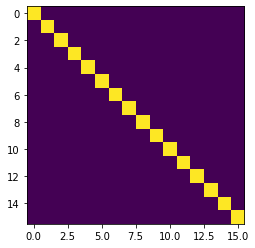

In [2646]:
plt.figure()
plt.imshow(arrrref)
plt.show()

In [2443]:
arrrref[30]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.])

In [2318]:
p_states1_sq[0]

{(xi, u, xi, u): 1}

In [2319]:
t_states2_sq[0]

{(xi, u, xi, u): 1}

In [2286]:
len(t_states2_sq)

150

In [ ]:
len(t_states2)

In [2277]:
for idx, row in enumerate(mat):
  print(idx,row)

0 (1, 0)
1 (0, -1)


In [2230]:
def qet_sum(qets):
  sqet = Qet({})
  for qet in qets:
    sqet = sqet + qet
  return sqet

In [2238]:
t_states1 = []
for op, mat in mats1.items():
  for row in mat:
    pairs = (list(zip(row,syms1)))
    pairs = [l for l in list(map(lambda x: Qet({(x[1],):x[0]}),pairs))]
    t_states1.append(qet_sum(pairs))

In [2239]:
t_states1

[{(xi,): 1},
 {(eta,): 1},
 {(zeta,): 1},
 {(eta,): -1},
 {(xi,): 1},
 {(zeta,): -1},
 {(xi,): -1},
 {(eta,): -1},
 {(zeta,): 1},
 {(eta,): 1},
 {(zeta,): 1},
 {(xi,): 1},
 {(eta,): -1},
 {(xi,): -1},
 {(zeta,): 1}]

In [2232]:
pairs[0] + pairs[1]

{xi: -sqrt(3)/2, eta: -1/2}

In [2229]:
qet_sum(pairs)

{(1, zeta, -1, u): sqrt(2), (-1, zeta, 1, u): -sqrt(2)}

In [2223]:
type(pairs)

list

In [2224]:
type(pairs[0])

__main__.Qet

In [2220]:
t_states1

[{xi: -1/2}, {eta: sqrt(3)/2}, {xi: -sqrt(3)/2}, {eta: -1/2}]

In [2176]:
t_states1 = []
for op, mat in mats1.items():
  for row in mat.rows:
    print(row)

TypeError: 'int' object is not iterable

In [2183]:
mat[0:]

[1, 0, 0, 0, 1, 0, 0, 0, 1]

In [2153]:
mats1

{'E': Matrix([
 [1, 0, 0],
 [0, 1, 0],
 [0, 0, 1]]),
 'C_{4z}': Matrix([
 [0, -1,  0],
 [1,  0,  0],
 [0,  0, -1]]),
 'C_{4z}^2': Matrix([
 [-1,  0, 0],
 [ 0, -1, 0],
 [ 0,  0, 1]]),
 'C_{3xyz}': Matrix([
 [0, 1, 0],
 [0, 0, 1],
 [1, 0, 0]]),
 'C_{2xy}': Matrix([
 [ 0, -1, 0],
 [-1,  0, 0],
 [ 0,  0, 1]])}

In [2151]:
pstates

[(xi, u, xi, u),
 (xi, u, xi, v),
 (xi, u, eta, u),
 (xi, u, eta, v),
 (xi, u, zeta, u),
 (xi, u, zeta, v),
 (xi, v, xi, u),
 (xi, v, xi, v),
 (xi, v, eta, u),
 (xi, v, eta, v),
 (xi, v, zeta, u),
 (xi, v, zeta, v),
 (eta, u, xi, u),
 (eta, u, xi, v),
 (eta, u, eta, u),
 (eta, u, eta, v),
 (eta, u, zeta, u),
 (eta, u, zeta, v),
 (eta, v, xi, u),
 (eta, v, xi, v),
 (eta, v, eta, u),
 (eta, v, eta, v),
 (eta, v, zeta, u),
 (eta, v, zeta, v),
 (zeta, u, xi, u),
 (zeta, u, xi, v),
 (zeta, u, eta, u),
 (zeta, u, eta, v),
 (zeta, u, zeta, u),
 (zeta, u, zeta, v),
 (zeta, v, xi, u),
 (zeta, v, xi, v),
 (zeta, v, eta, u),
 (zeta, v, eta, v),
 (zeta, v, zeta, u),
 (zeta, v, zeta, v)]

In [2144]:
for s1, s2 in product(syms1,syms2):
  print(s1,s2)

xi u
xi v
eta u
eta v
zeta u
zeta v


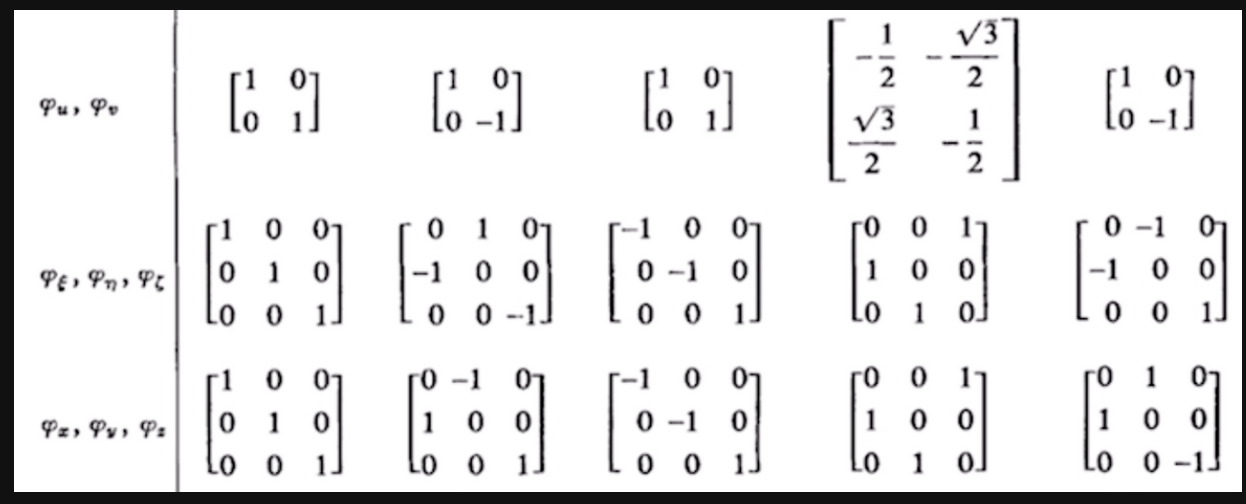

In [2095]:
dir(O)

['CharacterTable',
 'ClassSize',
 'Classes',
 'ElementCharacterTable',
 'Elements',
 'GroupOrderh',
 'IrrReps',
 'ParameterLabels',
 'ParameterTable',
 'PointGroupLabel',
 'PointGroupNumber',
 'RepresentationDegrees',
 'SpaceGroupElementNames',
 'SpaceGroupMatrices',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'addElementCharacters',
 'addParameterTable',
 'addRepDegrees',
 'addSpaceGroupElements',
 'elementPositions',
 'group_info',
 'printCharacterTable']

### Scribbles

In [3195]:
def det_braket_expand(key, val):
  '''
  This converts a braket
  of determinat states into
  regular brakets.
  (TSK 2.59)
  '''
  returndict = dict()
  m1, m2, m1p, m2p = key[::2]
  g1, g2, g1p, g2p = key[1::2]
  returndict[(m1,g1,m2,g2,m1p,g1p,m2p,g2p)] = val
  if (m1,g1,m2,g2,m1p,g1p,m2p,g2p) == (m1,g1,m2,g2,m2p,g2p,m1p,g1p):
    returndict[(m1,g1,m2,g2,m2p,g2p,m1p,g1p)] += -val
  else:
    returndict[(m1,g1,m2,g2,m2p,g2p,m1p,g1p)] = -val
  return returndict

J = Function("J")
K = Function("K")

def interactionbraket(key, val):
  '''
  This takes a braket
  and writes it up in terms
  of J and K integrals
  (TSK 2.61)
  '''
  returndict = dict()
  g1, g2, g1p, g2p = key
  if (g1 == g1p) and (g2 == g2p):
    returndict[(g1,g2)] = val
  else:
    returndict[(g1,g1p)] = val
  return returndict


In [3370]:
docstr = '''Given the labels for four irreducible representations (factor_ireps)
and a dictionary (ireps) with matrices and basis symbols for operations in the 
symmetry group,
this function determines which two electron spherical
brakets are linearly dependent and what is their dependence
to the linearly independent ones.

In the braket <γ1γ2|1/r|γ3γ4>:

 γ1 -> all_ireps[0]

 γ2 -> all_ireps[1]

 γ3 -> all_ireps[2]

 γ4 -> all_ireps[3].

The function returns a dictionary that gives the dependent brakets in terms of the independent ones.
As of now this has been tested for the cubic group O.'''
paragraphs = docstr.split('\n\n')

for i in range(len(paragraphs)):
  aparagraph = paragraphs[i].replace('\n', ' ').replace('  ', ' ')
  paragraphs[i] = '\n'.join(justify(aparagraph,60))
docstr = '\n'.join(paragraphs)
print(docstr)

Given  the  labels  for  four  irreducible   representations
(factor_ireps) and a dictionary (ireps)  with  matrices  and
basis symbols for operations in  the  symmetry  group,  this
function determines which two electron spherical brakets are
linearly dependent and  what  is  their  dependence  to  the
linearly independent ones.
In the braket <γ1γ2|1/r|γ3γ4>:
 γ1 -> all_ireps[0]
 γ2 -> all_ireps[1]
 γ3 -> all_ireps[2]
 γ4 -> all_ireps[3].
The function returns a dictionary that gives  the  dependent
brakets in terms of the independent ones. As of now this has
been tested for the cubic group O.


In [3377]:
Oireps = pickle.load(open('/Users/juan/Google Drive/Zia Lab/Log/Data/Oireps.pkl','rb'))

In [2]:
from sympy import Matrix

In [3]:
from sympy import symbols

In [4]:
from sympy.physics.quantum import TensorProduct

In [14]:
u, v, zeta, eta = symbols("u v zeta eta")
gamma, delta = symbols("gamma delta")

In [15]:
TensorProduct(Matrix([[u,v]]), Matrix([[zeta,eta]]), Matrix([[gamma,delta]]))

Matrix([[gamma*u*zeta, delta*u*zeta, eta*gamma*u, delta*eta*u, gamma*v*zeta, delta*v*zeta, eta*gamma*v, delta*eta*v]])

In [12]:
from itertools import product

In [18]:
(list(product([u,v],[zeta,eta],[gamma,delta])))

[(u, zeta, gamma),
 (u, zeta, delta),
 (u, eta, gamma),
 (u, eta, delta),
 (v, zeta, gamma),
 (v, zeta, delta),
 (v, eta, gamma),
 (v, eta, delta)]

In [3380]:
def interaction_integrals(factor_ireps, ireps, verbose=False):
  '''
  Given  the  labels  for  four  irreducible   representations
  (factor_ireps) and a dictionary (ireps)  with  matrices  and
  basis symbols for operations in  the  symmetry  group,  this
  function determines which two electron spherical brakets are
  linearly dependent and  what  is  their  dependence  to  the
  linearly independent ones.
  In the braket <γ1γ2|R|γ3γ4>:
   γ1 -> all_ireps[0]
   γ2 -> all_ireps[1]
   γ3 -> all_ireps[2]
   γ4 -> all_ireps[3].
  The function returns a dictionary that gives  the  dependent
  brakets in terms of the independent ones. As of now this has
  been tested for the cubic group O.
  '''
  
  # get the names for the symmetry operations
  ops = list(list(ireps.values())[0]['matrices'].keys())
  # the identity op won't provide any information
  ops.remove('E')
  
  # initialize an empty matrix
  bigMatrix = Matrix([])
  # collect the symbols from the all the ireps
  syms = [ireps[ir]['basis'] for ir in factor_ireps]
  # collect the matrices
  mats = [ireps[ir]['matrices'] for ir in factor_ireps]
  # compute all symbols for four symbol brakets
  states = list(product(*syms))
  # query the size of each irep
  ls = [len(ireps[ir]['basis']) for ir in factor_ireps]
  # determine how many four symbol brakets there are
  hilbert_size = len(states)
  
  irep1, irep2, irep3, irep4 = factor_ireps
  
  # how the four symbol brakets are dependent on each
  # other may be  found  by  vertically stacking  the
  # tensor products of the matrices that correspond to
  # all of the group operations, subtracting the identity
  # from this blocks, and finding the resulting reduced
  # echelon form
  
  for op in ops:
    mat1, mat2, mat3, mat4 = [Matrix(mat[op]) for mat in mats]
    g = (TensorProduct(mat1,mat2,mat3,mat4) - eye(hilbert_size))
    bigMatrix = Matrix.vstack(bigMatrix,g)

  # If basis functions are real, and there are repeated ireps, 
  # then there is also a symmetry between exchange of symbols
  
  permMatrix = Matrix([])
  for basis_vec in states:
    l0, l1, l2, l3 = basis_vec
    q1 = (l0,l1,l2,l3)
    q2 = (l2,l1,l0,l3)
    q3 = (l0,l3,l2,l1)
    q4 = (l2,l3,l0,l1)

    if irep1 == irep3:
      row = [0]*hilbert_size
      row[states.index(q1)] = 1
      row[states.index(q2)] = -1
      if row.count(1) == 1:
        row = Matrix([row])
        permMatrix = Matrix.vstack(permMatrix,row)

    if irep2 == irep4:
      row = [0]*hilbert_size
      row[states.index(q1)] = 1
      row[states.index(q3)] = -1
      if row.count(1) == 1:
        row = Matrix([row])
        permMatrix = Matrix.vstack(permMatrix,row)

    if (irep1 == irep3) and (irep2 == irep4):
      row = [0]*hilbert_size
      row[states.index(q1)] = 1
      row[states.index(q4)] = -1
      if row.count(1) == 1:
        row = Matrix([row])
        permMatrix = Matrix.vstack(permMatrix,row)
  if len(permMatrix)>0:
    bigMatrix = Matrix.vstack(bigMatrix,permMatrix)

  protectex = {
      zeta: r'{\zeta} ',
      eta: r'{\eta} ',
      xi: r'{\xi} '}
  variables = list(map(lambda x: Qet({x:1}),states))
  rref = bigMatrix.rref()
  qets = []
  for row in rref[0].rowspace():
    qet = Qet({():0})
    for bv, c  in zip(states,row):
      qet = qet + Qet({(bv):c})
    qets.append(qet)
  sol_eqns = ([qet.as_braket() for qet in qets])
  sol_vars = ([qet.as_braket() for qet in variables])
  subs = solve(sol_eqns,sol_vars)
  indep_ints = (len(states)-len(rref[0].rowspace()))
  if verbose:
    print("There are %d independent integrals." % indep_ints)
    for key,val in subs.items():
      if val!= 0:
        display(Math('%s = %s' % (latex(key,symbol_names=protectex), latex(val,symbol_names=protectex))))
  return subs

In [3381]:
interaction_integrals(('T2','T2','T2','E'), Oireps)

{<xixi|xiu>: 0,
 <xixi|xiv>: 0,
 <xixi|etau>: 0,
 <xixi|etav>: 0,
 <xixi|zetau>: 0,
 <xixi|zetav>: 0,
 <xieta|xiu>: 0,
 <xieta|xiv>: 0,
 <xieta|etau>: 0,
 <xieta|etav>: 0,
 <xieta|zetau>: sqrt(3)*<zetaeta|xiv>/3,
 <xieta|zetav>: <zetaeta|xiv>,
 <xizeta|etau>: -2*sqrt(3)*<zetaeta|xiv>/3,
 <etaxi|zetau>: sqrt(3)*<zetaeta|xiv>/3,
 <etaxi|zetav>: -<zetaeta|xiv>,
 <etazeta|xiu>: -2*sqrt(3)*<zetaeta|xiv>/3,
 <zetaxi|etau>: sqrt(3)*<zetaeta|xiv>/3,
 <zetaxi|etav>: -<zetaeta|xiv>,
 <zetaeta|xiu>: sqrt(3)*<zetaeta|xiv>/3,
 <xizeta|xiu>: 0,
 <xizeta|xiv>: 0,
 <xizeta|etav>: 0,
 <xizeta|zetau>: 0,
 <xizeta|zetav>: 0,
 <etaxi|xiu>: 0,
 <etaxi|xiv>: 0,
 <etaxi|etau>: 0,
 <etaxi|etav>: 0,
 <etaeta|xiu>: 0,
 <etaeta|xiv>: 0,
 <etaeta|etau>: 0,
 <etaeta|etav>: 0,
 <etaeta|zetau>: 0,
 <etaeta|zetav>: 0,
 <etazeta|xiv>: 0,
 <etazeta|etau>: 0,
 <etazeta|etav>: 0,
 <etazeta|zetau>: 0,
 <etazeta|zetav>: 0,
 <zetaxi|xiu>: 0,
 <zetaxi|xiv>: 0,
 <zetaxi|zetau>: 0,
 <zetaxi|zetav>: 0,
 <zetaeta|etau>: 0,
 <zet

In [3202]:
subs_dict = {}
subs_dict[('T2','T2','T2','T2')] = interaction_integrals(['T2','T2','T2','T2'])
subs_dict[('T2','E','T2','E')] = interaction_integrals(('T2','E','T2','E'))
subs_dict[('T2','E','T2','T2')] = interaction_integrals(('T2','E','T2','T2'))
subs_dict[('T2','T2','T2','E')] = interaction_integrals(('T2','T2','T2','E'))
all_subs = {}
for key, val in subs_dict.items():
  all_subs.update(val)

There are 3 independent integrals.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

There are 2 independent integrals.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

There are 1 independent integrals.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

There are 1 independent integrals.


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3187]:
def match_spin(key,val):
  '''
  This nulls brakets with no matching spin values,
  after this spin is considered irrelevant.
  (TSK 2.61)
  '''
  m1, m2, m1p, m2p = key[::2]
  g1, g2, g1p, g2p = key[1::2]
  if dirac((m1,m2),(m1p,m2p)):
    return {(g1,g2,g1p,g2p): val}
  else:
    return {():0}

In [3188]:
 {zeta: '{\\zeta} ', eta: '{\\eta} ', xi: '{\\xi} '}

{zeta: '{\\zeta} ', eta: '{\\eta} ', xi: '{\\xi} '}

In [3189]:
# psi1 = Qet({
#       (1,zeta,-1,u): S(1)/sqrt(2),
#       (-1,zeta,1,u): -S(1)/sqrt(2)
#       })

# psi2 = Qet({
#       (1,xi,-1,eta): S(1)/sqrt(2),
#       (-1,xi,1,eta): -S(1)/sqrt(2)
#       })
psi1 = Qet({
      (1,zeta,-1,v): S(1)/sqrt(2),
      (-1,zeta,1,v): S(1)/sqrt(2)
      })

psi2 = Qet({
      (1,xi,-1,eta): S(1)/sqrt(2),
      (-1,xi,1,eta): S(1)/sqrt(2)
      })
ham_matrix = []
for ket1 in [psi1, psi2]:
  row = []
  for ket2 in [psi1, psi2]:
    subs = subs_dict
    braket0 = ket1 * ket2
    braket1 = braket0.apply(det_braket_expand)
    braket2 = braket1.apply(match_spin).as_braket().subs(all_subs,simultaneous=True)
    display(Math(latex(braket2, symbol_names=protectex)))
    row.append(braket2)
  ham_matrix.append(row)
#   c_num = braket2.apply(interactionbraket)
# #   display(simplify(c_num.as_c_number_with_fun().subs(subs)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [3191]:
Qet({(xi,eta,xi,eta):1,
    (xi,xi,eta,eta):-1}).as_braket().subs(all_subs,simultaneous=True)

-<xixi|zetazeta> + <zetaeta|zetaeta>

In [3194]:
display(Math(latex(Qet({(zeta,v,zeta,v):1,
    (zeta,zeta,v,v):-1}).as_braket().subs(all_subs,simultaneous=True), symbol_names=protectex)))

<IPython.core.display.Math object>

In [3171]:
(psi1 * psi2).apply(det_braket_expand).as_braket()

-<-1zeta1u|-1eta1xi>/2 - <-1zeta1u|-1xi1eta>/2 + <-1zeta1u|1eta-1xi>/2 + <-1zeta1u|1xi-1eta>/2 - <1zeta-1u|-1eta1xi>/2 - <1zeta-1u|-1xi1eta>/2 + <1zeta-1u|1eta-1xi>/2 + <1zeta-1u|1xi-1eta>/2

In [3172]:
(psi2 * psi1).apply(det_braket_expand).as_braket()

-<1eta-1xi|-1u1zeta>/2 + <1eta-1xi|-1zeta1u>/2 - <1eta-1xi|1u-1zeta>/2 + <1eta-1xi|1zeta-1u>/2 - <1xi-1eta|-1u1zeta>/2 + <1xi-1eta|-1zeta1u>/2 - <1xi-1eta|1u-1zeta>/2 + <1xi-1eta|1zeta-1u>/2

In [3173]:
(psi1 * psi2).apply(det_braket_expand).apply(match_spin).as_braket()

0

In [3174]:
(psi2 * psi1).apply(det_braket_expand).apply(match_spin).as_braket()

-<etaxi|uzeta>/2 + <etaxi|zetau>/2 - <xieta|uzeta>/2 + <xieta|zetau>/2

In [3152]:
(psi2 * psi1).apply(det_braket_expand).as_braket()

-<1eta-1xi|-1u1zeta>/2 + <1eta-1xi|-1zeta1u>/2 - <1eta-1xi|1u-1zeta>/2 + <1eta-1xi|1zeta-1u>/2 - <1xi-1eta|-1u1zeta>/2 + <1xi-1eta|-1zeta1u>/2 - <1xi-1eta|1u-1zeta>/2 + <1xi-1eta|1zeta-1u>/2

In [3148]:
(psi1 * psi2).apply(det_braket_expand).apply(match_spin)

(1, zeta, -1, u, -1, eta, 1, xi) -1/2
(1, zeta, -1, u, -1, xi, 1, eta) -1/2
(-1, zeta, 1, u, 1, xi, -1, eta) 1/2
(-1, zeta, 1, u, 1, eta, -1, xi) 1/2


{}

In [3134]:
display(Math(latex(Matrix(ham_matrix),symbol_names = protectex)))

<IPython.core.display.Math object>

In [3110]:
braket2

{(xi, eta, xi, eta): 1/2, (xi, eta, eta, xi): 1/2, (eta, xi, xi, eta): 1/2, (eta, xi, eta, xi): 1/2}

### Organized Scribbles (start putting things into a module)

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sympy import Symbol, pi, sqrt, Sum, simplify, Rational, Q, refine
from sympy import poly, lambdify
from sympy import diff, factorial, poly, symbols, latex
from sympy.physics.quantum import TensorProduct

from IPython.display import display, Math 
import matplotlib.pyplot as plt

%config Completer.use_jedi = False
%config InlineBackend.figure_format='retina'

from qdefvstsk import *

In [3]:
two_electron_configs('A1','T2',False,True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Problem 2.12

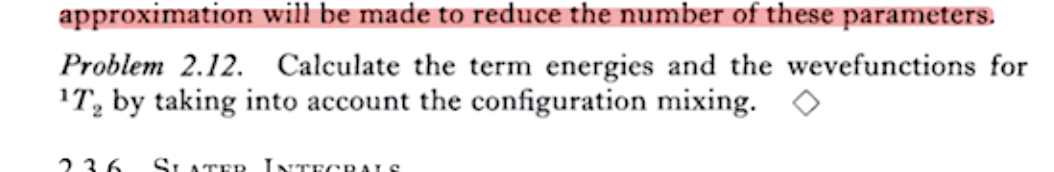

In [27]:
electron_configs_0 = two_electron_configs('E','T2',True,True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [33]:
singlets_0 = {k: v for k, v in electron_configs_0.items() if k[1] == 0}

# END